# General analysis of WV-WV cell types

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import networkx as nx
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
import bokeh.palettes
mpl.rcParams['figure.dpi'] = 300

## Organizing data

In [3]:
#import connections/synapses data from FlyWire
connections = pd.read_csv('connections_princeton.csv.gz', compression='gzip').drop(columns='neuropil')

#since certain root ids express different neurotransmitters, the same connection shows up multiple times due to different nt types
#group by neurotransmitters, df only keeps connections with primary nt (nt connection highest syn count for each pre root id)
ntsgrouped = connections.groupby(['pre_root_id', 'post_root_id', 'nt_type'], as_index=False)[['syn_count']].sum()

#keep only the strongest connection for duplicate connections with different nt types
conns = ntsgrouped.sort_values(by='syn_count', ascending=False).drop_duplicates(subset=['pre_root_id', 'post_root_id'], keep='first')
conns

pre_root_id        post_root_id nt_type  syn_count
3687238  720575940650935673  720575940640736371    GABA       2633
2320879  720575940628069501  720575940633305681    GABA       2597
3596036  720575940644702112  720575940625952755    GABA       2238
1631524  720575940623475324  720575940627497244    GABA       2179
1246516  720575940620975696  720575940624547622      DA       1872
...                     ...                 ...     ...        ...
3073466  720575940633914413  720575940615905130    GLUT          5
1582223  720575940623166600  720575940622950424     ACH          5
3073469  720575940633914413  720575940622525168    GLUT          5
1582220  720575940623166600  720575940618583877     ACH          5
3732459  720575940661339777  720575940631325740     ACH          5

[3732460 rows x 4 columns]

In [4]:
#import cell types dataframe from FlyWire
celltypes = pd.read_csv('consolidated_cell_types.csv.gz', compression='gzip')
celltypes = celltypes.rename(columns={'primary_type':'type'})

#import list of wvwvs from prof. gutierrez
wvwv_bakerlab = pd.read_csv('WV-WV 20250506 - Sheet1.csv')

#make obj names for each wvwv root id for easier querying further down the line
wvwv_rootids = wvwv_bakerlab['Codex Root ID'].tolist()
wvwv1_rootids = (wvwv_bakerlab[wvwv_bakerlab['Cell type'] == 'WV-WV-1'])['Codex Root ID'].tolist()
wvwv2_rootids = (wvwv_bakerlab[wvwv_bakerlab['Cell type'] == 'WV-WV-2'])['Codex Root ID'].tolist()
wvwv3_rootids = (wvwv_bakerlab[wvwv_bakerlab['Cell type'] == 'WV-WV-3'])['Codex Root ID'].tolist()
wvwv4_rootids = (wvwv_bakerlab[wvwv_bakerlab['Cell type'] == 'WV-WV-4'])['Codex Root ID'].tolist()

#changing type names of wv-wv-3s to wv-wv-4s (per Baker et al.)

celltypes.loc[celltypes['root_id'].isin(wvwv4_rootids), 'type']='WV-WV-4'

celltypes


root_id    type additional_type(s)
0       720575940596125868     T5c                NaN
1       720575940597856265    Tm16                NaN
2       720575940597944841     Tm7             CB3851
3       720575940598267657   TmY15                NaN
4       720575940599333574     Tm1                NaN
...                    ...     ...                ...
137672  720575940661335681  CB0180                NaN
137673  720575940661336193    TmY3                NaN
137674  720575940661337217  KCab-p                NaN
137675  720575940661338497  CB0904                NaN
137676  720575940661339777    R1-6                NaN

[137677 rows x 3 columns]

In [5]:
#import auditory neuron mode preference df from ahmed lab
aud_neurons = pd.read_csv('train_dat.csv')
aud_neurons

#change column names so easier to do operations

aud_neurons = aud_neurons.rename(columns={
    'Flywire 2024 ID':'root_id',
    'Neuropils':'type' 
    }).drop([
        'Unnamed: 0',
        '# imaged females', 
        '# responding females',
        'prop females with auditory responses'], axis=1
        )
aud_neurons

root_id       type preference
0    720575940619783518  AVLP_pr01       sine
1    720575940620062633  AVLP_pr01       sine
2    720575940602914988  AVLP_pr01       sine
3    720575940620195719  AVLP_pr01       sine
4    720575940634508174  AVLP_pr01       sine
..                  ...        ...        ...
398  720575940655398817   GNG_pr01       sine
399  720575940630203589   GNG_pr01       sine
400  720575940617641077   GNG_pr01       sine
401  720575940612801022   GNG_pr01       sine
402  720575940630571068   GNG_pr01       sine

[403 rows x 3 columns]

In [6]:
#merge celltypes and aud_neurons into one prioritized labels/types df, which will be used first when merging with conns df
#if there is no correpsonding cell type from Baker/Ahmed lab data, then fill in with cell types data from FlyWire

types = pd.merge(
    celltypes,
    aud_neurons,
    on = 'root_id',
    how = 'left',
    suffixes = ('_celltypes', '_aud')
)

types['type'] = types['type_aud'].combine_first(types['type_celltypes'])
types = types[['root_id', 'type', 'preference']]
types

root_id    type preference
0       720575940596125868     T5c        NaN
1       720575940597856265    Tm16        NaN
2       720575940597944841     Tm7        NaN
3       720575940598267657   TmY15        NaN
4       720575940599333574     Tm1        NaN
...                    ...     ...        ...
137672  720575940661335681  CB0180        NaN
137673  720575940661336193    TmY3        NaN
137674  720575940661337217  KCab-p        NaN
137675  720575940661338497  CB0904        NaN
137676  720575940661339777    R1-6        NaN

[137677 rows x 3 columns]

In [7]:
#Christa Baker just shared the list of auditory neurons with me so I'm going to use this table from ahmed lab twist for classifications (all neurons in this dataframe will be considered auditory)

auditory_cells = pd.read_csv('Auditory neurons Lockwood et al - Sheet1.csv')

#create list of auditory ids for table filtering
aud_ids = auditory_cells['Codex June 2024'].tolist()

#since the baker spreadsheet has better labelling of cell types, see if any cells listed as 'auditory' have generic names, and change if possible

aud_types = types[types['root_id'].isin(aud_ids)][['root_id', 'type']].drop_duplicates()

#since all generic names start with CB filter for those
#renaming generic cell type names with non-generic ones (if possible) will make analysis easier

aud_generic_typenames = aud_types[aud_types['type'].str.contains('CB')]

aud_generic_rootids = aud_generic_typenames['root_id'].tolist()
aud_generic_rootids

[720575940603903264,
 720575940603930046,
 720575940606919602,
 720575940614190242,
 720575940615308729,
 720575940615503249,
 720575940615894877,
 720575940616748756,
 720575940618149336,
 720575940618772719,
 720575940620833974,
 720575940621159181,
 720575940623020263,
 720575940623855397,
 720575940624463242,
 720575940624571116,
 720575940625146122,
 720575940625466387,
 720575940625597317,
 720575940626990086,
 720575940627027087,
 720575940628244064,
 720575940629133071,
 720575940629394232,
 720575940629552170,
 720575940630214564,
 720575940634545294,
 720575940636705502,
 720575940644300323,
 720575940644488727,
 720575940650920569]

In [8]:
#now see if any of these have type name labelling from lockwood et al spreadsheet

new_labels = auditory_cells[auditory_cells['Codex June 2024'].isin(aud_generic_rootids)][['Cell type (Baker et al 2022)', 'Codex June 2024']].dropna() #these are names that can added to types_conns and types
new_labels

codex_generic_type = types[types['root_id'].isin(new_labels['Codex June 2024'])]
codex_generic_type

display(new_labels, codex_generic_type)

Cell type (Baker et al 2022)     Codex June 2024
452                        vpoIN  720575940636705502
453                        vpoIN  720575940615894877
454                         pMN1  720575940624463242
455                         pMN1  720575940644300323
460                        pC2la  720575940623855397
463                        pC2la  720575940634545294

root_id    type preference
25159   720575940615894877  CB1385        NaN
62510   720575940623855397  CB1161        NaN
66096   720575940624463242  CB0666        NaN
114657  720575940634545294  CB2375        NaN
120072  720575940636705502  CB1385        NaN
132092  720575940644300323  CB0666        NaN

In [9]:
#replace names by first matching root ids from both dfs

matching_types = pd.merge(
    codex_generic_type,
    new_labels,
    how = 'left',
    left_on = 'root_id',
    right_on = 'Codex June 2024'
)
matching_types

root_id    type preference Cell type (Baker et al 2022)  \
0  720575940615894877  CB1385        NaN                        vpoIN   
1  720575940623855397  CB1161        NaN                        pC2la   
2  720575940624463242  CB0666        NaN                         pMN1   
3  720575940634545294  CB2375        NaN                        pC2la   
4  720575940636705502  CB1385        NaN                        vpoIN   
5  720575940644300323  CB0666        NaN                         pMN1   

      Codex June 2024  
0  720575940615894877  
1  720575940623855397  
2  720575940624463242  
3  720575940634545294  
4  720575940636705502  
5  720575940644300323

In [10]:
#merge first onto presynaptic (all type and preference information refers to presynaptic cell)

conns_firstmerge = conns.merge(
    types,
    how = 'left',
    left_on = 'pre_root_id',
    right_on = 'root_id'
).drop(columns='root_id').rename(columns={'type':'type_pre', 'preference':'pref_pre'})

#merge again this time for postsynaptic (type and preference information refers to postsynaptic cell)

conns_types = conns_firstmerge.merge(
    types,
    how = 'left',
    left_on = 'post_root_id',
    right_on = 'root_id'
).drop(columns='root_id').rename(columns={'type':'type_post', 'preference':'pref_post'})

conns_types = conns_types[['pre_root_id', 'post_root_id', 'syn_count', 'nt_type', 'type_pre', 'type_post', 'pref_pre', 'pref_post']]
conns_types

pre_root_id        post_root_id  syn_count nt_type type_pre  \
0        720575940650935673  720575940640736371       2633    GABA     Li32   
1        720575940628069501  720575940633305681       2597    GABA     Li32   
2        720575940644702112  720575940625952755       2238    GABA     LT39   
3        720575940623475324  720575940627497244       2179    GABA     LT39   
4        720575940620975696  720575940624547622       1872      DA      DPM   
...                     ...                 ...        ...     ...      ...   
3732455  720575940633914413  720575940615905130          5    GLUT    TmY14   
3732456  720575940623166600  720575940622950424          5     ACH       L5   
3732457  720575940633914413  720575940622525168          5    GLUT    TmY14   
3732458  720575940623166600  720575940618583877          5     ACH       L5   
3732459  720575940661339777  720575940631325740          5     ACH     R1-6   

        type_post pref_pre pref_post  
0            Li30      NaN       NaN  
1            Li30      NaN       NaN  
2            Li33      NaN       NaN  
3            Li33      NaN       NaN  
4             APL      NaN       NaN  
...           ...      ...       ...  
3732455      Pm11      NaN       NaN  
3732456      Tm21      NaN       NaN  
3732457      Li26      NaN       NaN  
3732458      TmY3      NaN       NaN  
3732459      R1-6      NaN       NaN  

[3732460 rows x 8 columns]

In [11]:
#add 'class' column distinguishing each neuron as auditory or non auditory based on csv provided by Baker
#create new column specifically stating whether non-wvwv cell is auditory or not

conns_types['class_pre'] = np.where(conns_types['pre_root_id'].isin(aud_ids), 'auditory', 'non-auditory')
conns_types['class_post'] = np.where(conns_types['post_root_id'].isin(aud_ids), 'auditory', 'non-auditory')

conns_types

pre_root_id        post_root_id  syn_count nt_type type_pre  \
0        720575940650935673  720575940640736371       2633    GABA     Li32   
1        720575940628069501  720575940633305681       2597    GABA     Li32   
2        720575940644702112  720575940625952755       2238    GABA     LT39   
3        720575940623475324  720575940627497244       2179    GABA     LT39   
4        720575940620975696  720575940624547622       1872      DA      DPM   
...                     ...                 ...        ...     ...      ...   
3732455  720575940633914413  720575940615905130          5    GLUT    TmY14   
3732456  720575940623166600  720575940622950424          5     ACH       L5   
3732457  720575940633914413  720575940622525168          5    GLUT    TmY14   
3732458  720575940623166600  720575940618583877          5     ACH       L5   
3732459  720575940661339777  720575940631325740          5     ACH     R1-6   

        type_post pref_pre pref_post     class_pre    class_post  
0            Li30      NaN       NaN  non-auditory  non-auditory  
1            Li30      NaN       NaN  non-auditory  non-auditory  
2            Li33      NaN       NaN  non-auditory  non-auditory  
3            Li33      NaN       NaN  non-auditory  non-auditory  
4             APL      NaN       NaN  non-auditory  non-auditory  
...           ...      ...       ...           ...           ...  
3732455      Pm11      NaN       NaN  non-auditory  non-auditory  
3732456      Tm21      NaN       NaN  non-auditory  non-auditory  
3732457      Li26      NaN       NaN  non-auditory  non-auditory  
3732458      TmY3      NaN       NaN  non-auditory  non-auditory  
3732459      R1-6      NaN       NaN  non-auditory  non-auditory  

[3732460 rows x 10 columns]

In [12]:
#filter table for only wv-wv connections (this will be the df i work off of the most)
#presynaptic wv-wv cells
wvwv_outputs = conns_types[conns_types['pre_root_id'].isin(wvwv_rootids)]
wvwv_outputs

pre_root_id        post_root_id  syn_count nt_type type_pre  \
1300     720575940605214636  720575940624750480        295    GABA  WV-WV-3   
1512     720575940605214636  720575940639118926        280    GABA  WV-WV-3   
1629     720575940604201830  720575940622838154        273    GABA  WV-WV-3   
3847     720575940605214636  720575940619654053        215    GABA  WV-WV-3   
4577     720575940623322877  720575940630258003        203    GABA  WV-WV-1   
...                     ...                 ...        ...     ...      ...   
3711339  720575940623322877  720575940609825033          5    GABA  WV-WV-1   
3711369  720575940623322877  720575940608606933          5    GABA  WV-WV-1   
3711370  720575940623322877  720575940607957769          5    GABA  WV-WV-1   
3711371  720575940623322877  720575940607775106          5    GABA  WV-WV-1   
3711372  720575940623322877  720575940604653484          5    GABA  WV-WV-1   

        type_post pref_pre     pref_post class_pre    class_post  
1300        DNg24      NaN           NaN  auditory  non-auditory  
1512        DNg24      NaN           NaN  auditory  non-auditory  
1629        DNp01      NaN           NaN  auditory      auditory  
3847        DNp02      NaN           NaN  auditory  non-auditory  
4577     WED_pr02      NaN  intermediate  auditory      auditory  
...           ...      ...           ...       ...           ...  
3711339    CB1192      NaN           NaN  auditory  non-auditory  
3711369    WED056      NaN           NaN  auditory  non-auditory  
3711370    CB2144      NaN           NaN  auditory  non-auditory  
3711371    CB2858      NaN           NaN  auditory  non-auditory  
3711372    CB0466      NaN           NaN  auditory  non-auditory  

[2585 rows x 10 columns]

In [13]:
#postsynaptic wv-wv cells
wvwv_inputs = conns_types[conns_types['post_root_id'].isin(wvwv_rootids)]
wvwv_inputs

pre_root_id        post_root_id  syn_count nt_type  type_pre  \
2141     720575940622996579  720575940627201579        252    GLUT     DNg40   
2741     720575940626901136  720575940627201579        236    GLUT     DNg40   
4618     720575940624750480  720575940635330204        203    GABA     DNg24   
5100     720575940605214636  720575940621717469        196    GABA   WV-WV-3   
5116     720575940639118926  720575940605214636        196    GABA     DNg24   
...                     ...                 ...        ...     ...       ...   
3709886  720575940623292713  720575940634571383          5    GABA  SAD_pr02   
3715523  720575940623446860  720575940621717469          5     SER     DNg30   
3723221  720575940622998115  720575940622123981          5     ACH      JO-B   
3726672  720575940623197588  720575940603533246          5     ACH    CB2186   
3731348  720575940623189799  720575940622123981          5     ACH      JO-A   

        type_post pref_pre pref_post     class_pre class_post  
2141      WV-WV-3      NaN       NaN  non-auditory   auditory  
2741      WV-WV-3      NaN       NaN  non-auditory   auditory  
4618      WV-WV-1      NaN       NaN  non-auditory   auditory  
5100      WV-WV-3      NaN       NaN      auditory   auditory  
5116      WV-WV-3      NaN       NaN  non-auditory   auditory  
...           ...      ...       ...           ...        ...  
3709886   WV-WV-2     sine       NaN      auditory   auditory  
3715523   WV-WV-3      NaN       NaN  non-auditory   auditory  
3723221   WV-WV-1      NaN       NaN      auditory   auditory  
3726672   WV-WV-3      NaN       NaN  non-auditory   auditory  
3731348   WV-WV-1      NaN       NaN      auditory   auditory  

[2783 rows x 10 columns]

In [14]:
#created grouped dfs for analyzing cell types

wvwv_outputs_grouped = wvwv_outputs.groupby(['type_pre', 'type_post', 'pref_post'], dropna=False, as_index=False)[['syn_count']].sum()
wvwv_inputs_grouped = wvwv_inputs.groupby(['type_post', 'type_pre', 'pref_pre'], dropna=False, as_index=False)[['syn_count']].sum()

display(wvwv_outputs_grouped, wvwv_inputs_grouped)

type_pre      type_post pref_post  syn_count
0    WV-WV-1             A2     pulse          5
1    WV-WV-1          ALIN4       NaN          6
2    WV-WV-1        AMMC-A1       NaN         10
3    WV-WV-1  AN_AVLP_SAD_2       NaN          7
4    WV-WV-1   AN_multi_103       NaN         27
..       ...            ...       ...        ...
510  WV-WV-4        WED092d       NaN         11
511  WV-WV-4       WED_pr01      sine         10
512  WV-WV-4        WV-WV-1       NaN         62
513  WV-WV-4        WV-WV-3       NaN         26
514  WV-WV-4            NaN       NaN         89

[515 rows x 4 columns]

type_post       type_pre      pref_pre  syn_count
0     WV-WV-1             A2         pulse         29
1     WV-WV-1        AMMC-A1           NaN          5
2     WV-WV-1  AN_AMMC_SAD_1           NaN         29
3     WV-WV-1     AN_AVLP_11           NaN          8
4     WV-WV-1     AN_AVLP_14           NaN         35
..        ...            ...           ...        ...
438   WV-WV-4        WED-VLP  intermediate          5
439   WV-WV-4        WED092c           NaN          5
440   WV-WV-4       WED_pr02  intermediate        301
441   WV-WV-4        WV-WV-1           NaN         33
442   WV-WV-4            NaN           NaN         35

[443 rows x 4 columns]

## Percentage of cells in each subtype

How many cells are in each subtype? How many WV-WV cells are there total?

In [16]:
#look up all wv-wv root ids in codex dataset, then compare with length of dataframe from Baker lab
wvwv_types = types[types['root_id'].isin(wvwv_rootids)]
wvwv_types

root_id     type preference
220     720575940603533246  WV-WV-3        NaN
520     720575940604201830  WV-WV-3        NaN
1275    720575940605095346  WV-WV-2        NaN
1411    720575940605214636  WV-WV-3        NaN
7521    720575940609513841  WV-WV-4        NaN
34479   720575940618342966  WV-WV-2        NaN
45448   720575940620835327  WV-WV-2        NaN
47264   720575940621148660  WV-WV-2        NaN
50547   720575940621717469  WV-WV-3        NaN
52868   720575940622123981  WV-WV-1        NaN
59670   720575940623322877  WV-WV-1        NaN
70524   720575940625345328  WV-WV-2        NaN
80424   720575940627201579  WV-WV-3        NaN
109952  720575940632945177  WV-WV-3        NaN
114705  720575940634571383  WV-WV-2        NaN
116777  720575940635330204  WV-WV-1        NaN
127049  720575940639811469  WV-WV-3        NaN
129937  720575940641545888  WV-WV-4        NaN

In [17]:
len(wvwv_types) #total number of wv-wv cell types, checked with codex is correct

18

In [18]:
#make a pie chart
wvwv_cell_count = wvwv_types.groupby(by='type').count().drop(columns='preference').reset_index().rename(columns={'root_id':'count'})
wvwv_cell_count

type  count
0  WV-WV-1      3
1  WV-WV-2      6
2  WV-WV-3      7
3  WV-WV-4      2

Text(0.5, 1.0, 'Cell count of each WV-WV subtype')

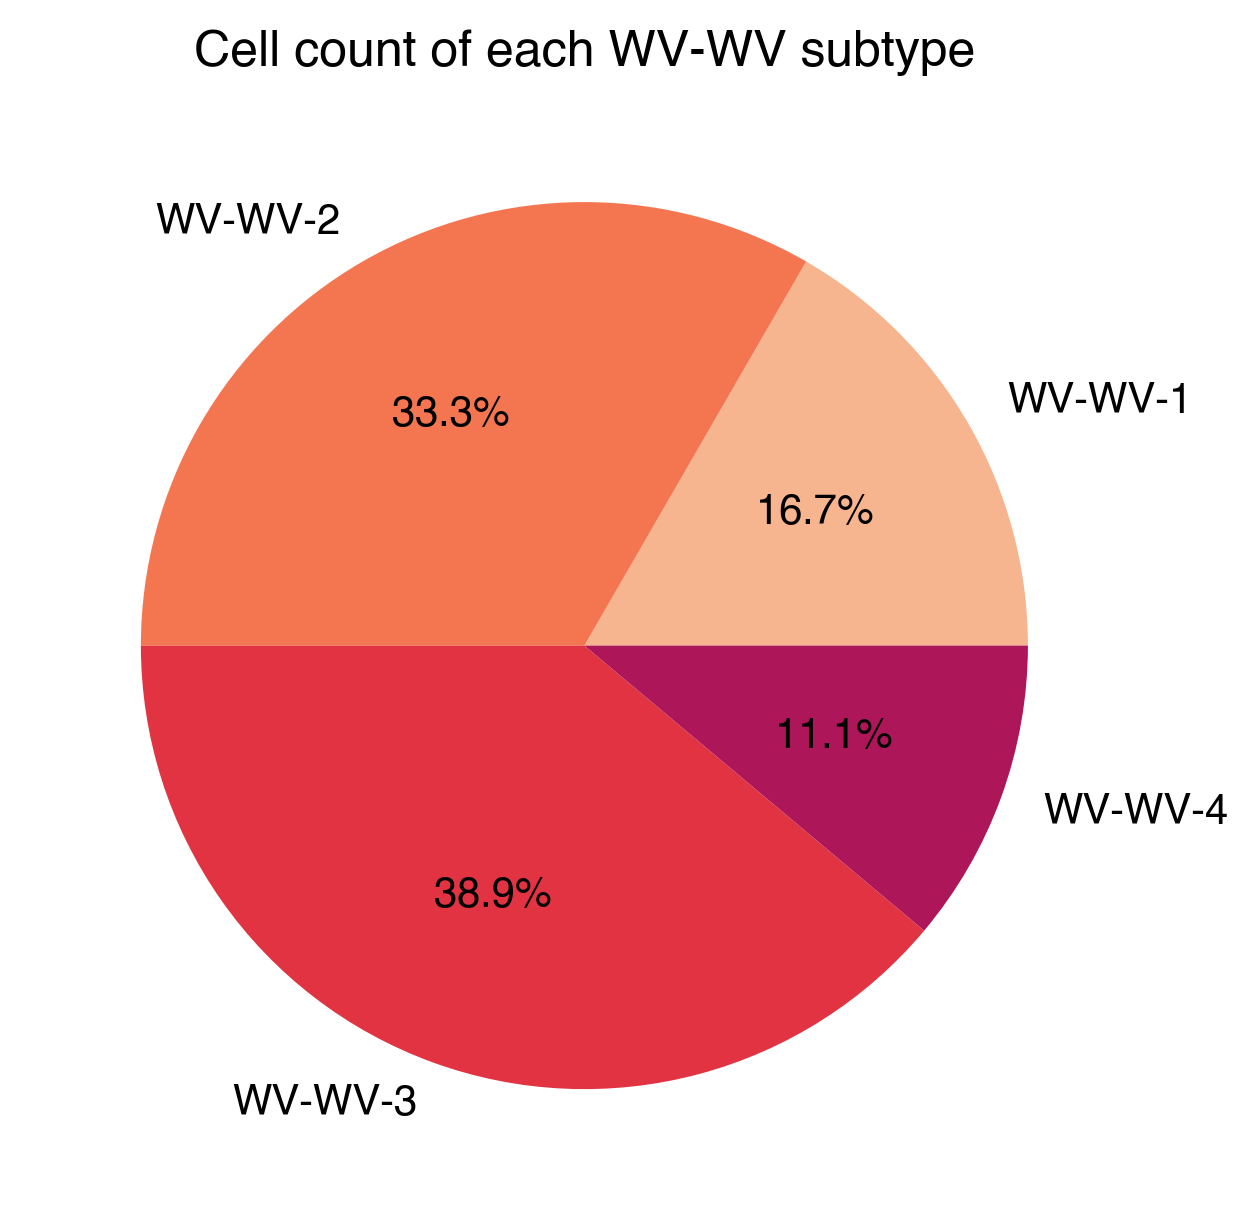

In [19]:
plt.pie(wvwv_cell_count['count'],
        labels=wvwv_cell_count['type'],
        autopct='%1.1f%%',
        colors = seaborn.color_palette('rocket_r'))
plt.title('Cell count of each WV-WV subtype')

## Average input and output strength

What is the average input synapse count for wv-wvs as a group? What is the average output synapse count?

In [21]:
display(wvwv_inputs, wvwv_outputs)

pre_root_id        post_root_id  syn_count nt_type  type_pre  \
2141     720575940622996579  720575940627201579        252    GLUT     DNg40   
2741     720575940626901136  720575940627201579        236    GLUT     DNg40   
4618     720575940624750480  720575940635330204        203    GABA     DNg24   
5100     720575940605214636  720575940621717469        196    GABA   WV-WV-3   
5116     720575940639118926  720575940605214636        196    GABA     DNg24   
...                     ...                 ...        ...     ...       ...   
3709886  720575940623292713  720575940634571383          5    GABA  SAD_pr02   
3715523  720575940623446860  720575940621717469          5     SER     DNg30   
3723221  720575940622998115  720575940622123981          5     ACH      JO-B   
3726672  720575940623197588  720575940603533246          5     ACH    CB2186   
3731348  720575940623189799  720575940622123981          5     ACH      JO-A   

        type_post pref_pre pref_post     class_pre class_post  
2141      WV-WV-3      NaN       NaN  non-auditory   auditory  
2741      WV-WV-3      NaN       NaN  non-auditory   auditory  
4618      WV-WV-1      NaN       NaN  non-auditory   auditory  
5100      WV-WV-3      NaN       NaN      auditory   auditory  
5116      WV-WV-3      NaN       NaN  non-auditory   auditory  
...           ...      ...       ...           ...        ...  
3709886   WV-WV-2     sine       NaN      auditory   auditory  
3715523   WV-WV-3      NaN       NaN  non-auditory   auditory  
3723221   WV-WV-1      NaN       NaN      auditory   auditory  
3726672   WV-WV-3      NaN       NaN  non-auditory   auditory  
3731348   WV-WV-1      NaN       NaN      auditory   auditory  

[2783 rows x 10 columns]

pre_root_id        post_root_id  syn_count nt_type type_pre  \
1300     720575940605214636  720575940624750480        295    GABA  WV-WV-3   
1512     720575940605214636  720575940639118926        280    GABA  WV-WV-3   
1629     720575940604201830  720575940622838154        273    GABA  WV-WV-3   
3847     720575940605214636  720575940619654053        215    GABA  WV-WV-3   
4577     720575940623322877  720575940630258003        203    GABA  WV-WV-1   
...                     ...                 ...        ...     ...      ...   
3711339  720575940623322877  720575940609825033          5    GABA  WV-WV-1   
3711369  720575940623322877  720575940608606933          5    GABA  WV-WV-1   
3711370  720575940623322877  720575940607957769          5    GABA  WV-WV-1   
3711371  720575940623322877  720575940607775106          5    GABA  WV-WV-1   
3711372  720575940623322877  720575940604653484          5    GABA  WV-WV-1   

        type_post pref_pre     pref_post class_pre    class_post  
1300        DNg24      NaN           NaN  auditory  non-auditory  
1512        DNg24      NaN           NaN  auditory  non-auditory  
1629        DNp01      NaN           NaN  auditory      auditory  
3847        DNp02      NaN           NaN  auditory  non-auditory  
4577     WED_pr02      NaN  intermediate  auditory      auditory  
...           ...      ...           ...       ...           ...  
3711339    CB1192      NaN           NaN  auditory  non-auditory  
3711369    WED056      NaN           NaN  auditory  non-auditory  
3711370    CB2144      NaN           NaN  auditory  non-auditory  
3711371    CB2858      NaN           NaN  auditory  non-auditory  
3711372    CB0466      NaN           NaN  auditory  non-auditory  

[2585 rows x 10 columns]

In [22]:
#since values are still really low make new df excluding syn counts below 5

threshold = 5

wvwv_preconns_threshold = wvwv_outputs[wvwv_outputs['syn_count']>=threshold]
wvwv_postconns_threshold = wvwv_inputs[wvwv_inputs['syn_count']>=threshold]

wvwv_outputavg = np.mean(wvwv_preconns_threshold['syn_count'])
wvwv_inputavg = np.mean(wvwv_postconns_threshold['syn_count'])

print(wvwv_outputavg, wvwv_inputavg) #slightly higher than before



20.595357833655704 20.393100970176068


In [23]:
#without threshold value is lower

print(np.mean(wvwv_outputs['syn_count']))
print(np.mean(wvwv_inputs['syn_count']))

20.595357833655704
20.393100970176068


In [24]:
#finding the average manually

pre_avg = np.sum(wvwv_outputs['syn_count'])/len(wvwv_outputs['syn_count'])
post_avg = np.sum(wvwv_inputs['syn_count'])/len(wvwv_inputs['syn_count'])

print(pre_avg, post_avg)

#values are still the same, so safe to say this is the average syn count


20.595357833655704 20.393100970176068


## Pre and postsynaptic connections for all WV-WV types

What are the top inputs and outputs of WV-WVs as a group?

### Top 10 inputs and outputs by cell type (of WV-WVs as a group)

In [25]:
#finding top 10 cells that wv-wv cells send outputs to
wvwv_top_outputs = wvwv_outputs.groupby(['type_pre', 'type_post'], as_index=False)[['syn_count']].sum().sort_values(by='syn_count', ascending=False) #group by cell type, then sort in descending order
wvwv_top10outputs = wvwv_top_outputs.head(10)
wvwv_top10outputs

type_pre  type_post  syn_count
164  WV-WV-1    WED-VLP       3189
321  WV-WV-2   WED_pr02       2243
179  WV-WV-1   WED_pr02       2011
326  WV-WV-3    AMMC-A1       1381
412  WV-WV-3      DNp01       1372
413  WV-WV-3      DNp02       1136
240  WV-WV-2     CB1760       1101
243  WV-WV-2     CB1948       1044
31   WV-WV-1  AVLP_pr01        965
443  WV-WV-3    WV-WV-3        931

In [26]:
#pivot table
wvwv_top10_outputs_matrix = wvwv_top10outputs.pivot_table(
    values='syn_count',
    index='type_post',
    columns='type_pre',
    aggfunc = 'sum',
    dropna = False
)
wvwv_top10_outputs_matrix


type_pre   WV-WV-1  WV-WV-2  WV-WV-3
type_post                           
AMMC-A1        NaN      NaN   1381.0
AVLP_pr01    965.0      NaN      NaN
CB1760         NaN   1101.0      NaN
CB1948         NaN   1044.0      NaN
DNp01          NaN      NaN   1372.0
DNp02          NaN      NaN   1136.0
WED-VLP     3189.0      NaN      NaN
WED_pr02    2011.0   2243.0      NaN
WV-WV-3        NaN      NaN    931.0

Text(101.66666666666666, 0.5, 'presynaptic WV-WV cells')

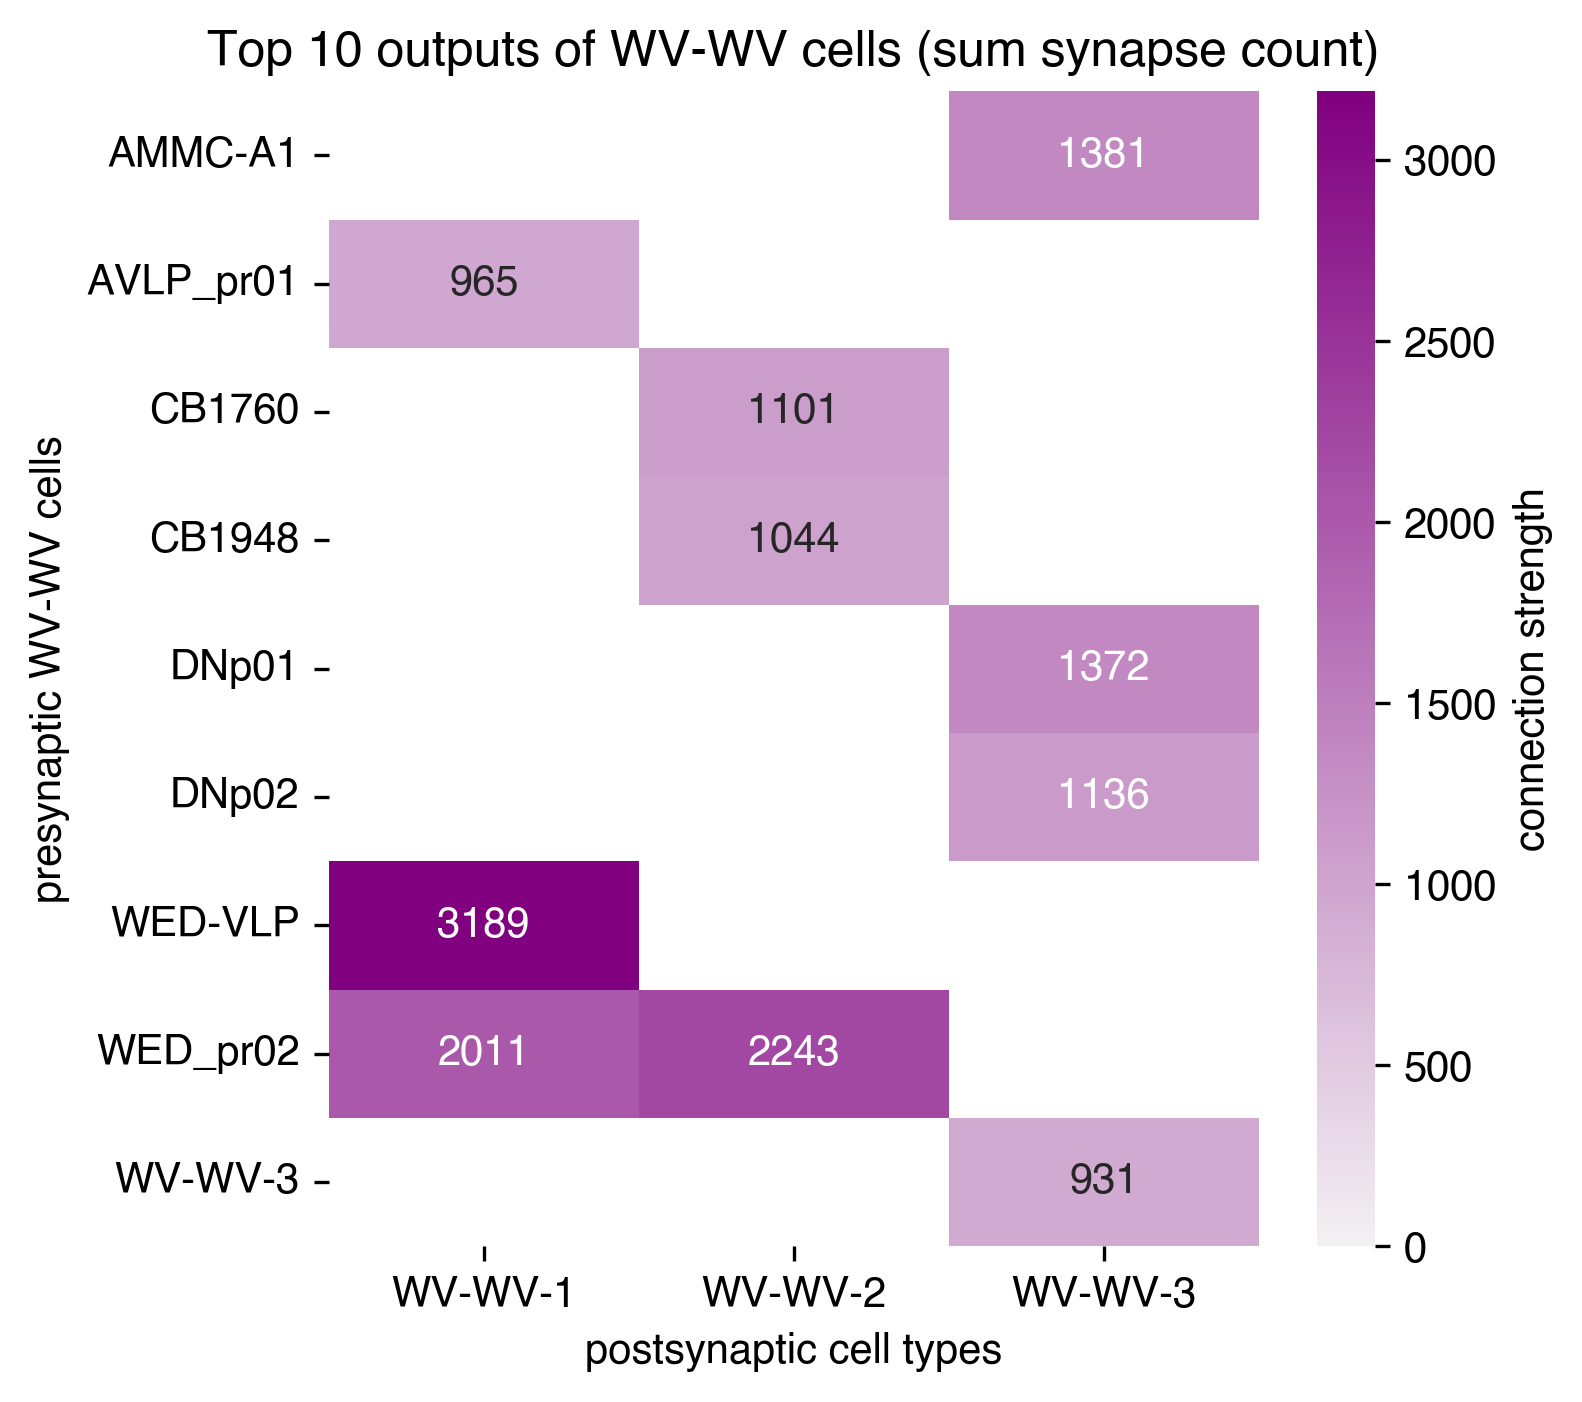

In [27]:
#turning into heatmap
fig = plt.figure(figsize=(5, 5))
seaborn.heatmap(wvwv_top10_outputs_matrix, vmin=0, 
                annot=True,
                cmap=seaborn.light_palette('purple', as_cmap=True), 
                cbar_kws={'label': 'connection strength'},
                fmt = 'g')
plt.title('Top 10 outputs of WV-WV cells (sum synapse count)')
plt.xlabel('postsynaptic cell types')
plt.ylabel('presynaptic WV-WV cells')

In [28]:
#follow the same method as above but for inputs this time
wvwv_top_inputs = wvwv_inputs.groupby(['type_pre', 'type_post'], as_index=False)[['syn_count']].sum().sort_values(by='syn_count', ascending=False)
wvwv_top10inputs = wvwv_top_inputs.head(10)
wvwv_top10inputs

type_pre type_post  syn_count
113        B1   WV-WV-2       5601
112        B1   WV-WV-1       5594
347      JO-A   WV-WV-3       3485
345      JO-A   WV-WV-1       2990
114        B1   WV-WV-3       2669
423  WED_pr02   WV-WV-2       1182
301     DNg40   WV-WV-3       1130
435   WV-WV-3   WV-WV-3        931
422  WED_pr02   WV-WV-1        895
223    CB1948   WV-WV-3        854

In [29]:
wvwv_top10_inputs_matrix = wvwv_top10inputs.pivot_table(
    values='syn_count',
    index='type_pre',
    columns='type_post',
    aggfunc='sum',
    dropna=False
)
wvwv_top10_inputs_matrix

type_post  WV-WV-1  WV-WV-2  WV-WV-3
type_pre                            
B1          5594.0   5601.0   2669.0
CB1948         NaN      NaN    854.0
DNg40          NaN      NaN   1130.0
JO-A        2990.0      NaN   3485.0
WED_pr02     895.0   1182.0      NaN
WV-WV-3        NaN      NaN    931.0

Text(101.66666666666666, 0.5, 'presynaptic cell types')

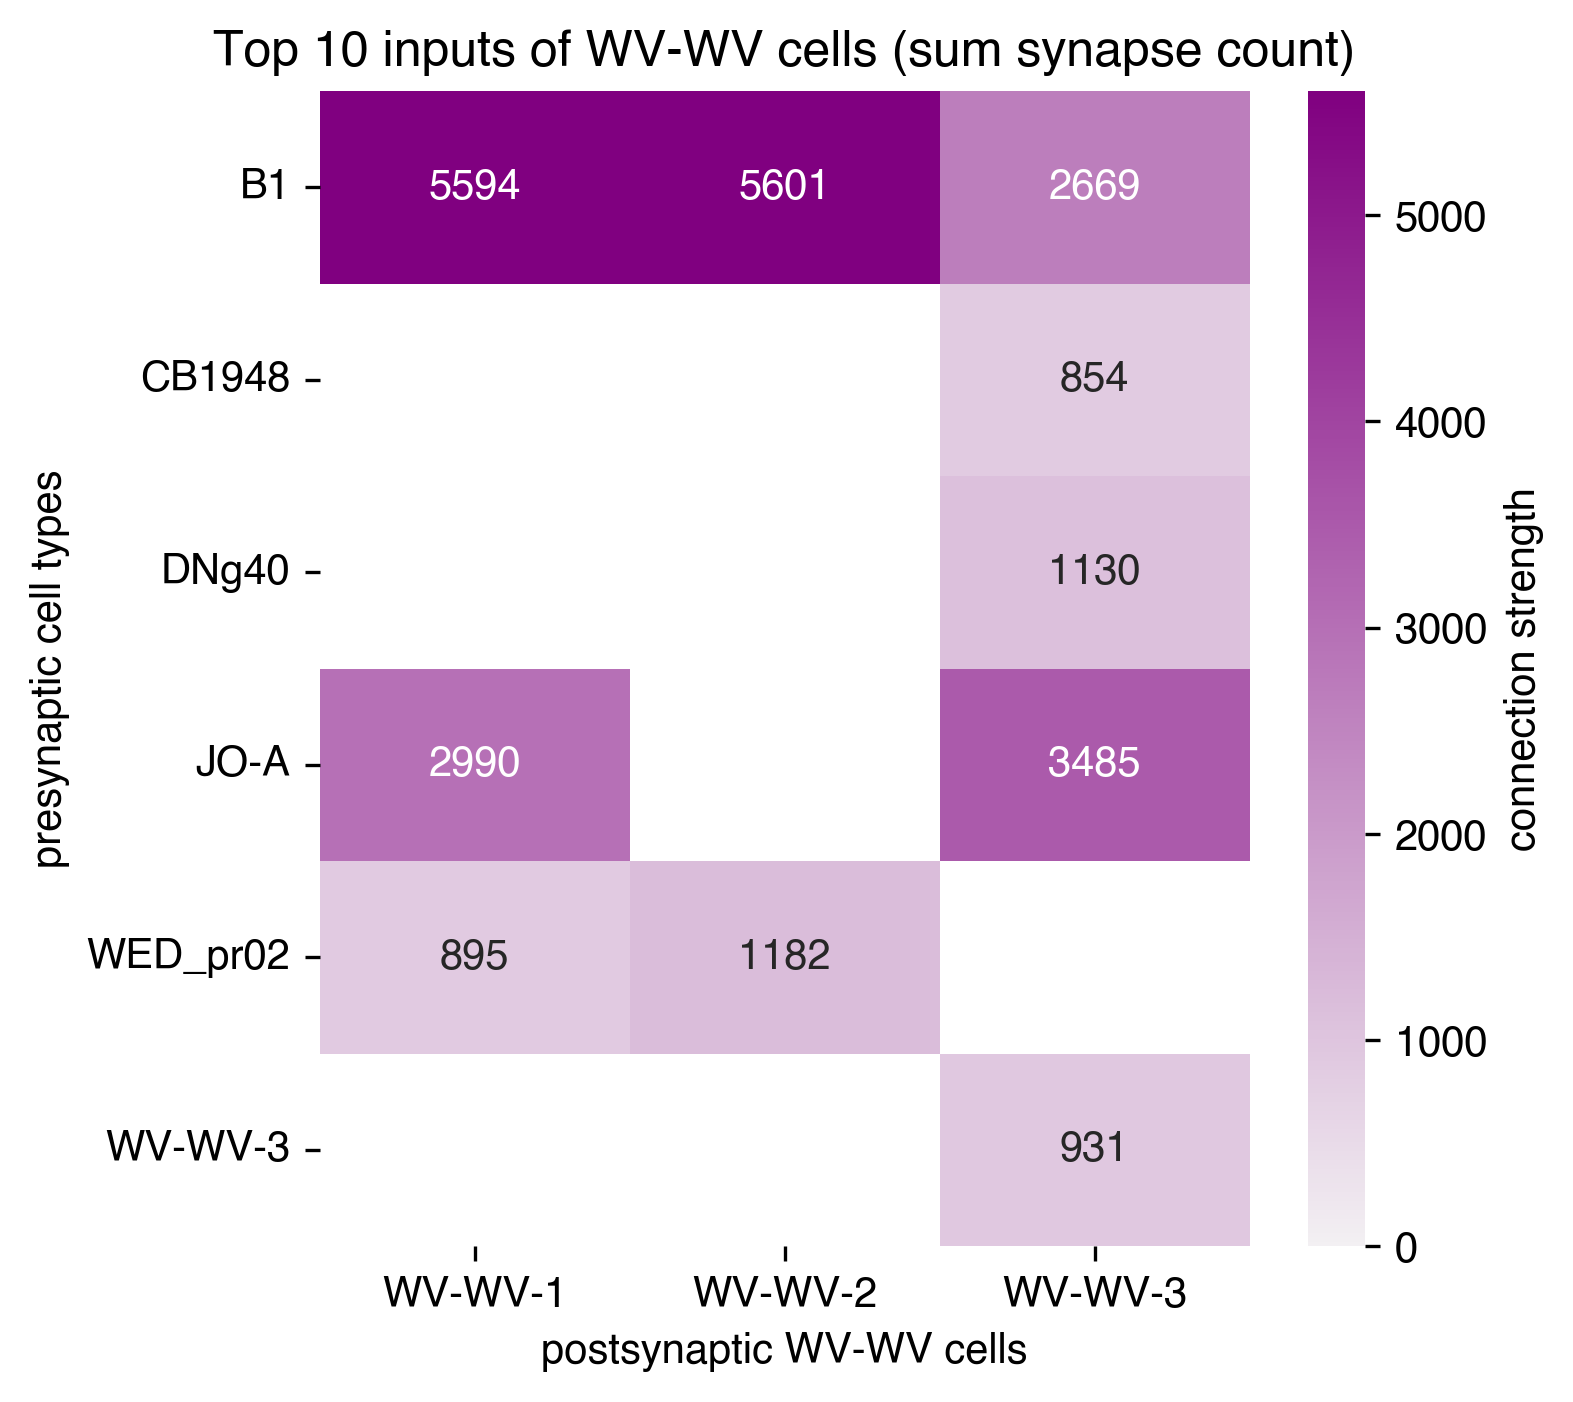

In [30]:
fig = plt.figure(figsize=(5, 5))
seaborn.heatmap(wvwv_top10_inputs_matrix, vmin=0, 
                annot=True, 
                cmap=seaborn.light_palette('purple', as_cmap=True), 
                cbar_kws={'label': 'connection strength'},
                fmt = 'g')
plt.title('Top 10 inputs of WV-WV cells (sum synapse count)')
plt.xlabel('postsynaptic WV-WV cells')
plt.ylabel('presynaptic cell types')

### Song mode preferences of inputs and outputs (average synapse count)

What are the song mode preferences of WV-WV inputs and outputs?

In [31]:
#outputs by song mode preference, synapse count is averaged (not summed)
wvwv_outputs_prefs = wvwv_outputs.pivot_table(
    values = 'syn_count',
    index = 'pref_post', #preference of output cell
    columns = 'type_pre', #wv-wv cell type
    dropna = False #include outputs with no recorded song mode preference
)
wvwv_outputs_prefs

type_pre        WV-WV-1    WV-WV-2    WV-WV-3    WV-WV-4
pref_post                                               
intermediate  38.141844  30.855263  18.400000   9.600000
pulse          8.857143   7.666667  15.621622  33.428571
sine          48.476190   8.000000  15.500000  10.222222
NaN           18.949527  17.892078  23.684303  12.272727

Text(139.16666666666666, 0.5, 'postsynaptic cell types')

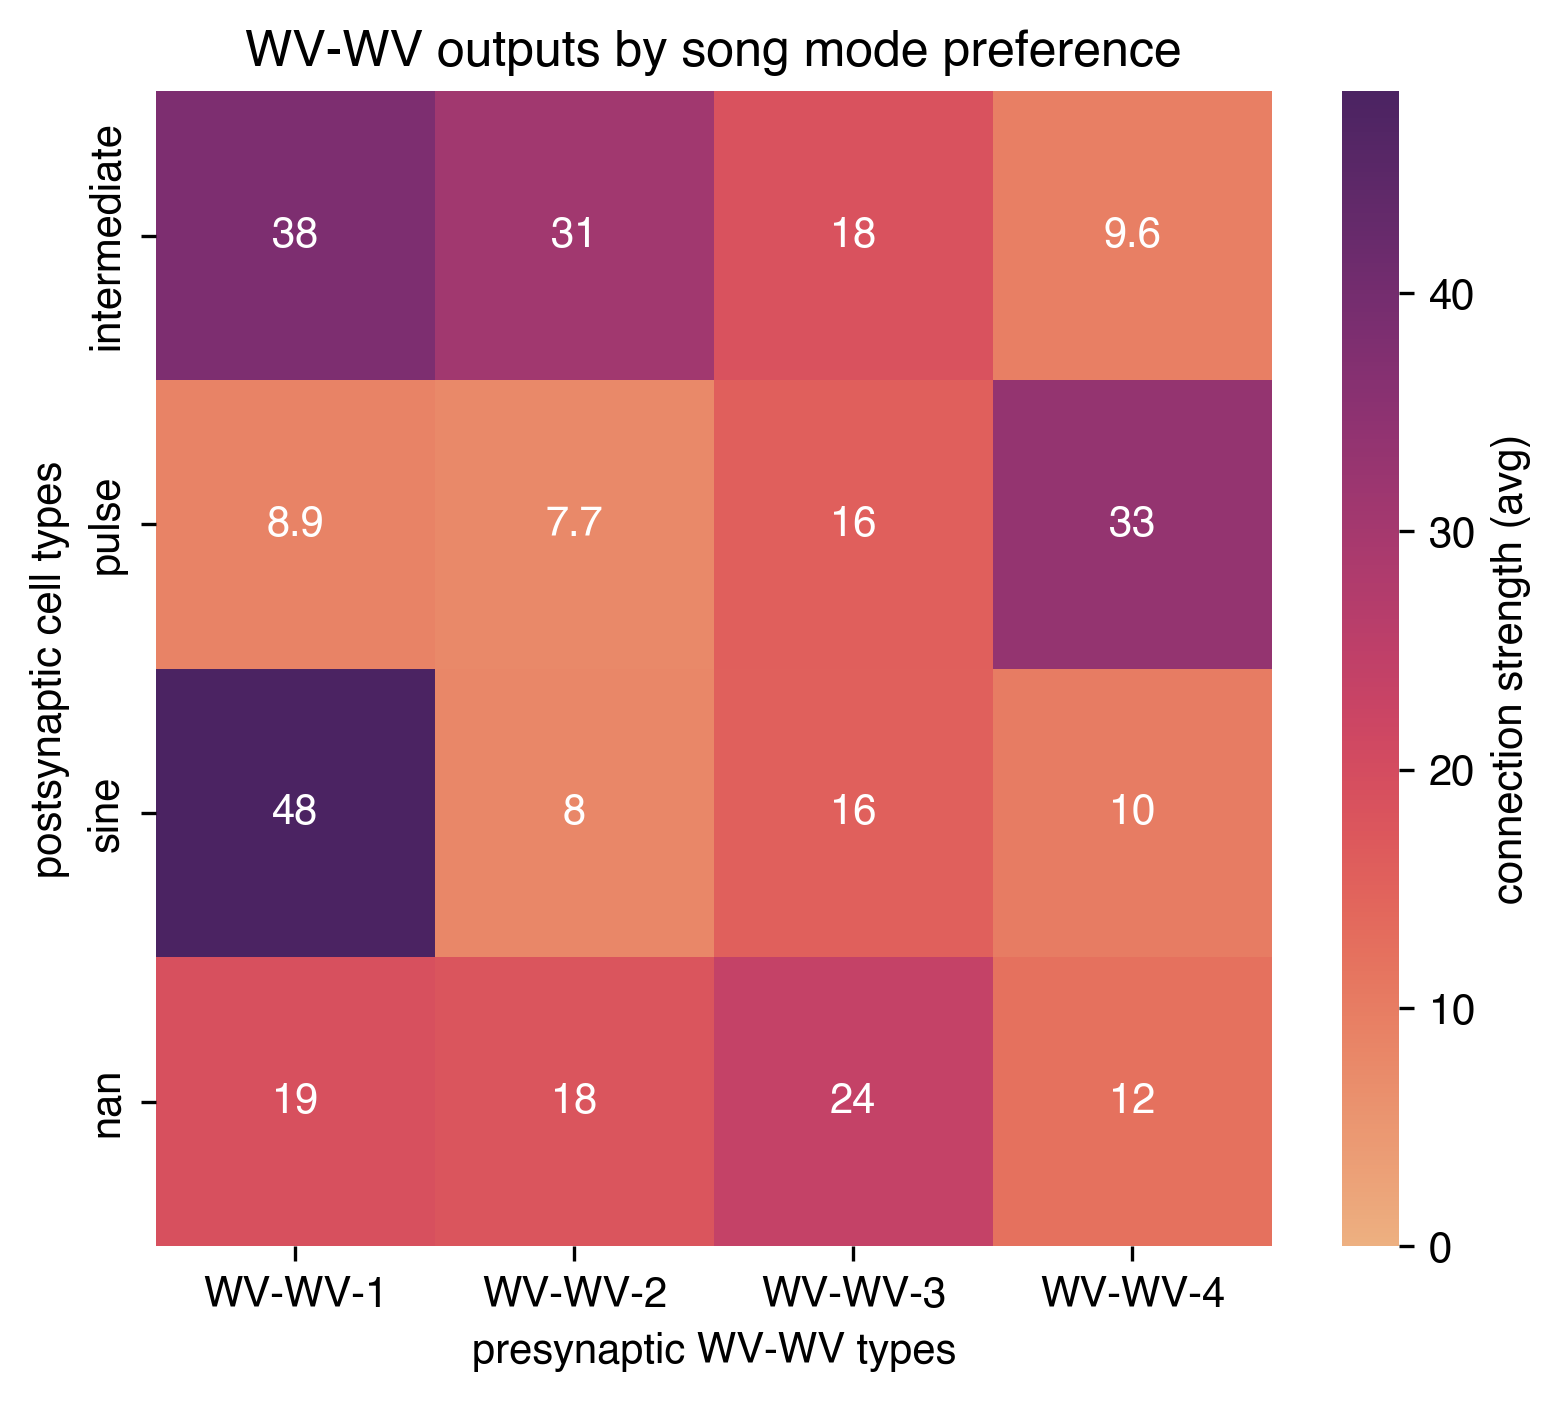

In [32]:
#plot
fig = plt.figure(figsize=(6, 5))
seaborn.heatmap(wvwv_outputs_prefs, vmin=0, 
                annot=True, 
                cmap=seaborn.color_palette('flare', as_cmap=True),
                cbar_kws={'label': 'connection strength (avg)'})
plt.title('WV-WV outputs by song mode preference')
plt.xlabel('presynaptic WV-WV types')
plt.ylabel('postsynaptic cell types')

In [33]:
#do the same thing for inputs
wvwv_inputs_prefs = wvwv_inputs.pivot_table(
    values = 'syn_count',
    index = 'pref_pre',
    columns = 'type_post',
    dropna = False
)
wvwv_inputs_prefs

type_post       WV-WV-1    WV-WV-2    WV-WV-3    WV-WV-4
pref_pre                                                
intermediate  20.347826  13.478261  14.846154  18.000000
pulse         58.572917  30.822581  23.771930  16.400000
sine          15.730769   9.428571  23.636364        NaN
NaN           21.103070  16.298387  18.621098  10.553719

Text(139.16666666666666, 0.5, 'presynaptic cell types')

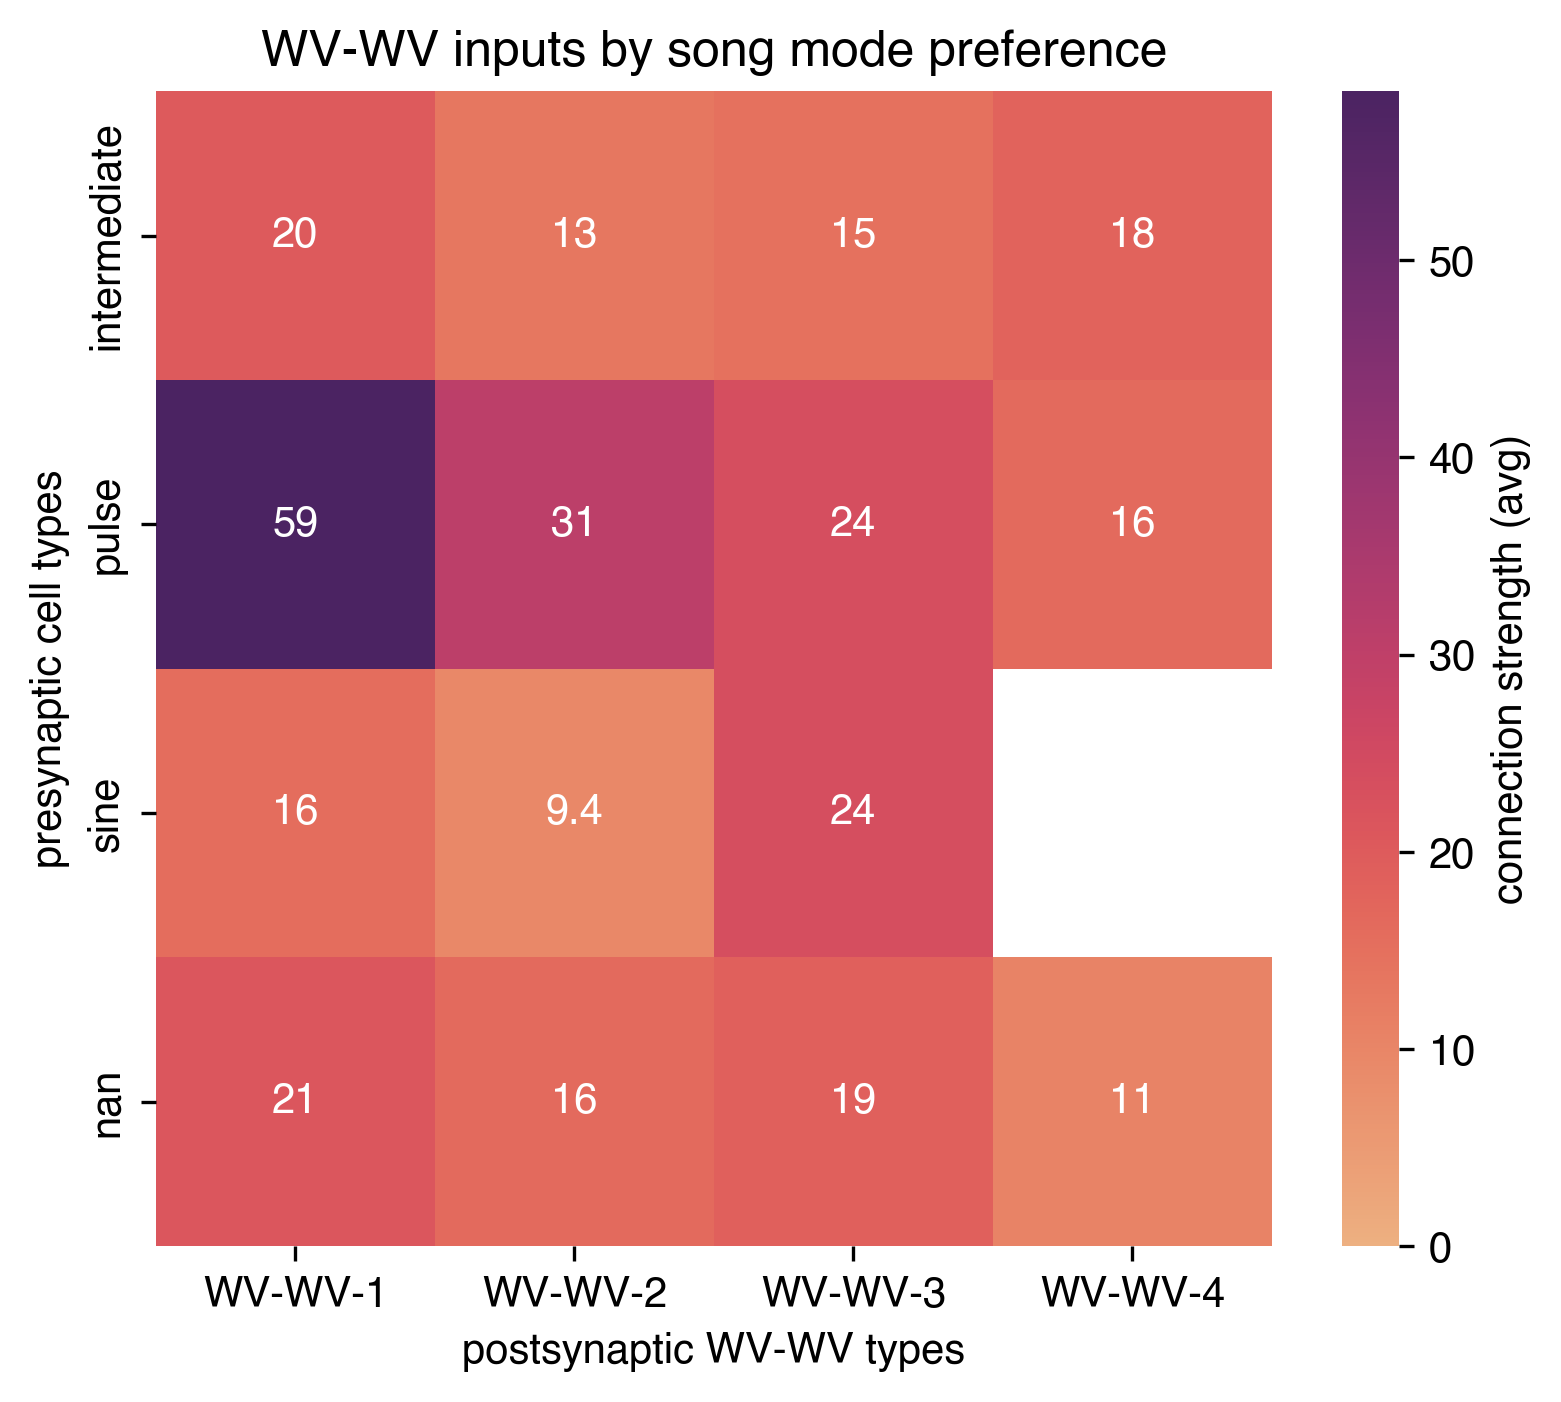

In [34]:
fig = plt.figure(figsize=(6, 5))
seaborn.heatmap(wvwv_inputs_prefs, vmin=0, 
                annot=True, 
                cmap=seaborn.color_palette('flare', as_cmap=True),
                cbar_kws={'label': 'connection strength (avg)'})
plt.title('WV-WV inputs by song mode preference')
plt.xlabel('postsynaptic WV-WV types')
plt.ylabel('presynaptic cell types')

### Song mode preferences (summed synapse count)

Instead of taking the average synapse count as the value, take the sum instead

In [35]:
wvwv_inputs_prefs_summed = wvwv_inputs_grouped.pivot_table(
    values = 'syn_count',
    index = 'pref_pre',
    columns = 'type_post',
    aggfunc = 'sum',
    dropna = False
)
wvwv_inputs_prefs_summed

type_post     WV-WV-1  WV-WV-2  WV-WV-3  WV-WV-4
pref_pre                                        
intermediate   1404.0   1240.0    193.0    306.0
pulse          5623.0   5733.0   2710.0    246.0
sine            409.0     66.0    520.0      NaN
NaN            9623.0  10105.0  17299.0   1277.0

Text(139.16666666666666, 0.5, 'presynaptic cell type mode preference')

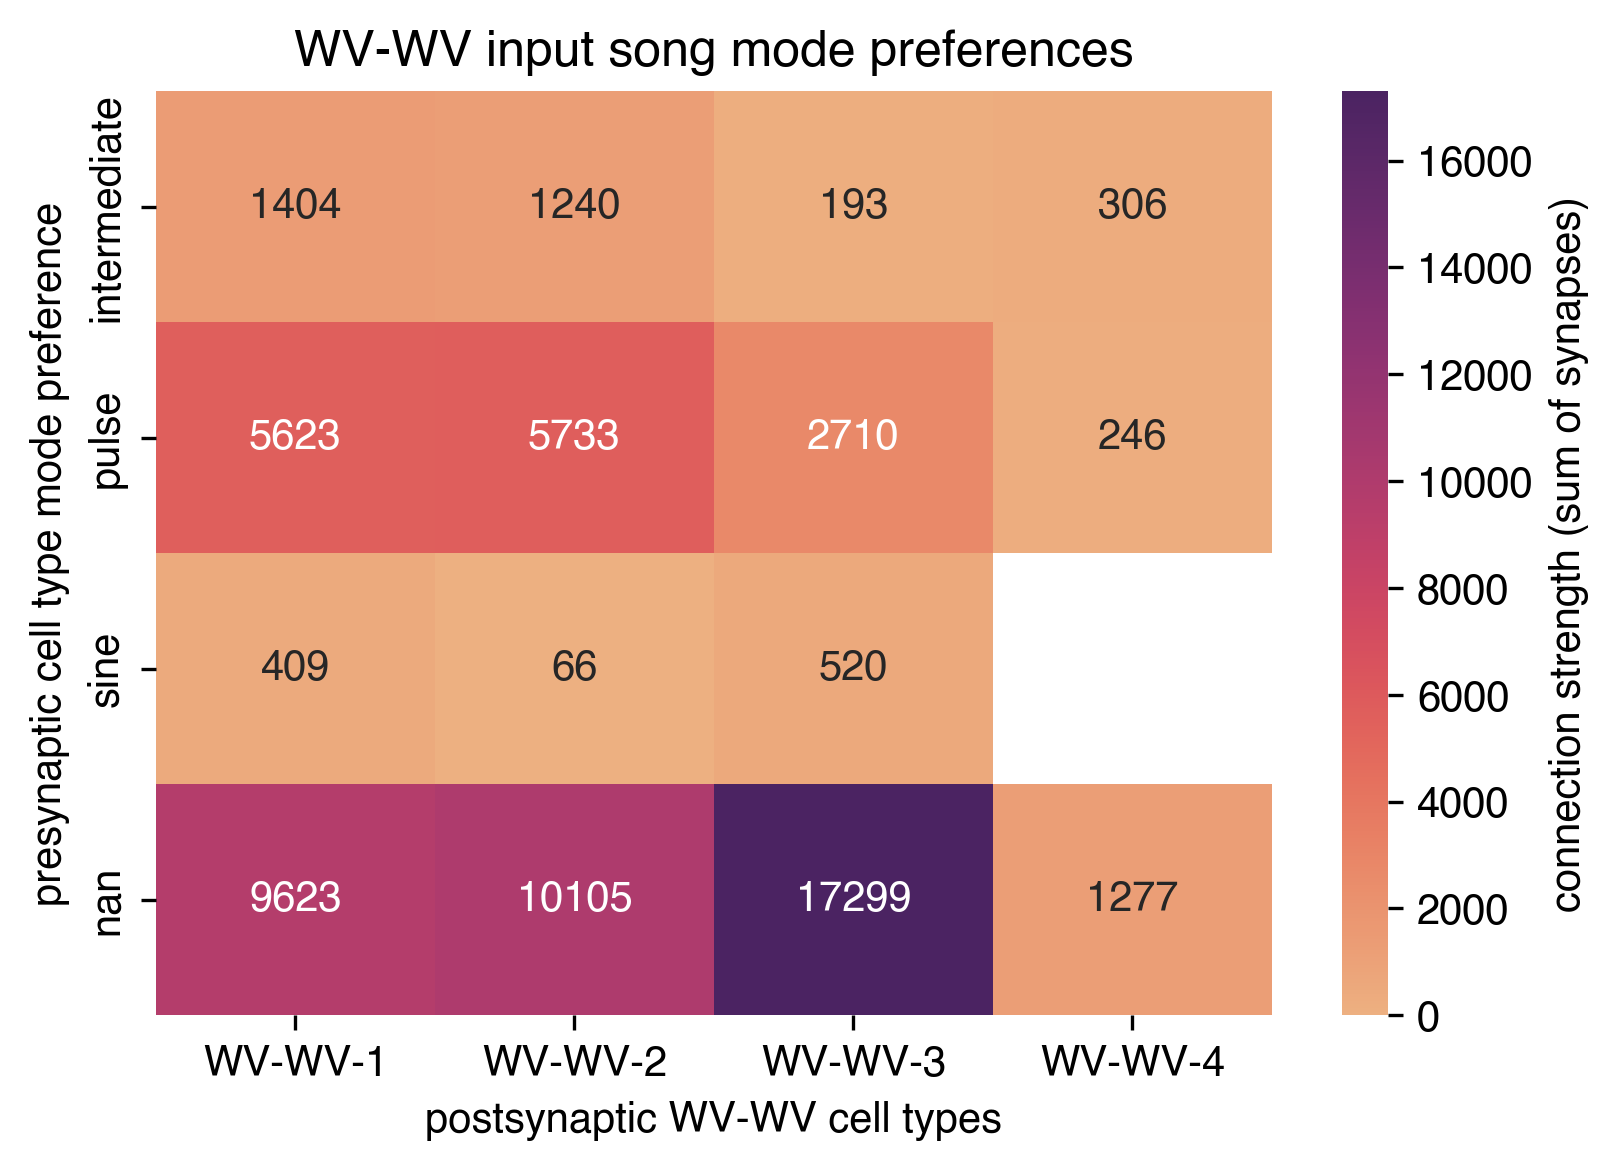

In [36]:

fig = plt.figure(figsize=(6, 4))
seaborn.heatmap(wvwv_inputs_prefs_summed, vmin=0, 
                annot=True, 
                cmap=seaborn.color_palette('flare', as_cmap=True),
                fmt = 'g',
                cbar_kws={'label': 'connection strength (sum of synapses)'},)
plt.title('WV-WV input song mode preferences')
plt.xlabel('postsynaptic WV-WV cell types')
plt.ylabel('presynaptic cell type mode preference')

In [37]:
wvwv_outputs_prefs_summed = wvwv_outputs_grouped.pivot_table(
    values = 'syn_count',
    index = 'pref_post',
    columns = 'type_pre',
    aggfunc = 'sum',
    dropna = False
)
wvwv_outputs_prefs_summed

type_pre      WV-WV-1  WV-WV-2  WV-WV-3  WV-WV-4
pref_post                                       
intermediate     5378     2345       92       48
pulse             186      115      578      234
sine             1018      112      124       92
NaN             12014    15584    13429     1890

Text(139.16666666666666, 0.5, 'postsynaptic cell type mode preference')

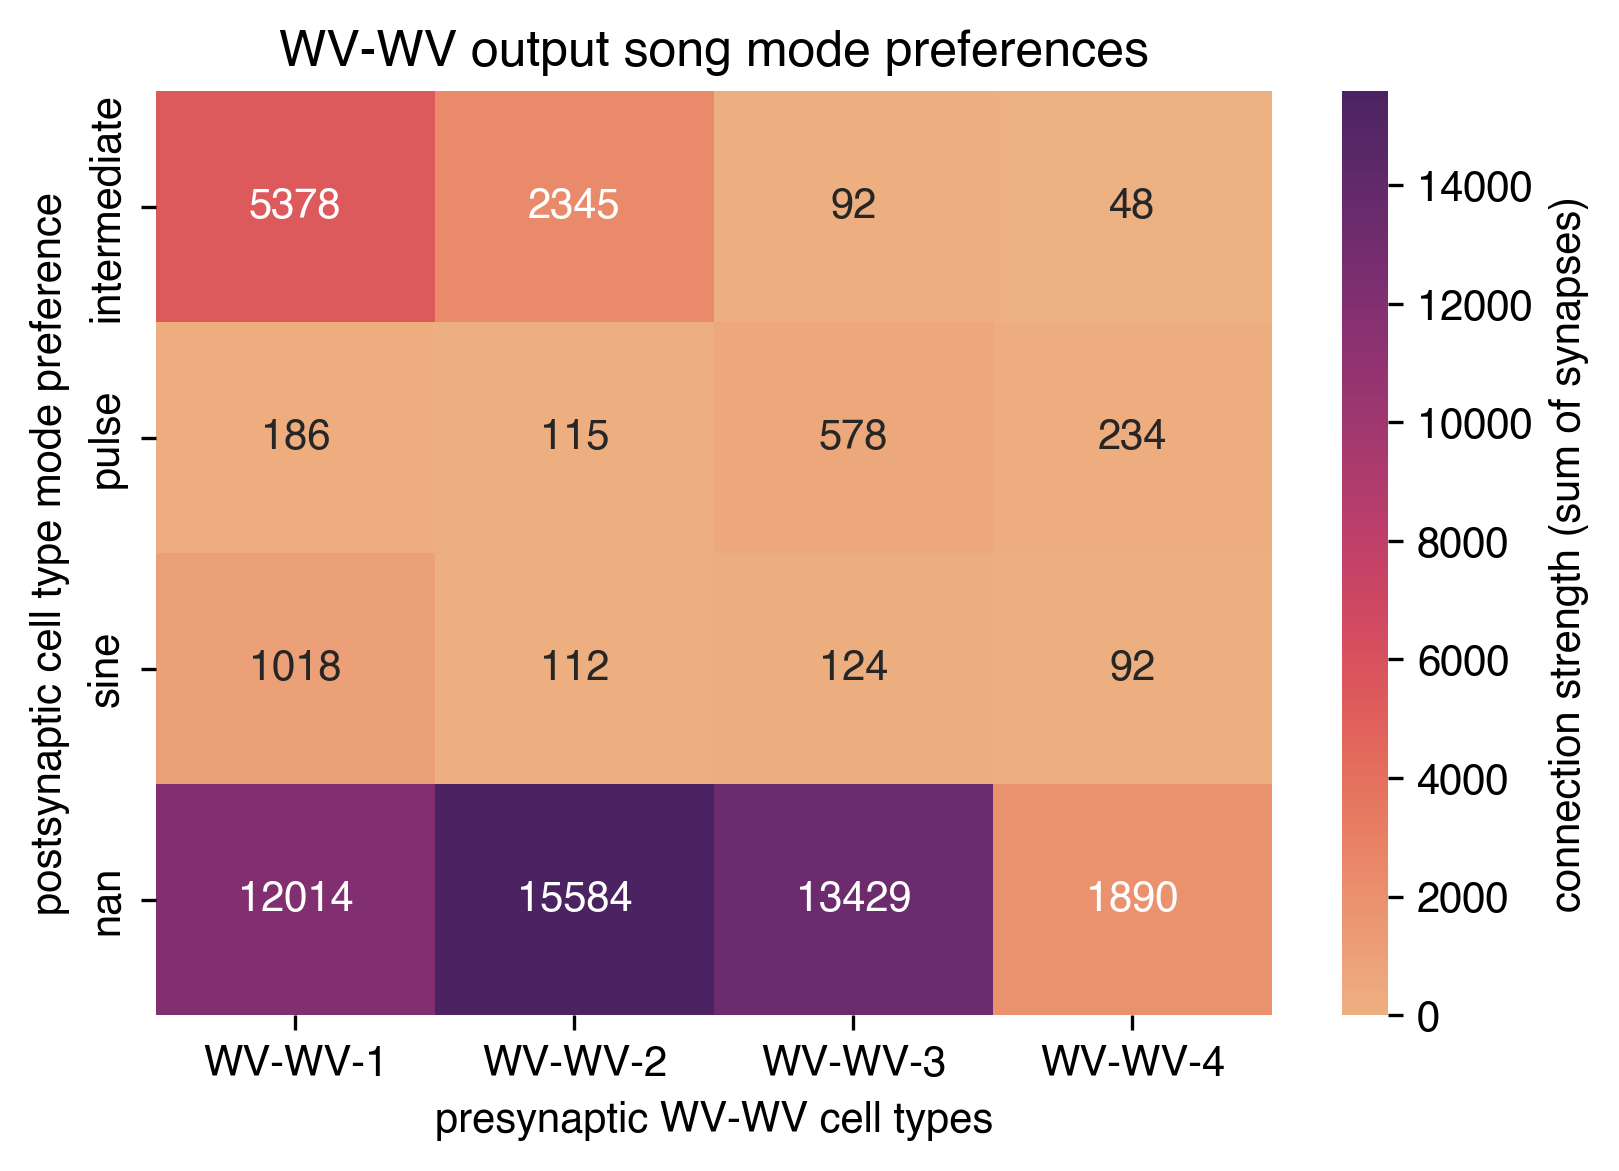

In [38]:
fig = plt.figure(figsize=(6, 4))
seaborn.heatmap(wvwv_outputs_prefs_summed, vmin=0, 
                annot=True, 
                cmap=seaborn.color_palette('flare', as_cmap=True),
                fmt = 'g',
                cbar_kws={'label': 'connection strength (sum of synapses)'},)
plt.title('WV-WV output song mode preferences')
plt.xlabel('presynaptic WV-WV cell types')
plt.ylabel('postsynaptic cell type mode preference')


### Inputs by neurotransmitter and song mode preference

In [39]:
#since all WV-WVs are GABAergic look at what kinds of inputs they are receiving

#inhibitory
GABAergic_wvwv_inputs = wvwv_inputs[wvwv_inputs['nt_type']=='GABA']
GABAergic_wvwv_inputs


pre_root_id        post_root_id  syn_count nt_type  \
4618     720575940624750480  720575940635330204        203    GABA   
5100     720575940605214636  720575940621717469        196    GABA   
5116     720575940639118926  720575940605214636        196    GABA   
5780     720575940644632087  720575940635330204        188    GABA   
6993     720575940624750480  720575940605214636        177    GABA   
...                     ...                 ...        ...     ...   
3666515  720575940624377224  720575940605095346          5    GABA   
3670415  720575940633123539  720575940621717469          5    GABA   
3675990  720575940632985261  720575940618342966          5    GABA   
3708685  720575940623295415  720575940621717469          5    GABA   
3709886  720575940623292713  720575940634571383          5    GABA   

            type_pre type_post pref_pre pref_post     class_pre class_post  
4618           DNg24   WV-WV-1      NaN       NaN  non-auditory   auditory  
5100         WV-WV-3   WV-WV-3      NaN       NaN      auditory   auditory  
5116           DNg24   WV-WV-3      NaN       NaN  non-auditory   auditory  
5780         AVLP083   WV-WV-1      NaN       NaN  non-auditory   auditory  
6993           DNg24   WV-WV-3      NaN       NaN  non-auditory   auditory  
...              ...       ...      ...       ...           ...        ...  
3666515      AVLP083   WV-WV-2      NaN       NaN  non-auditory   auditory  
3670415       SAD072   WV-WV-3      NaN       NaN  non-auditory   auditory  
3675990       CB0307   WV-WV-2      NaN       NaN  non-auditory   auditory  
3708685  AN_multi_19   WV-WV-3      NaN       NaN  non-auditory   auditory  
3709886     SAD_pr02   WV-WV-2     sine       NaN      auditory   auditory  

[1003 rows x 10 columns]

In [40]:
GABAergic_wvwv_inputs_matrix = GABAergic_wvwv_inputs.pivot_table(
    values = 'syn_count',
    index = 'pref_pre',
    columns = 'type_post',
    dropna = False,
    aggfunc = 'sum' #take the sum of synapses rather than the average
)
GABAergic_wvwv_inputs_matrix

type_post     WV-WV-1  WV-WV-2  WV-WV-3  WV-WV-4
pref_pre                                        
intermediate    895.0   1182.0     98.0    301.0
sine            409.0     66.0    520.0      NaN
NaN            4351.0   5403.0   6827.0    289.0

In [41]:
#excitatory
ACH_wvwv_inputs = wvwv_inputs[wvwv_inputs['nt_type'] == 'ACH']
ACH_wvwv_inputs

pre_root_id        post_root_id  syn_count nt_type  \
7415     720575940646521198  720575940635330204        173     ACH   
10357    720575940622254375  720575940623322877        154     ACH   
10924    720575940627263375  720575940632945177        151     ACH   
11707    720575940622097959  720575940623322877        147     ACH   
12090    720575940607188036  720575940623322877        145     ACH   
...                     ...                 ...        ...     ...   
3699630  720575940622577336  720575940620835327          5     ACH   
3701163  720575940634525792  720575940605095346          5     ACH   
3723221  720575940622998115  720575940622123981          5     ACH   
3726672  720575940623197588  720575940603533246          5     ACH   
3731348  720575940623189799  720575940622123981          5     ACH   

            type_pre type_post pref_pre pref_post     class_pre class_post  
7415          CB0591   WV-WV-1      NaN       NaN  non-auditory   auditory  
10357             B1   WV-WV-1    pulse       NaN      auditory   auditory  
10924             B1   WV-WV-3    pulse       NaN      auditory   auditory  
11707             B1   WV-WV-1    pulse       NaN      auditory   auditory  
12090             B1   WV-WV-1    pulse       NaN      auditory   auditory  
...              ...       ...      ...       ...           ...        ...  
3699630           B1   WV-WV-2    pulse       NaN      auditory   auditory  
3701163  AN_multi_88   WV-WV-2      NaN       NaN  non-auditory   auditory  
3723221         JO-B   WV-WV-1      NaN       NaN      auditory   auditory  
3726672       CB2186   WV-WV-3      NaN       NaN  non-auditory   auditory  
3731348         JO-A   WV-WV-1      NaN       NaN      auditory   auditory  

[1611 rows x 10 columns]

In [42]:
ACH_wvwv_inputs_matrix = ACH_wvwv_inputs.pivot_table(
    values = 'syn_count',
    index = 'pref_pre',
    columns = 'type_post',
    dropna = False,
    aggfunc = 'sum'
)
ACH_wvwv_inputs_matrix

type_post     WV-WV-1  WV-WV-2  WV-WV-3  WV-WV-4
pref_pre                                        
intermediate      509       31       61        5
pulse            5623     5733     2710      246
NaN              4696     4367     8142      958

Text(139.16666666666666, 0.5, 'presynaptic (GABAergic) cell mode preference')

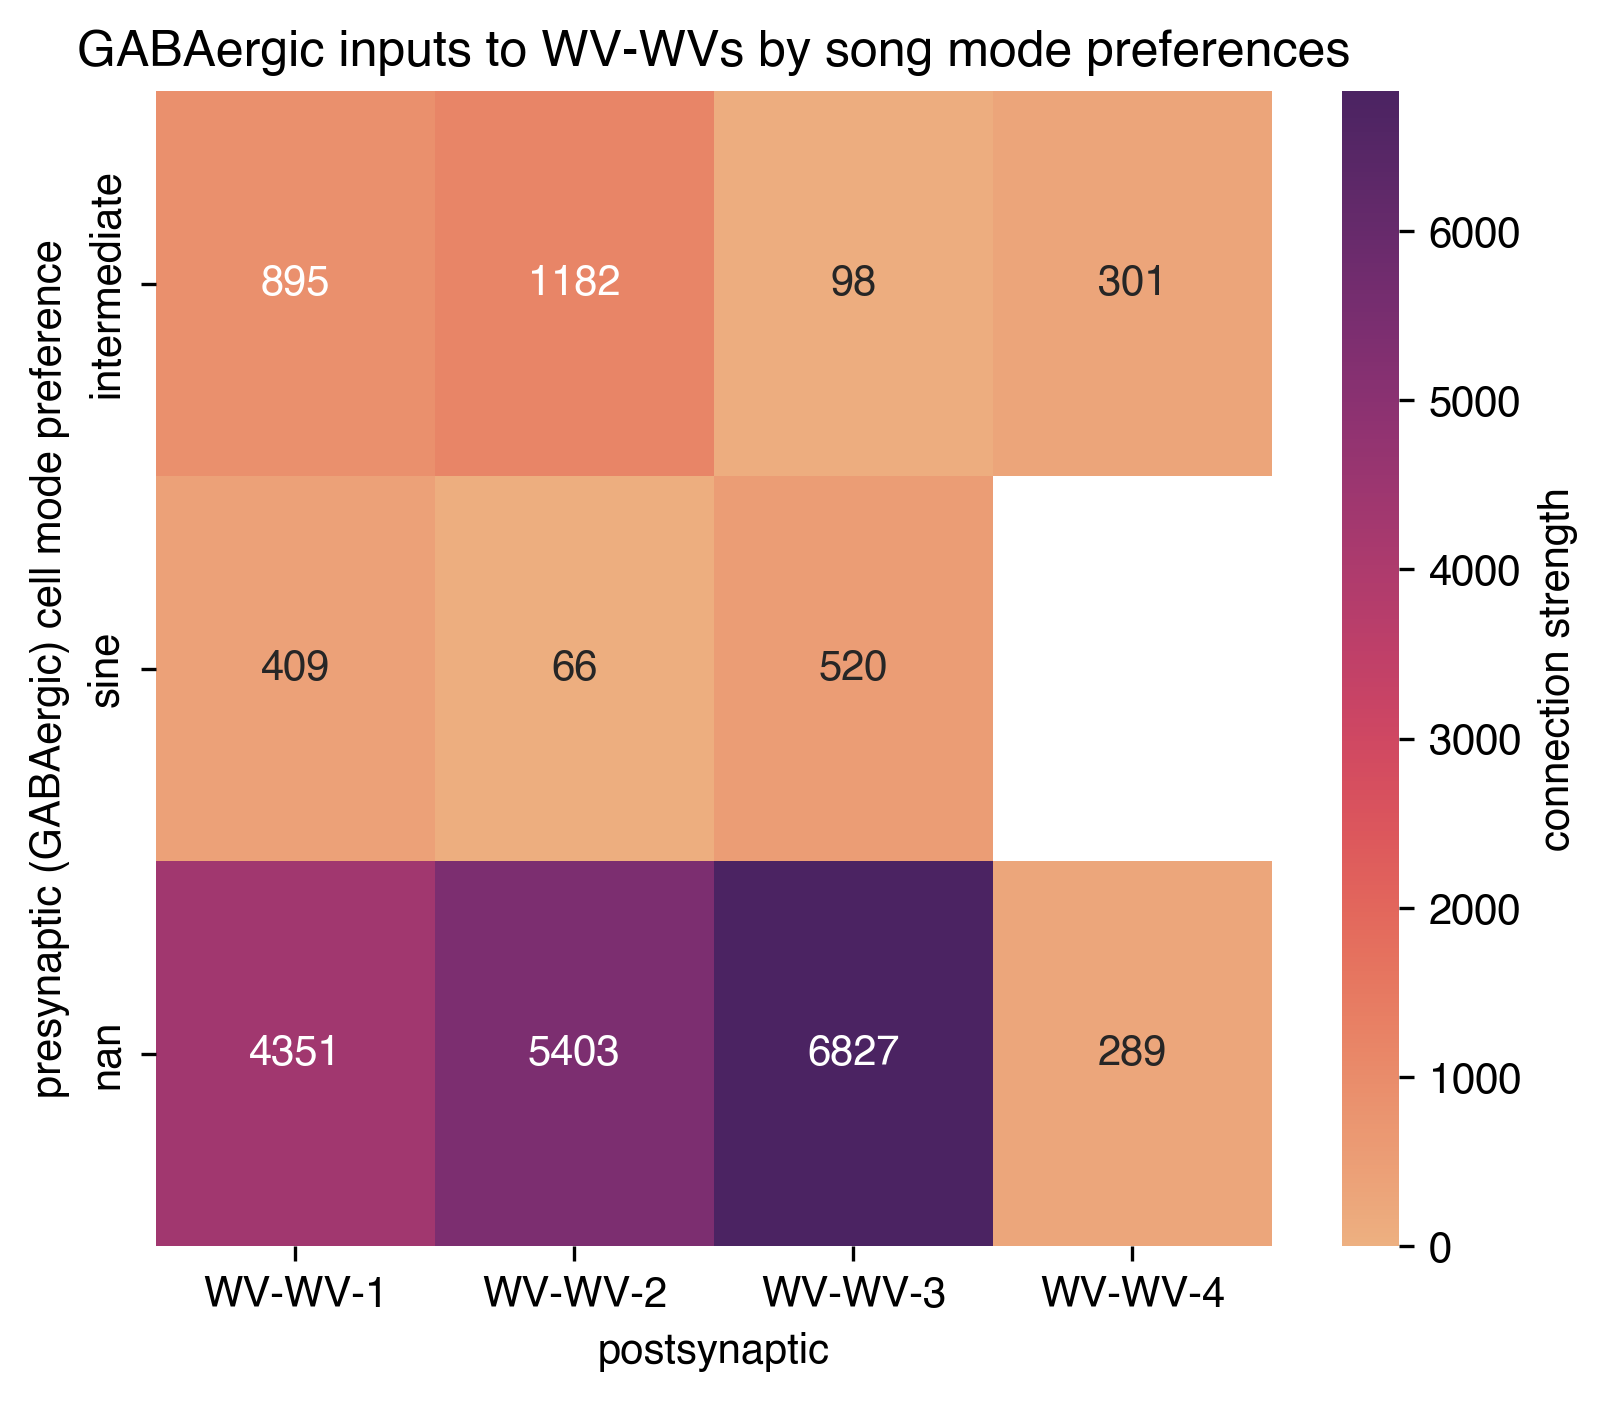

In [43]:
#plot both 

fig = plt.figure(figsize=(6, 5))
seaborn.heatmap(GABAergic_wvwv_inputs_matrix, vmin=0, 
                annot=True, 
                cmap=seaborn.color_palette('flare', as_cmap=True), 
                cbar_kws={'label': 'connection strength'},
                fmt='g')
plt.title('GABAergic inputs to WV-WVs by song mode preferences')
plt.xlabel('postsynaptic')
plt.ylabel('presynaptic (GABAergic) cell mode preference')

Text(139.16666666666666, 0.5, 'presynaptic (cholinergic) mode preference')

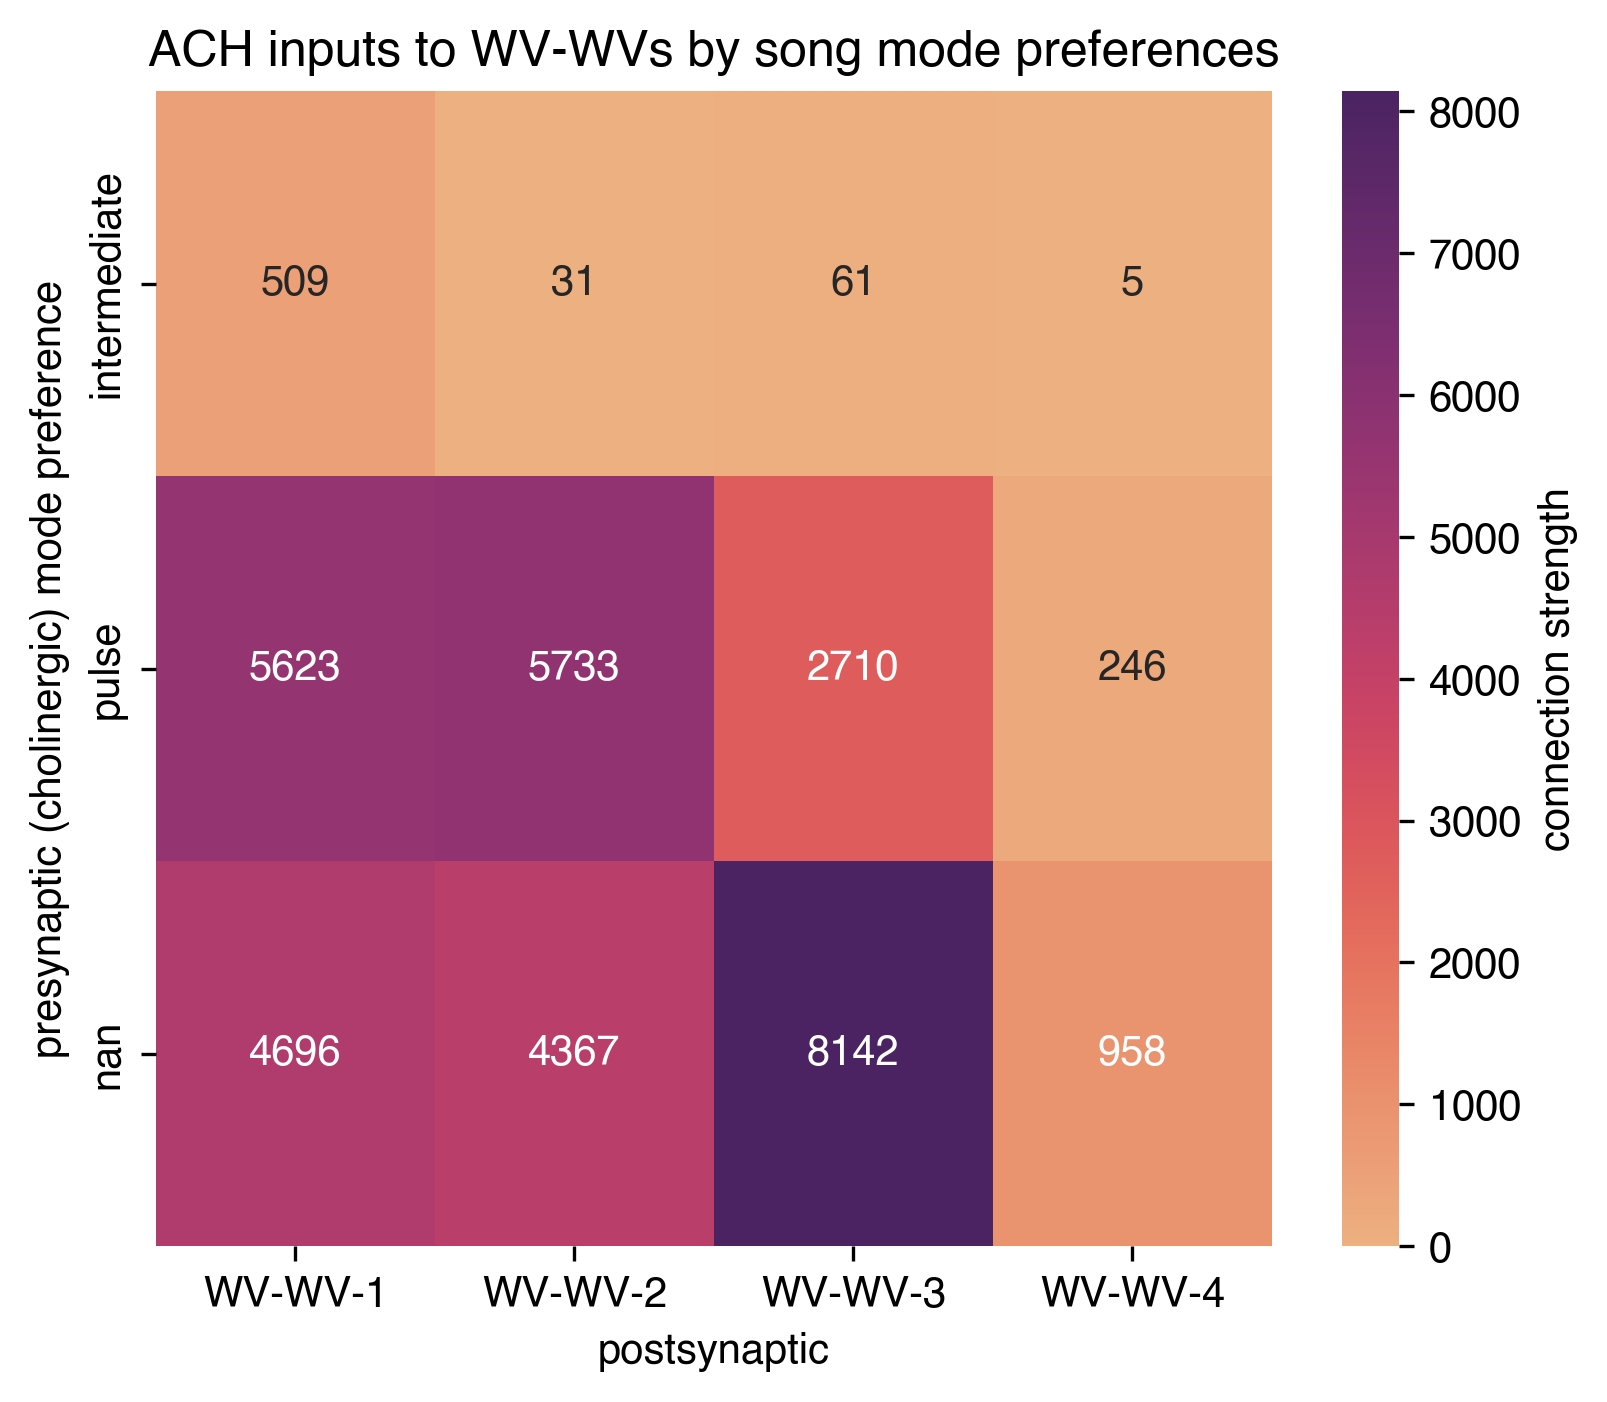

In [44]:
fig = plt.figure(figsize=(6, 5))
seaborn.heatmap(ACH_wvwv_inputs_matrix, vmin=0, 
                annot=True, 
                cmap=seaborn.color_palette('flare', as_cmap=True), 
                cbar_kws={'label': 'connection strength'},
                fmt='g')
plt.title('ACH inputs to WV-WVs by song mode preferences')
plt.xlabel('postsynaptic')
plt.ylabel('presynaptic (cholinergic) mode preference')

### WV-WV cell types to other WV-WV cell types

Do the WV-WVs send projections to each other? If so, how strong are these connections?

In [45]:
#merging above two tables so that both types should be wv-wv cells
wvwv_to_wvwv = conns_types[(conns_types['pre_root_id'].isin(wvwv_rootids)) & (conns_types['post_root_id'].isin(wvwv_rootids))]
wvwv_to_wvwv.head(10)

pre_root_id        post_root_id  syn_count nt_type type_pre  \
5100   720575940605214636  720575940621717469        196    GABA  WV-WV-3   
11957  720575940625345328  720575940605214636        146    GABA  WV-WV-2   
15606  720575940622123981  720575940623322877        132    GABA  WV-WV-1   
31592  720575940605214636  720575940625345328         95    GABA  WV-WV-3   
38201  720575940605214636  720575940603533246         86    GABA  WV-WV-3   
38235  720575940625345328  720575940618342966         86    GABA  WV-WV-2   
40995  720575940625345328  720575940621148660         83    GABA  WV-WV-2   
44160  720575940634571383  720575940621148660         80    GABA  WV-WV-2   
46562  720575940632945177  720575940604201830         77    GABA  WV-WV-3   
71664  720575940622123981  720575940639811469         62    GABA  WV-WV-1   

      type_post pref_pre pref_post class_pre class_post  
5100    WV-WV-3      NaN       NaN  auditory   auditory  
11957   WV-WV-3      NaN       NaN  auditory   auditory  
15606   WV-WV-1      NaN       NaN  auditory   auditory  
31592   WV-WV-2      NaN       NaN  auditory   auditory  
38201   WV-WV-3      NaN       NaN  auditory   auditory  
38235   WV-WV-2      NaN       NaN  auditory   auditory  
40995   WV-WV-2      NaN       NaN  auditory   auditory  
44160   WV-WV-2      NaN       NaN  auditory   auditory  
46562   WV-WV-3      NaN       NaN  auditory   auditory  
71664   WV-WV-3      NaN       NaN  auditory   auditory

In [46]:
wvwv_types_matrix = wvwv_to_wvwv.pivot_table(columns = 'type_pre', index = 'type_post', values = 'syn_count', aggfunc='sum', dropna=False)
wvwv_types_matrix

type_pre   WV-WV-1  WV-WV-2  WV-WV-3  WV-WV-4
type_post                                    
WV-WV-1      229.0    120.0     56.0     62.0
WV-WV-2      177.0    410.0    107.0      NaN
WV-WV-3      118.0    195.0    931.0     26.0
WV-WV-4       33.0      NaN      NaN      NaN

Text(101.66666666666666, 0.5, 'postsynaptic')

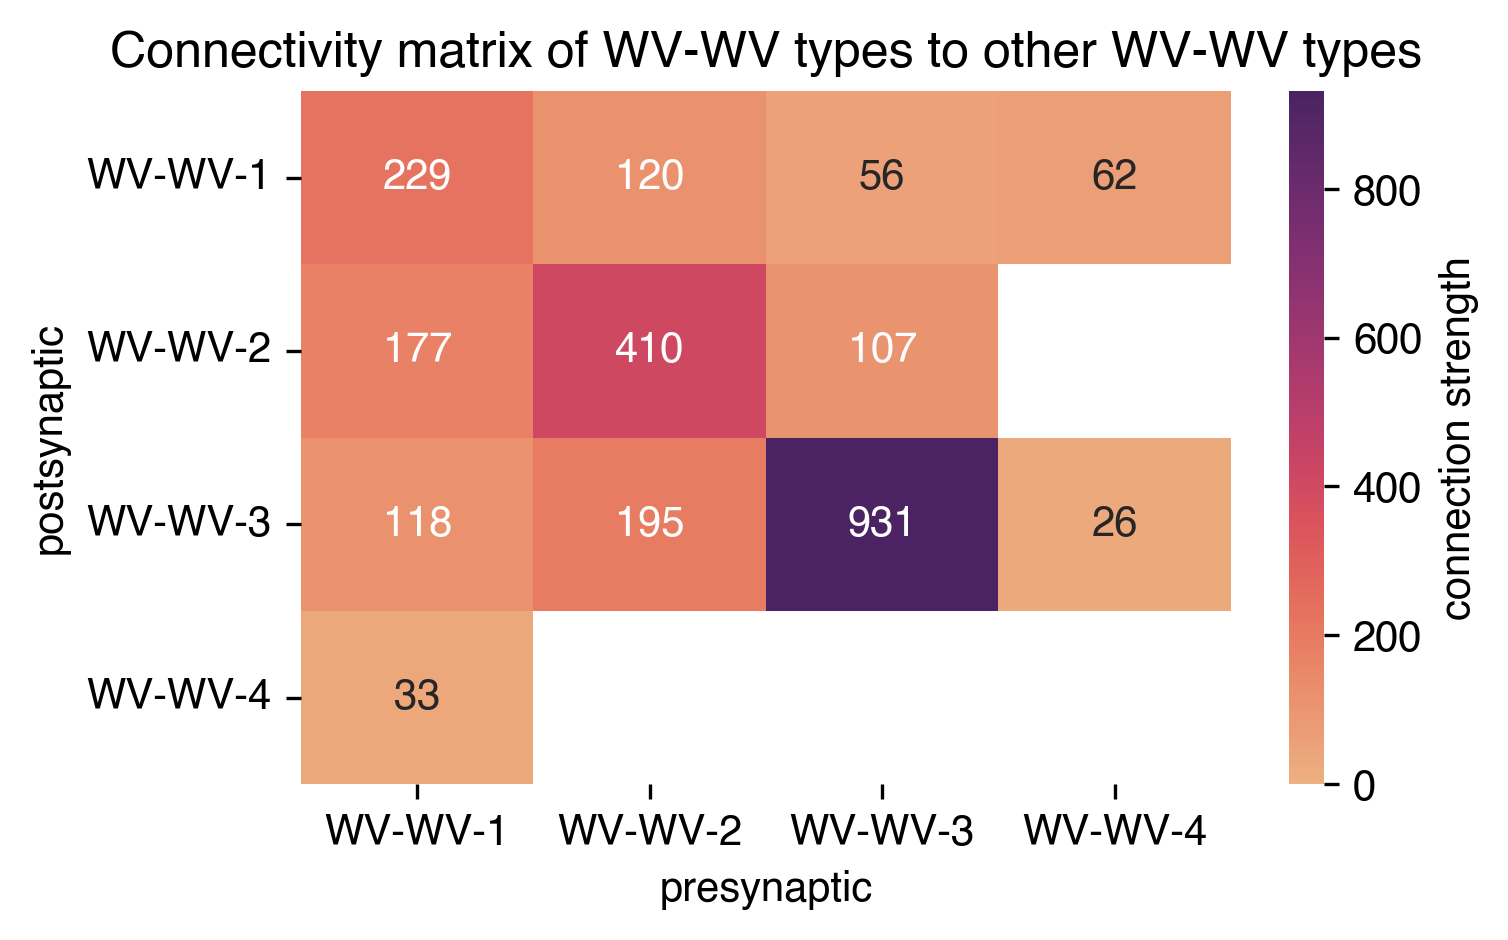

In [47]:
fig = plt.figure(figsize=(5,3))
seaborn.heatmap(wvwv_types_matrix, vmin=0, annot=True, fmt='g', cmap=seaborn.color_palette('flare', as_cmap=True), cbar_kws={'label': 'connection strength'})
plt.title('Connectivity matrix of WV-WV types to other WV-WV types')
plt.xlabel('presynaptic')
plt.ylabel('postsynaptic')

# Individual subtype analysis

For each subtype, I am going to visualize:

1. top inputs and outputs by summed synapse count (bar graph) 

2. song mode preferences of its inputs and outputs (pie chart)

In [48]:
#make a function to make simpler dfs easier to plot figures
#functions for cell types

def top10inputs_sum(celltype): #filter connection df to find top 10 inputs to any given cell type
    inputs_to_celltype = conns_types[conns_types['type_post']==celltype] #find all connections where postynaptic cell == celltype of interest
    grouped = inputs_to_celltype.groupby(['type_pre', 'pref_pre', 'class_pre', 'nt_type'], as_index=False, dropna=False)[['syn_count']].sum() #group by cell type and other relevant information
    new_df = grouped.sort_values(by='syn_count', ascending=False).head(10) #sort in descending order and take top 10 rows
    new_df.loc[new_df['pref_pre'].isnull(), 'pref_pre'] = 'None/Unknown' #change nan value to str name for plotting
    return new_df

def top10outputs_sum(celltype): #filter connection df to find top 10 outputs to any given cell type
    outputs_to_celltype = conns_types[conns_types['type_pre']==celltype]
    grouped = outputs_to_celltype.groupby(['type_post', 'pref_post', 'class_post', 'nt_type'], as_index=False, dropna=False)[['syn_count']].sum()
    new_df = grouped.sort_values(by='syn_count', ascending=False).head(10)
    new_df.loc[new_df['pref_post'].isnull(), 'pref_post'] = 'None/Unknown'
    return new_df

In [49]:
#create colormap for color coding preferences when plotting

color_map = {'intermediate':'purple', 'pulse':'blue', 'sine':'red', 'None/Unknown':'grey'}

## WV-WV-1

In [50]:
wvwv1_inputs = wvwv_inputs[wvwv_inputs['type_post']=='WV-WV-1']
wvwv1_outputs = wvwv_outputs[wvwv_outputs['type_pre']=='WV-WV-1']

### Top inputs and outputs (by cell type and summed synapse counts)

In [51]:
#use created function to find top 10 inputs to wv-wv-1
wvwv1_t10inputs = top10inputs_sum('WV-WV-1')
wvwv1_t10inputs

type_pre      pref_pre     class_pre nt_type  syn_count
31            B1         pulse      auditory     ACH       5594
80          JO-A  None/Unknown      auditory     ACH       2952
103     WED_pr02  intermediate      auditory    GABA        895
49        CB1538  None/Unknown  non-auditory    GABA        647
73         DNg24  None/Unknown  non-auditory    GABA        600
99       WED-VLP  intermediate      auditory     ACH        496
39        CB0591  None/Unknown  non-auditory     ACH        418
23       AVLP083  None/Unknown  non-auditory    GABA        347
29     AVLP_pr01          sine      auditory    GABA        315
18   AN_multi_33  None/Unknown  non-auditory    GABA        285

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'B1'),
  Text(1, 0, 'JO-A'),
  Text(2, 0, 'WED_pr02'),
  Text(3, 0, 'CB1538'),
  Text(4, 0, 'DNg24'),
  Text(5, 0, 'WED-VLP'),
  Text(6, 0, 'CB0591'),
  Text(7, 0, 'AVLP083'),
  Text(8, 0, 'AVLP_pr01'),
  Text(9, 0, 'AN_multi_33')])

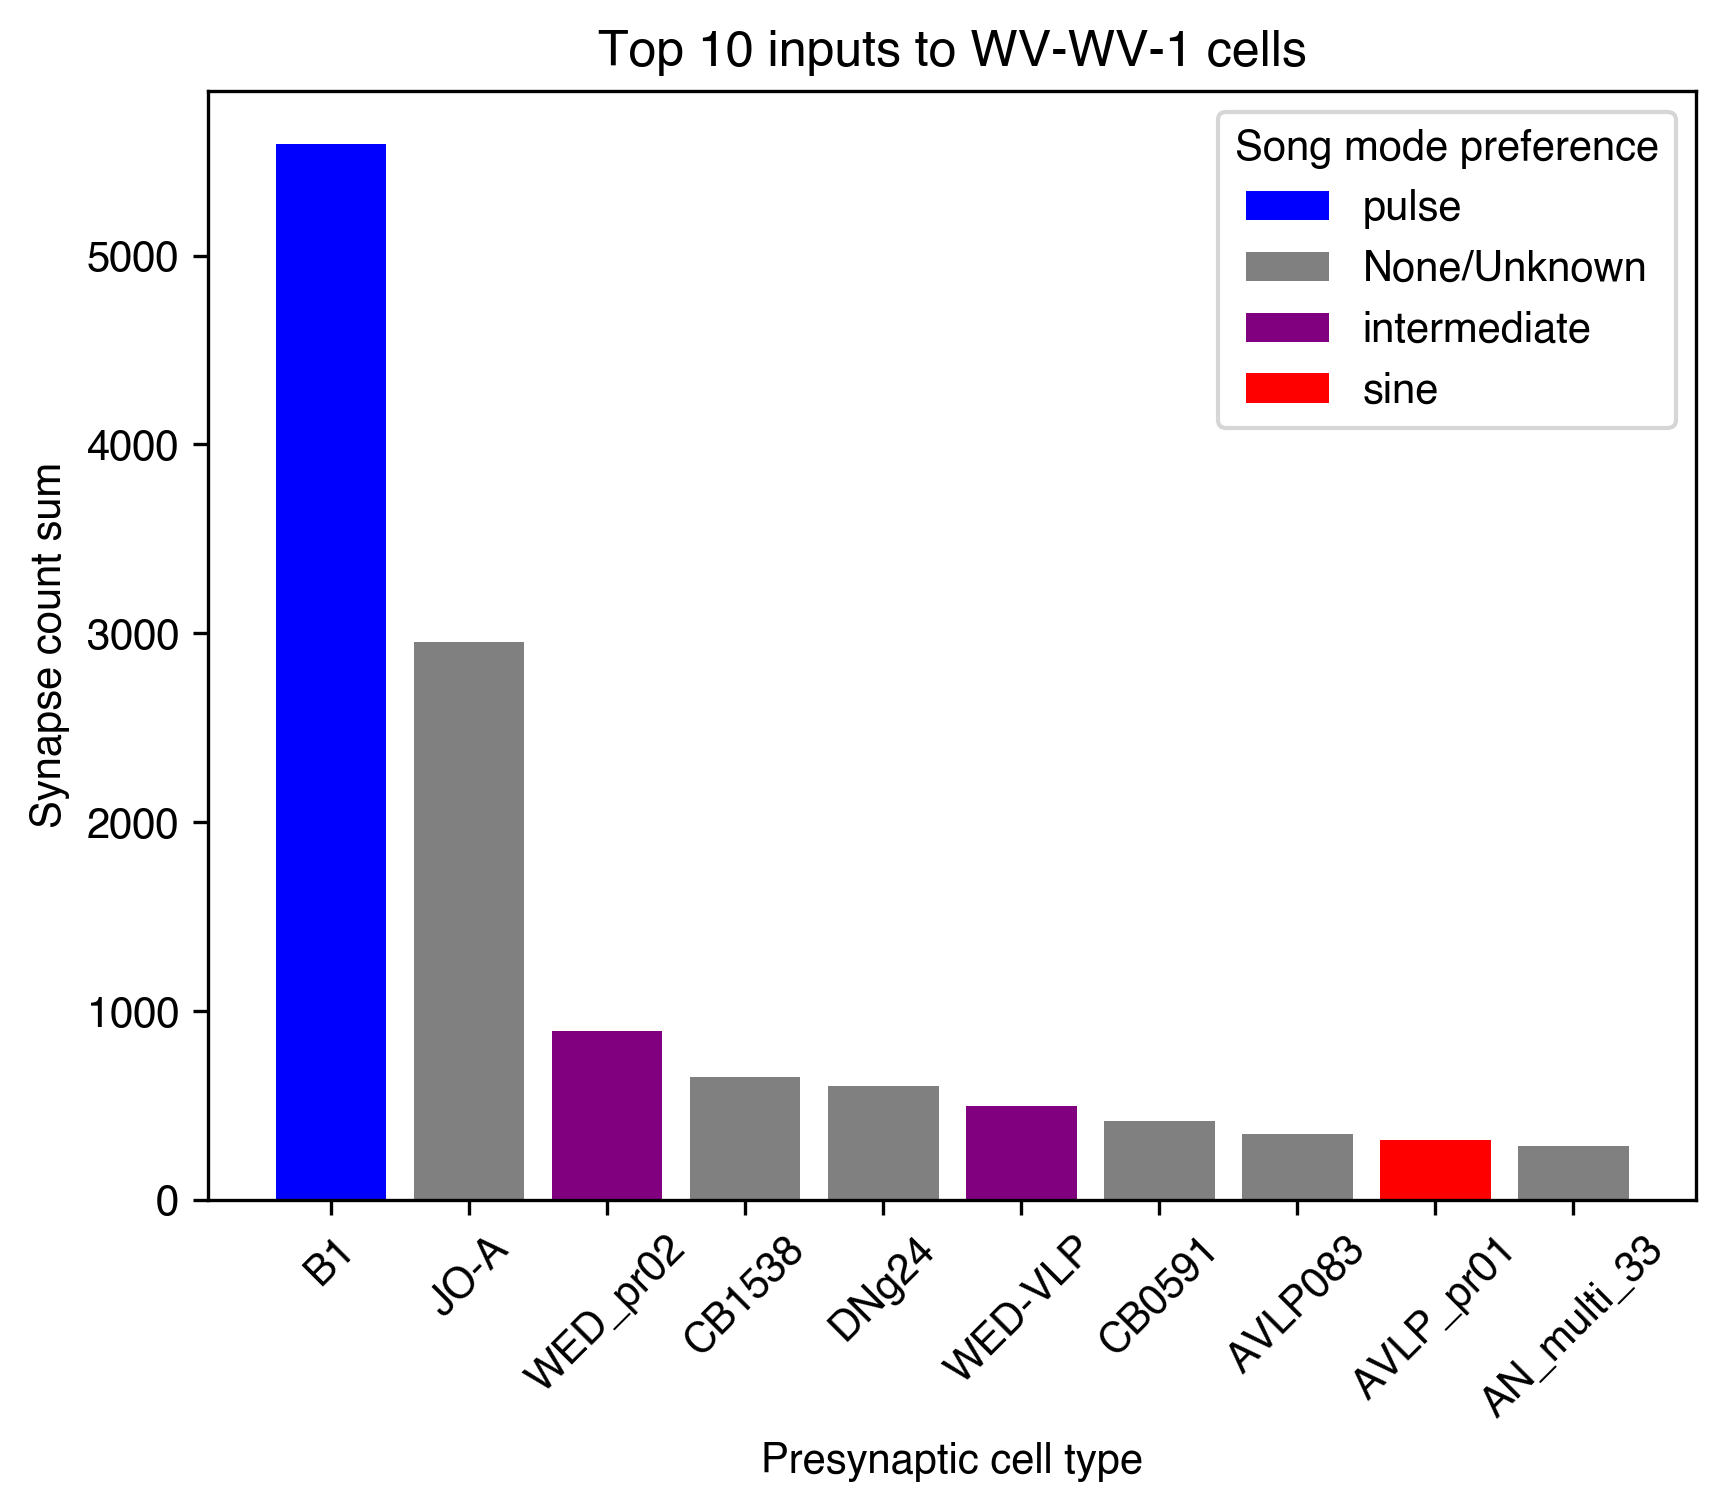

In [52]:
#turn into color coded bar chart
fig, ax = plt.subplots()

seen_labels = set() #this is to make sure that the legend doesn't duplicate color - label pairs

for i, row in wvwv1_t10inputs.iterrows(): #for every row in the input dataframe, assign color based on preference of cell type
    preferences = row['pref_pre']
    color = color_map[preferences]

    label = preferences if preferences not in seen_labels else None
    seen_labels.add(preferences)

    ax.bar(row['type_pre'], row['syn_count'], color=color, label=label)

ax.set_ylabel('Synapse count sum')
ax.set_xlabel('Presynaptic cell type')
ax.set_title('Top 10 inputs to WV-WV-1 cells')
ax.legend(title = 'Song mode preference')
plt.xticks(rotation=45)

In [53]:
#outputs with mode preferences
wvwv1_t10outputs = top10outputs_sum('WV-WV-1')
wvwv1_t10outputs

type_post     pref_post    class_post nt_type  syn_count
164    WED-VLP  intermediate      auditory    GABA       3189
179   WED_pr02  intermediate      auditory    GABA       2011
31   AVLP_pr01          sine      auditory    GABA        965
67      CB1538  None/Unknown  non-auditory    GABA        818
54      CB1110  None/Unknown  non-auditory    GABA        523
60      CB1206  None/Unknown  non-auditory    GABA        506
99      CB2545  None/Unknown  non-auditory    GABA        492
80      CB1948  None/Unknown  non-auditory    GABA        482
68      CB1557  None/Unknown  non-auditory    GABA        470
187        NaN  None/Unknown  non-auditory    GABA        417

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'WED-VLP'),
  Text(1, 0, 'WED_pr02'),
  Text(2, 0, 'AVLP_pr01'),
  Text(3, 0, 'CB1538'),
  Text(4, 0, 'CB1110'),
  Text(5, 0, 'CB1206'),
  Text(6, 0, 'CB2545'),
  Text(7, 0, 'CB1948'),
  Text(8, 0, 'CB1557')])

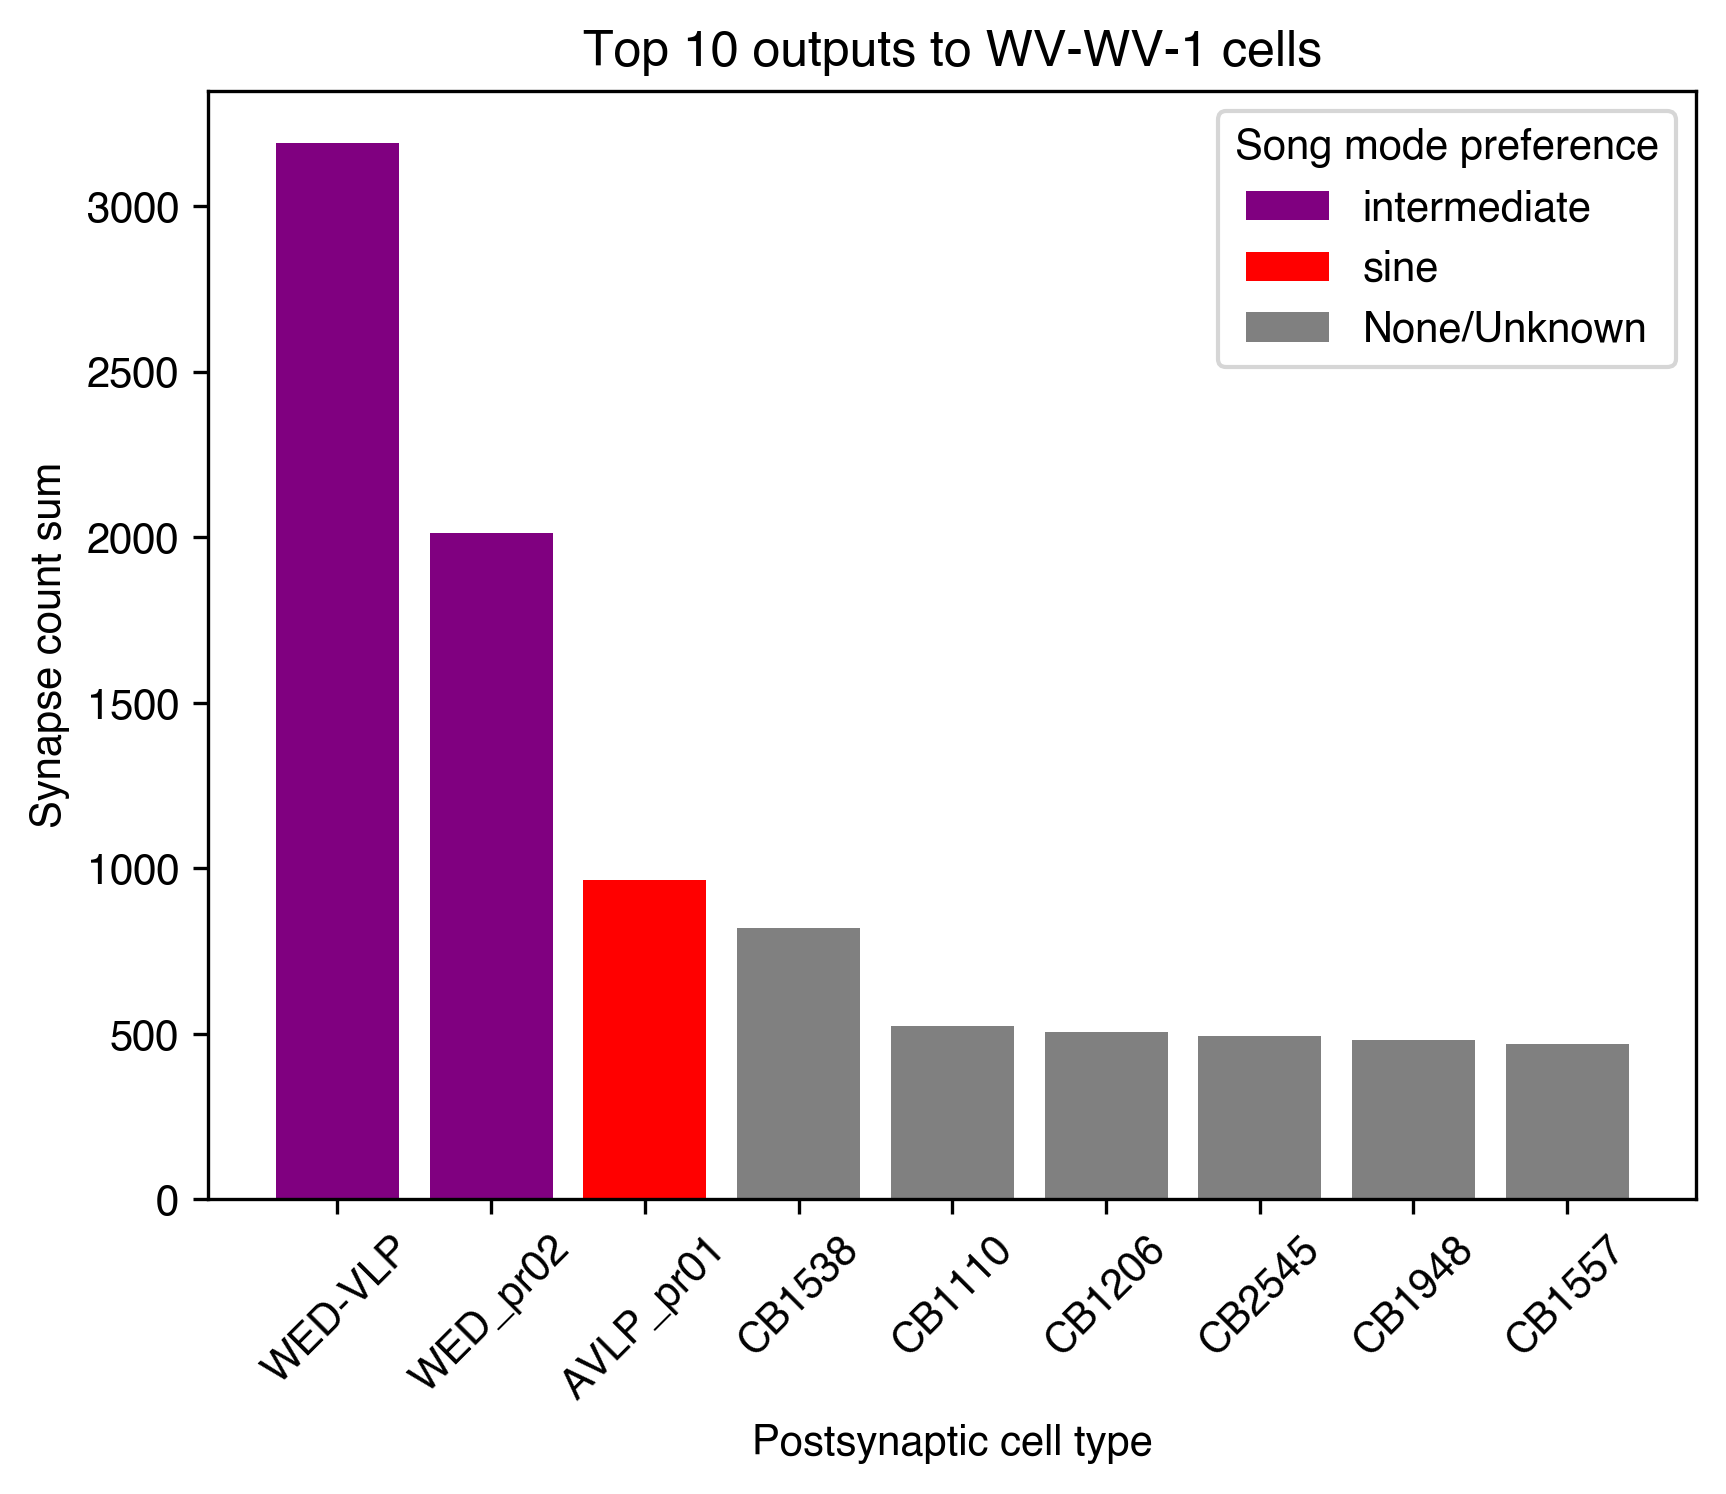

In [54]:
#turn into color coded bar chart
#repeat same process for inputs
fig, ax = plt.subplots()

seen_labels = set()

for i, row in wvwv1_t10outputs.iterrows():
    preferences = row['pref_post']
    color = color_map[preferences]

    label = preferences if preferences not in seen_labels else None
    seen_labels.add(preferences)

    ax.bar(row['type_post'], row['syn_count'], color=color, label=label)

ax.set_ylabel('Synapse count sum')
ax.set_xlabel('Postsynaptic cell type')
ax.set_title('Top 10 outputs to WV-WV-1 cells')
ax.legend(title = 'Song mode preference')
plt.xticks(rotation=45)

### By song mode preference

In [55]:
#filter by only song mode preference, sum synapse counts
wvwv1_inputs_prefs = wvwv1_inputs.groupby(['pref_pre'], dropna=False, as_index=False)[['syn_count']].sum()
wvwv1_inputs_prefs

pref_pre  syn_count
0  intermediate       1404
1         pulse       5623
2          sine        409
3           NaN       9623

Text(0.5, 1.0, 'Song mode preferences of WV-WV-1 inputs')

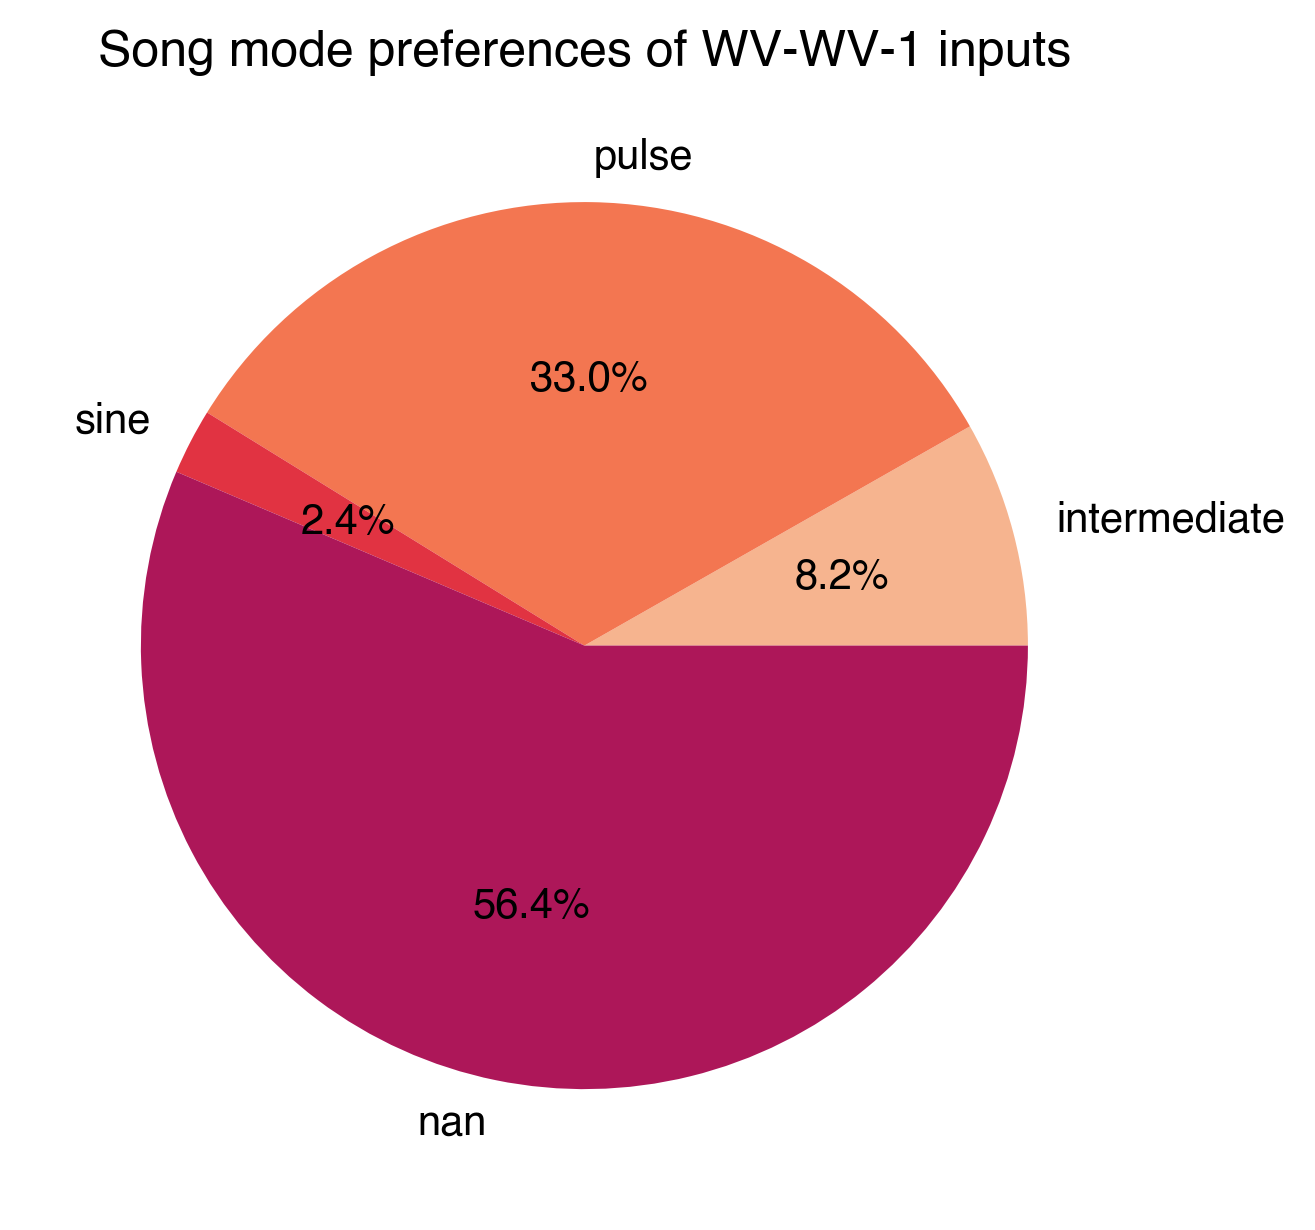

In [56]:
#directly make pie plot of preferences

plt.pie(wvwv1_inputs_prefs['syn_count'],
        labels = wvwv1_inputs_prefs['pref_pre'],
        autopct = '%1.1f%%',
        colors = seaborn.color_palette('rocket_r')
        )
plt.title('Song mode preferences of WV-WV-1 inputs')


In [57]:
wvwv1_outputs_prefs = wvwv1_outputs.groupby(['pref_post'], dropna=False, as_index=False)[['syn_count']].sum()
wvwv1_outputs_prefs

pref_post  syn_count
0  intermediate       5378
1         pulse        186
2          sine       1018
3           NaN      12014

Text(0.5, 1.0, 'Song mode preferences of WV-WV-1 outputs')

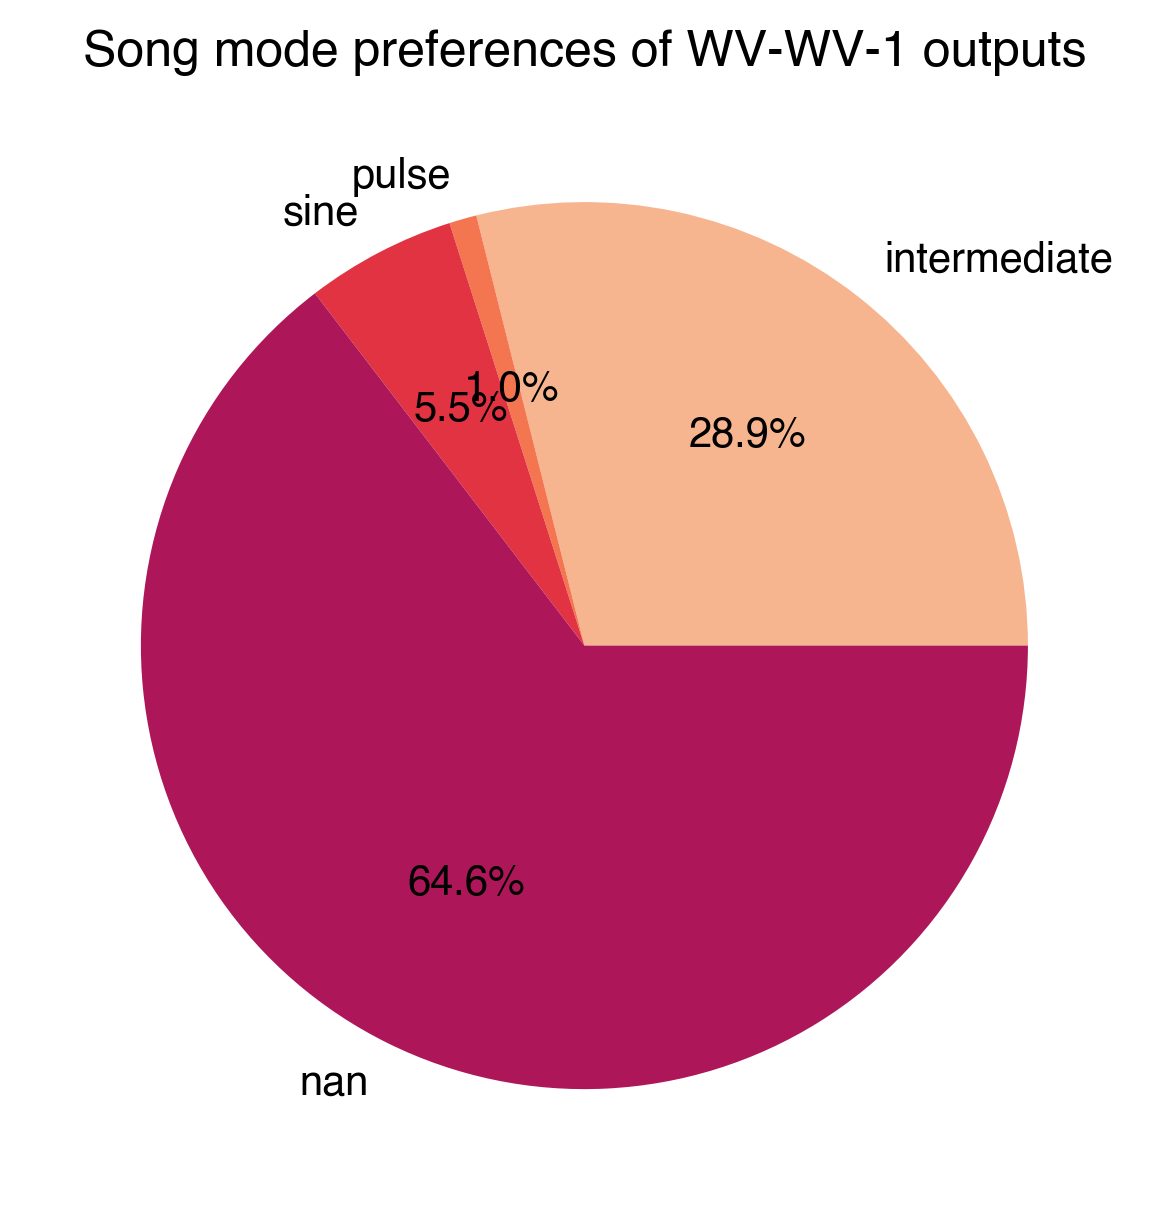

In [58]:
plt.pie(wvwv1_outputs_prefs['syn_count'],
        labels = wvwv1_outputs_prefs['pref_post'],
        autopct = '%1.1f%%',
        colors = seaborn.color_palette('rocket_r')
        )
plt.title('Song mode preferences of WV-WV-1 outputs')


## WV-WV-2

Now I'm going to repeat the same analysis/visualization process for all of the other subtypes.

In [59]:
wvwv2_inputs = wvwv_inputs[wvwv_inputs['type_post']=='WV-WV-2']
wvwv2_outputs = wvwv_outputs[wvwv_outputs['type_pre']=='WV-WV-2']

### Inputs and Outputs

In [60]:
wvwv2_t10inputs = top10inputs_sum('WV-WV-2')
wvwv2_t10inputs

type_pre      pref_pre     class_pre nt_type  syn_count
23         B1         pulse      auditory     ACH       5601
117  WED_pr02  intermediate      auditory    GABA       1182
59     CB1948  None/Unknown  non-auditory    GABA        717
66     CB2238  None/Unknown  non-auditory    GABA        496
69     CB2545  None/Unknown  non-auditory     ACH        463
119   WV-WV-2  None/Unknown      auditory    GABA        410
83     CB3655  None/Unknown  non-auditory    GABA        386
53     CB1557  None/Unknown  non-auditory     ACH        343
99       JO-B  None/Unknown      auditory     ACH        309
33     CB0466  None/Unknown  non-auditory    GABA        293

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'B1'),
  Text(1, 0, 'WED_pr02'),
  Text(2, 0, 'CB1948'),
  Text(3, 0, 'CB2238'),
  Text(4, 0, 'CB2545'),
  Text(5, 0, 'WV-WV-2'),
  Text(6, 0, 'CB3655'),
  Text(7, 0, 'CB1557'),
  Text(8, 0, 'JO-B'),
  Text(9, 0, 'CB0466')])

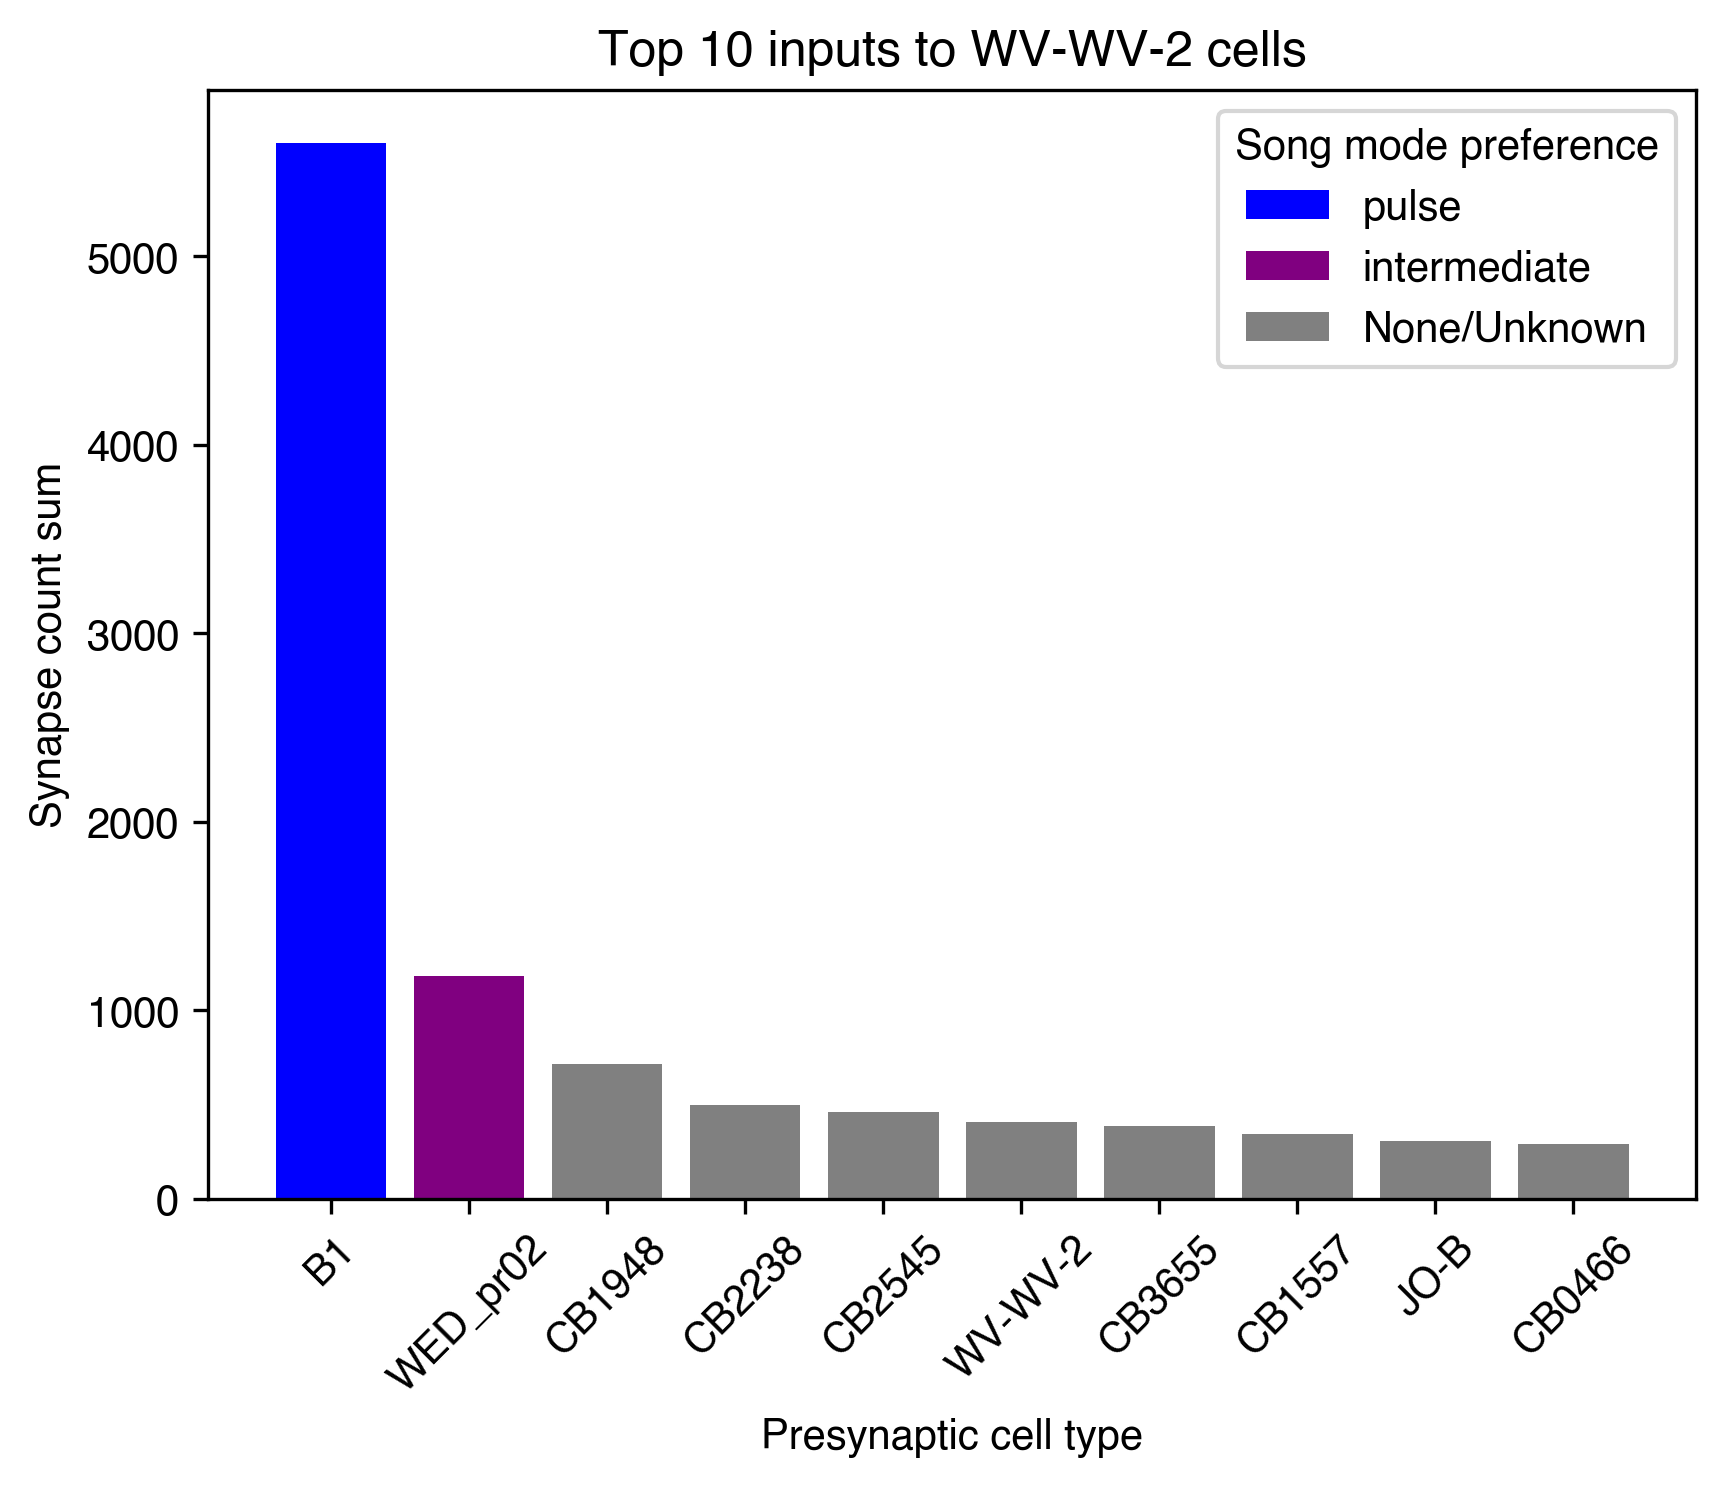

In [61]:
#turn into color coded bar chart
fig, ax = plt.subplots()

seen_labels = set()

for i, row in wvwv2_t10inputs.iterrows():
    preferences = row['pref_pre']
    color = color_map[preferences]

    label = preferences if preferences not in seen_labels else None
    seen_labels.add(preferences)

    ax.bar(row['type_pre'], row['syn_count'], color=color, label=label)

ax.set_ylabel('Synapse count sum')
ax.set_xlabel('Presynaptic cell type')
ax.set_title('Top 10 inputs to WV-WV-2 cells')
ax.legend(title = 'Song mode preference')
plt.xticks(rotation=45)

In [62]:
wvwv2_t10outputs = top10outputs_sum('WV-WV-2')
wvwv2_t10outputs

type_post     pref_post    class_post nt_type  syn_count
134  WED_pr02  intermediate      auditory    GABA       2243
53     CB1760  None/Unknown  non-auditory    GABA       1101
56     CB1948  None/Unknown  non-auditory    GABA       1044
63     CB2238  None/Unknown  non-auditory    GABA        891
30     CB0533  None/Unknown  non-auditory    GABA        873
44     CB1231  None/Unknown  non-auditory    GABA        481
70     CB2545  None/Unknown  non-auditory    GABA        479
36     CB1074  None/Unknown  non-auditory    GABA        434
136   WV-WV-2  None/Unknown      auditory    GABA        410
64     CB2305  None/Unknown  non-auditory    GABA        408

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'WED_pr02'),
  Text(1, 0, 'CB1760'),
  Text(2, 0, 'CB1948'),
  Text(3, 0, 'CB2238'),
  Text(4, 0, 'CB0533'),
  Text(5, 0, 'CB1231'),
  Text(6, 0, 'CB2545'),
  Text(7, 0, 'CB1074'),
  Text(8, 0, 'WV-WV-2'),
  Text(9, 0, 'CB2305')])

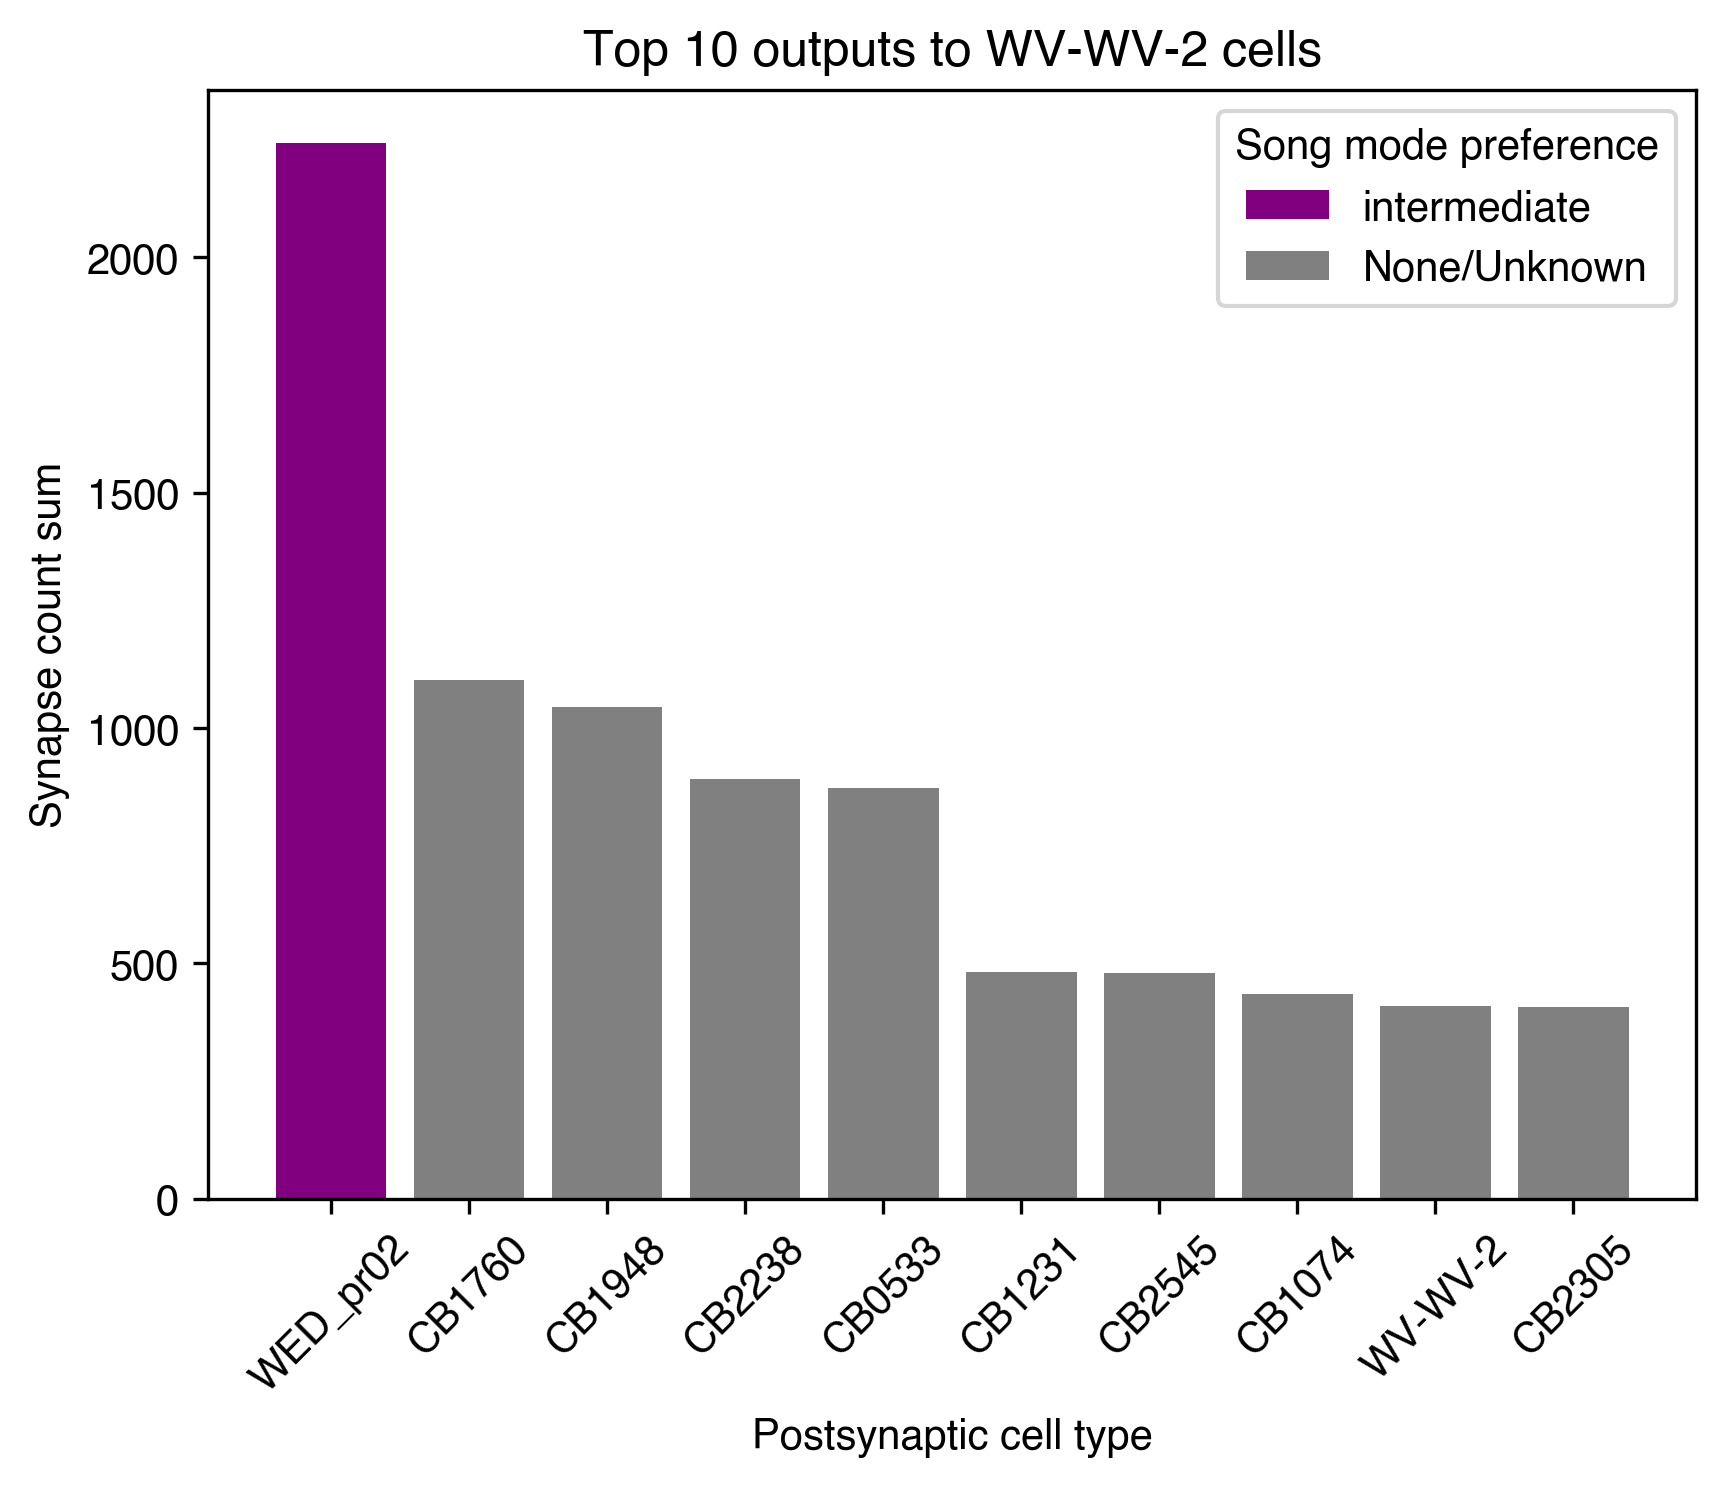

In [63]:
#turn into color coded bar chart
fig, ax = plt.subplots()

color_map = {'intermediate':'purple', 'pulse':'blue', 'sine':'red', 'None/Unknown':'grey'}
seen_labels = set()

for i, row in wvwv2_t10outputs.iterrows():
    preferences = row['pref_post']
    color = color_map[preferences]

    label = preferences if preferences not in seen_labels else None
    seen_labels.add(preferences)

    ax.bar(row['type_post'], row['syn_count'], color=color, label=label)

ax.set_ylabel('Synapse count sum')
ax.set_xlabel('Postsynaptic cell type')
ax.set_title('Top 10 outputs to WV-WV-2 cells')
ax.legend(title = 'Song mode preference')
plt.xticks(rotation=45)

### By song mode preference

In [64]:
wvwv2_inputs_prefs = wvwv2_inputs.groupby(['pref_pre'], as_index=False, dropna=False)[['syn_count']].sum()
wvwv2_inputs_prefs

pref_pre  syn_count
0  intermediate       1240
1         pulse       5733
2          sine         66
3           NaN      10105

Text(0.5, 1.0, 'Song mode preferences of WV-WV-2 inputs')

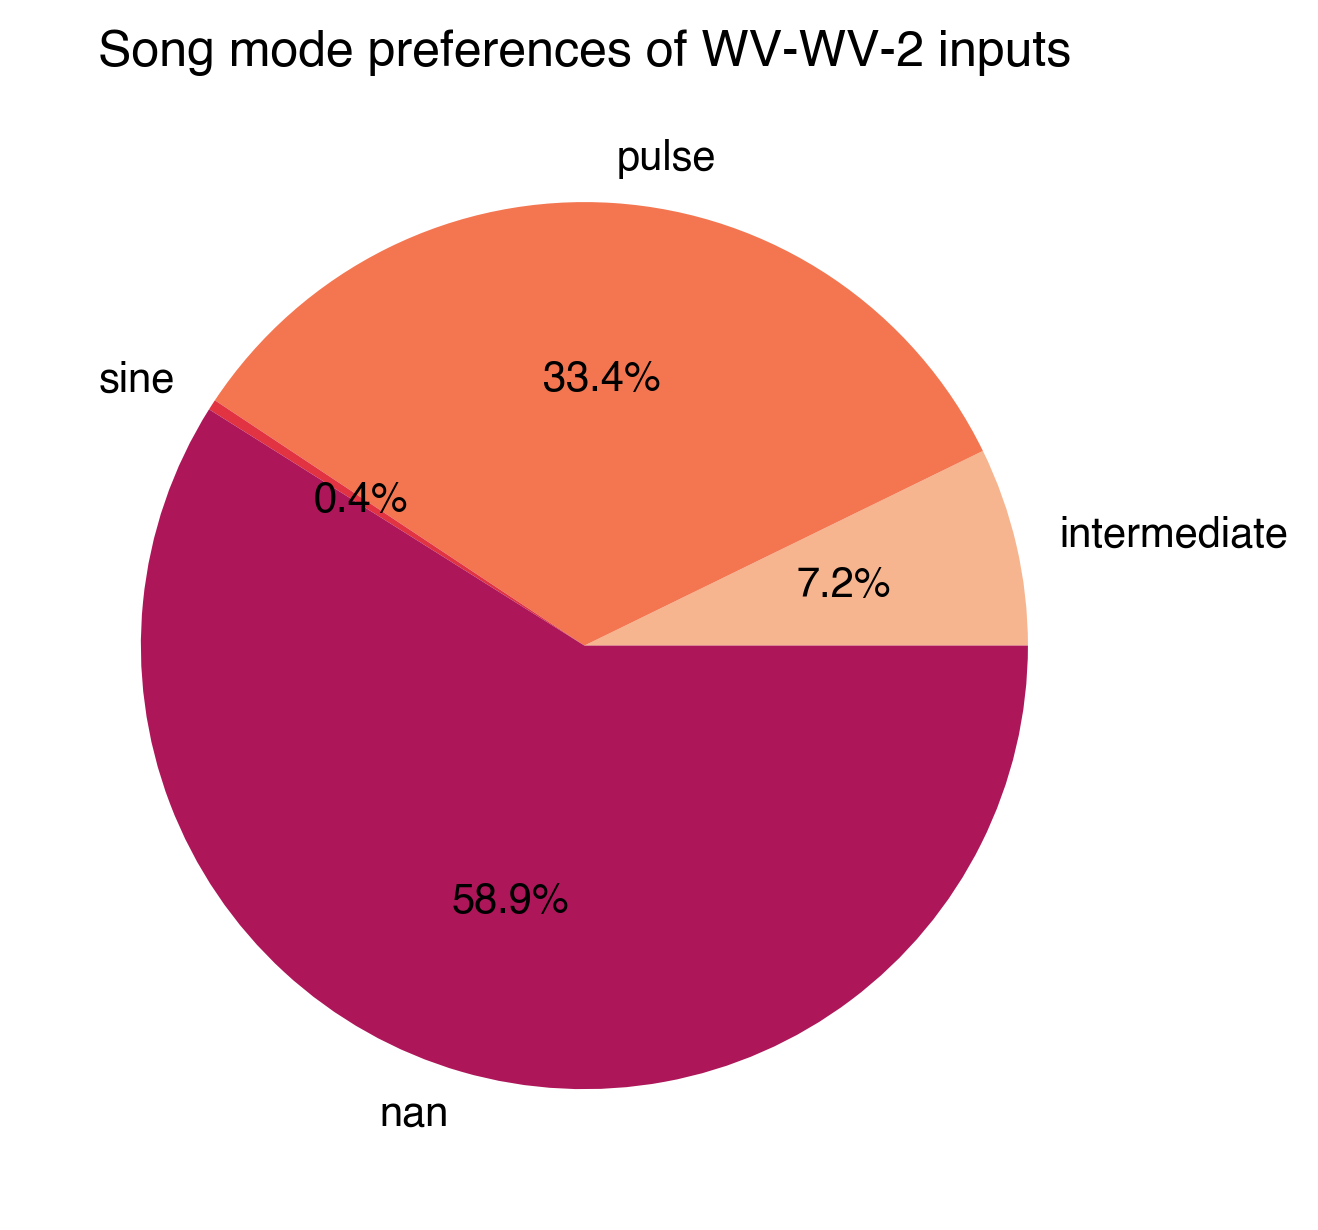

In [65]:
#directly make pie plot of preferences

plt.pie(wvwv2_inputs_prefs['syn_count'],
        labels = wvwv2_inputs_prefs['pref_pre'],
        autopct = '%1.1f%%',
        colors = seaborn.color_palette('rocket_r')
        )
plt.title('Song mode preferences of WV-WV-2 inputs')


In [66]:
wvwv2_outputs_prefs = wvwv2_outputs.groupby(['pref_post'], as_index=False, dropna=False)[['syn_count']].sum()
wvwv2_outputs_prefs

pref_post  syn_count
0  intermediate       2345
1         pulse        115
2          sine        112
3           NaN      15584

Text(0.5, 1.0, 'Song mode preferences of WV-WV-2 outputs')

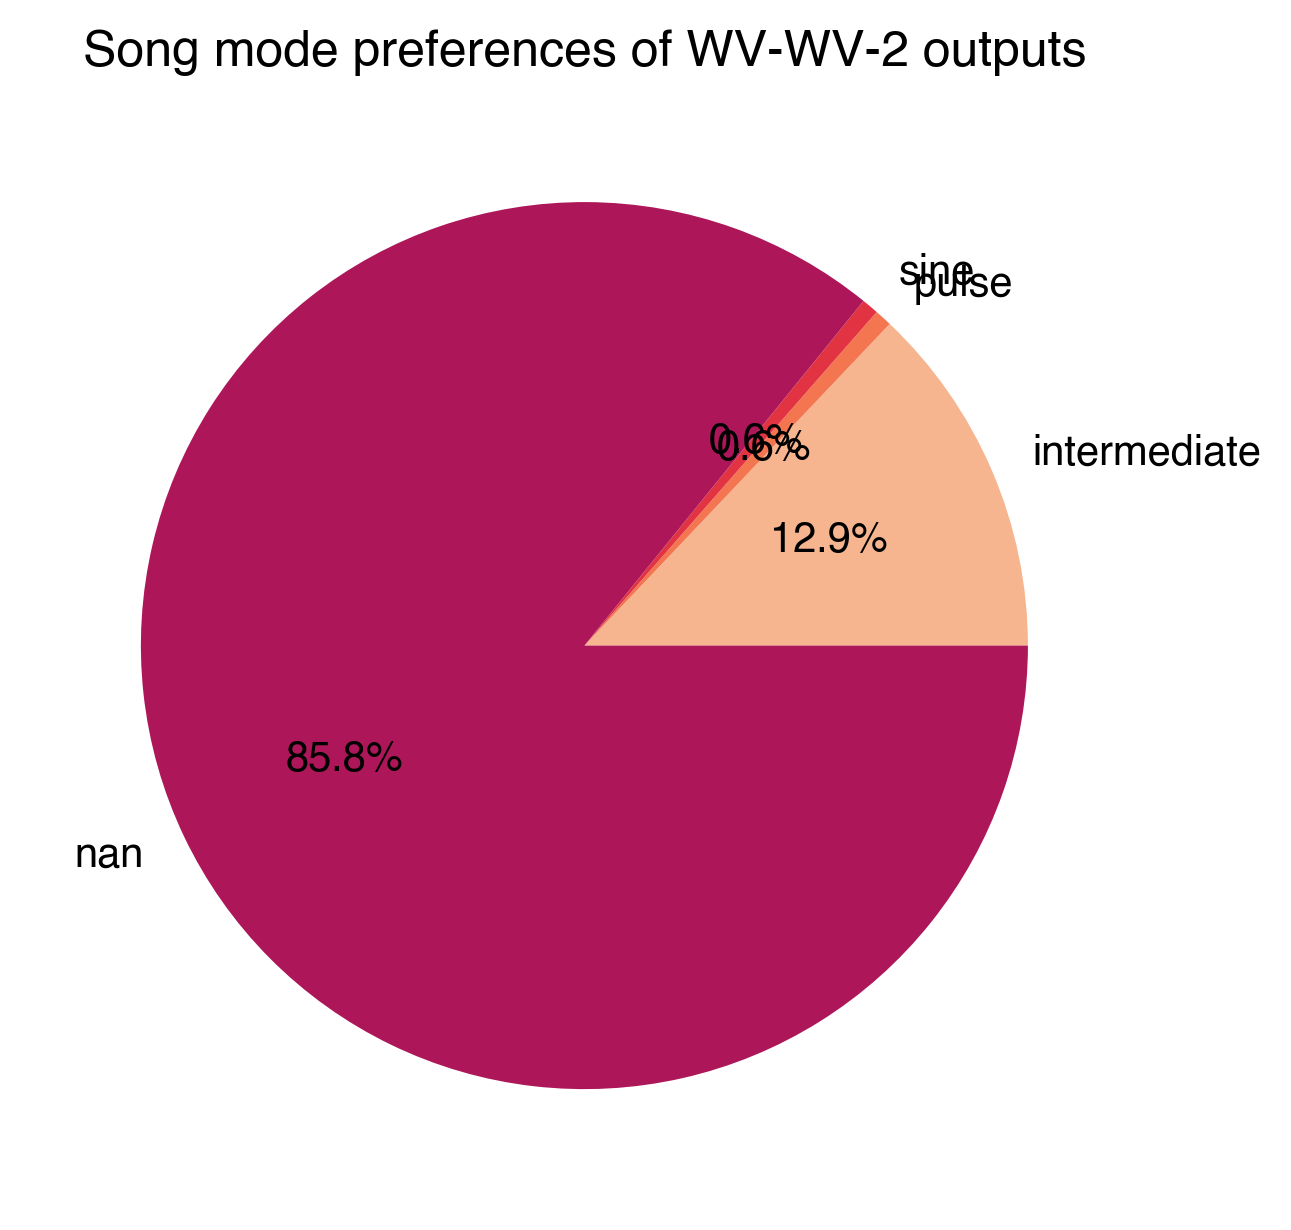

In [67]:
plt.pie(wvwv2_outputs_prefs['syn_count'],
        labels = wvwv2_outputs_prefs['pref_post'],
        autopct = '%1.1f%%',
        colors = seaborn.color_palette('rocket_r')
        )
plt.title('Song mode preferences of WV-WV-2 outputs')


## WV-WV-3

In [68]:
wvwv3_inputs = wvwv_inputs[wvwv_inputs['type_post']=='WV-WV-3']
wvwv3_outputs = wvwv_outputs[wvwv_outputs['type_pre']=='WV-WV-3']

### Inputs and outputs by cell type and mode preference

In [69]:
wvwv3_t10inputs = top10inputs_sum('WV-WV-3')
wvwv3_t10inputs

type_pre      pref_pre     class_pre nt_type  syn_count
122      JO-A  None/Unknown      auditory     ACH       3291
38         B1         pulse      auditory     ACH       2669
105     DNg40  None/Unknown  non-auditory    GLUT       1130
154   WV-WV-3  None/Unknown      auditory    GABA        931
77     CB1948  None/Unknown  non-auditory    GABA        854
47     CB0261  None/Unknown  non-auditory     ACH        683
124      JO-B  None/Unknown      auditory     ACH        576
147  SAD_pr02          sine      auditory    GABA        520
102     DNg24  None/Unknown  non-auditory    GABA        515
50     CB0307  None/Unknown  non-auditory    GABA        395

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'JO-A'),
  Text(1, 0, 'B1'),
  Text(2, 0, 'DNg40'),
  Text(3, 0, 'WV-WV-3'),
  Text(4, 0, 'CB1948'),
  Text(5, 0, 'CB0261'),
  Text(6, 0, 'JO-B'),
  Text(7, 0, 'SAD_pr02'),
  Text(8, 0, 'DNg24'),
  Text(9, 0, 'CB0307')])

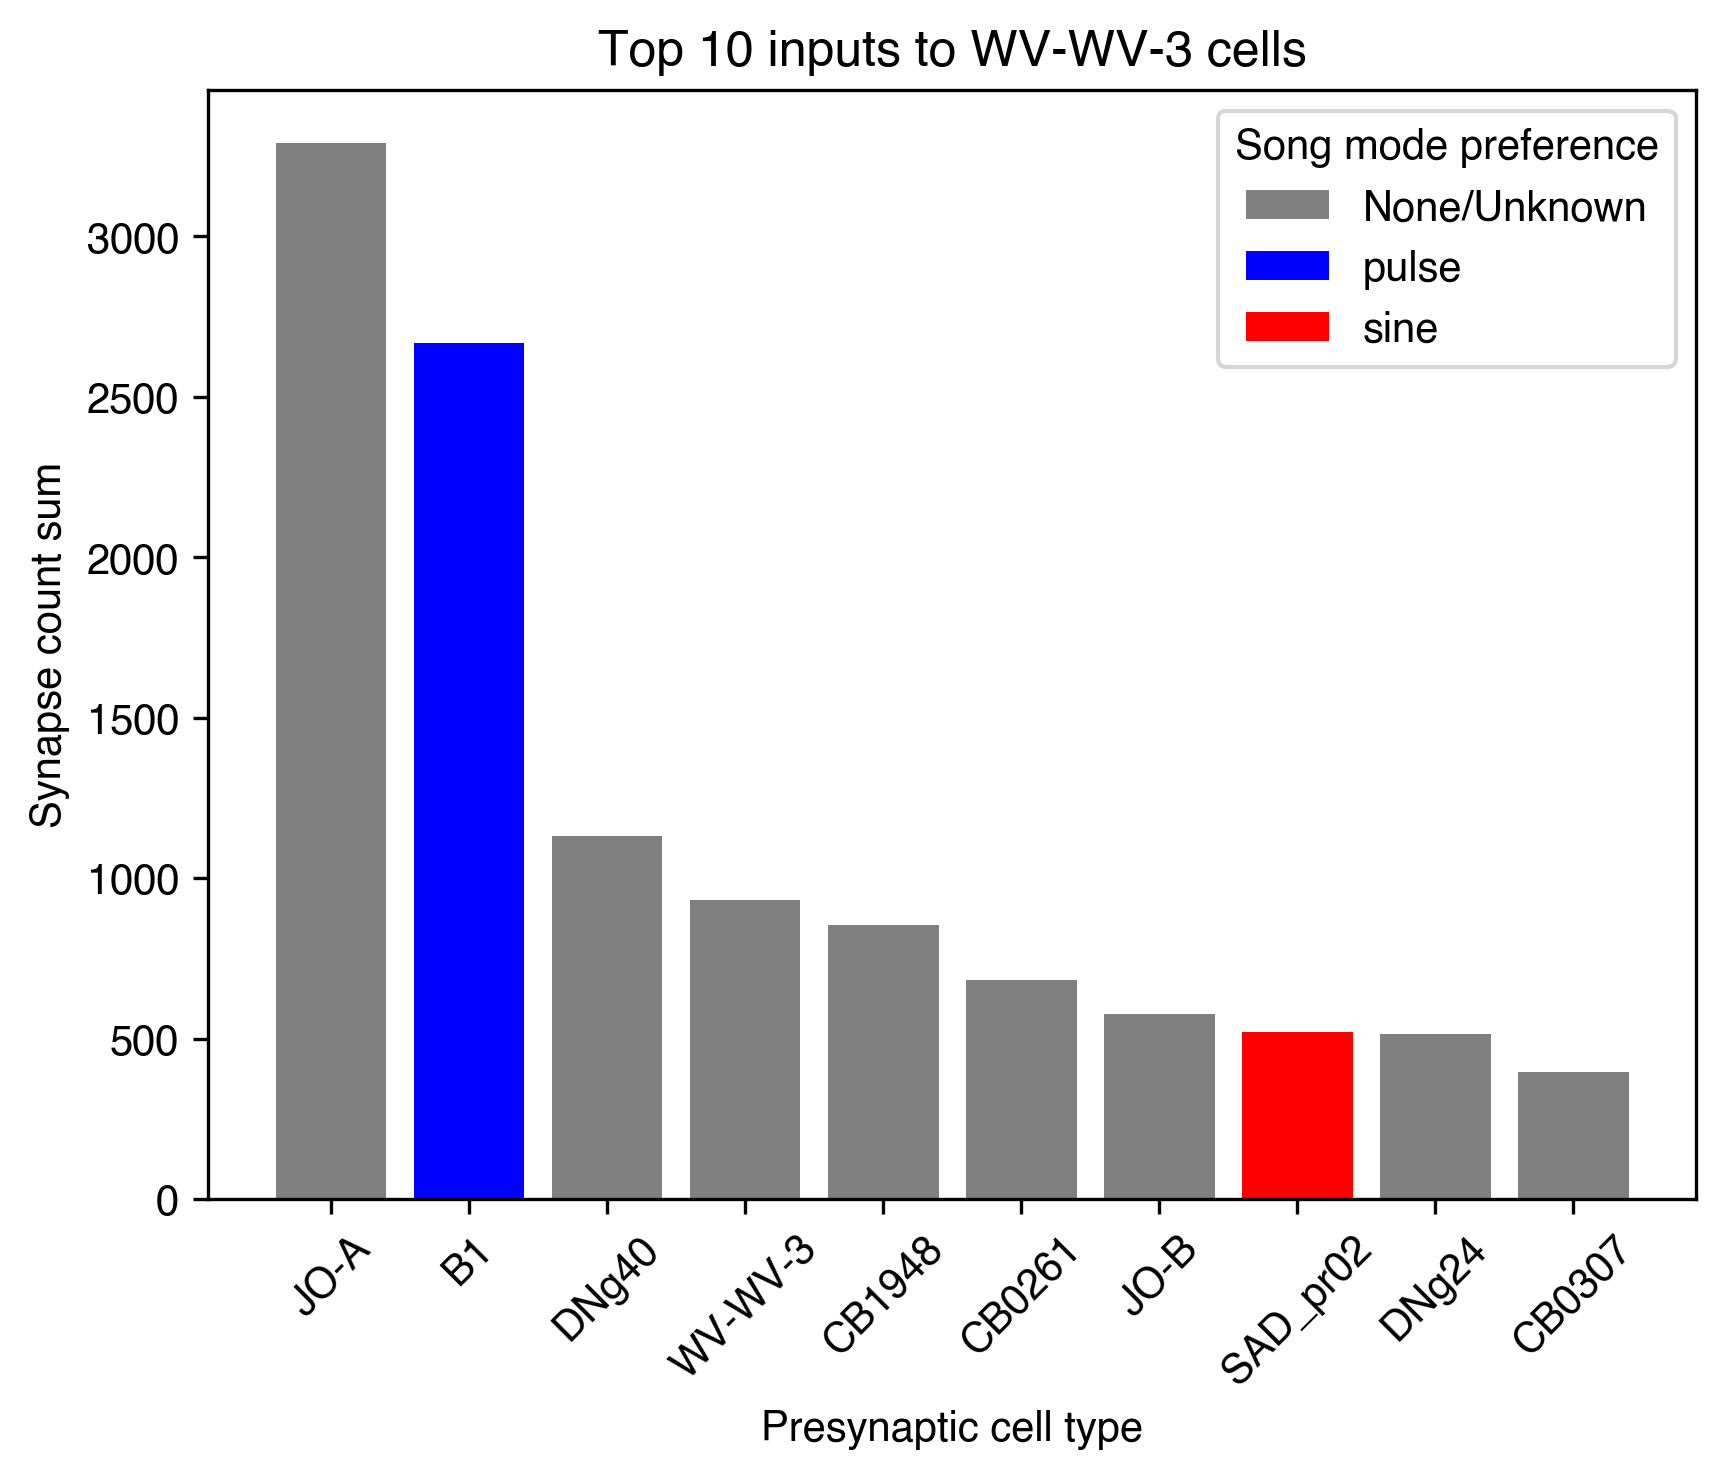

In [70]:
#turn into color coded bar chart
fig, ax = plt.subplots()

color_map = {'intermediate':'purple', 'pulse':'blue', 'sine':'red', 'None/Unknown':'grey'}
seen_labels = set()

for i, row in wvwv3_t10inputs.iterrows():
    preferences = row['pref_pre']
    color = color_map[preferences]

    label = preferences if preferences not in seen_labels else None
    seen_labels.add(preferences)

    ax.bar(row['type_pre'], row['syn_count'], color=color, label=label)

ax.set_ylabel('Synapse count sum')
ax.set_xlabel('Presynaptic cell type')
ax.set_title('Top 10 inputs to WV-WV-3 cells')
ax.legend(title = 'Song mode preference')
plt.xticks(rotation=45)

In [71]:
wvwv3_t10outputs = top10outputs_sum('WV-WV-3')
wvwv3_t10outputs

type_post     pref_post    class_post nt_type  syn_count
1     AMMC-A1  None/Unknown      auditory    GABA       1381
87      DNp01  None/Unknown      auditory    GABA       1372
88      DNp02  None/Unknown  non-auditory    GABA       1136
118   WV-WV-3  None/Unknown      auditory    GABA        931
80      DNg24  None/Unknown  non-auditory    GABA        718
14         B1         pulse      auditory    GABA        468
91      DNp11  None/Unknown  non-auditory    GABA        381
28     CB0956  None/Unknown  non-auditory    GABA        376
48     CB1948  None/Unknown  non-auditory    GABA        366
38     CB1538  None/Unknown  non-auditory    GABA        316

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'AMMC-A1'),
  Text(1, 0, 'DNp01'),
  Text(2, 0, 'DNp02'),
  Text(3, 0, 'WV-WV-3'),
  Text(4, 0, 'DNg24'),
  Text(5, 0, 'B1'),
  Text(6, 0, 'DNp11'),
  Text(7, 0, 'CB0956'),
  Text(8, 0, 'CB1948'),
  Text(9, 0, 'CB1538')])

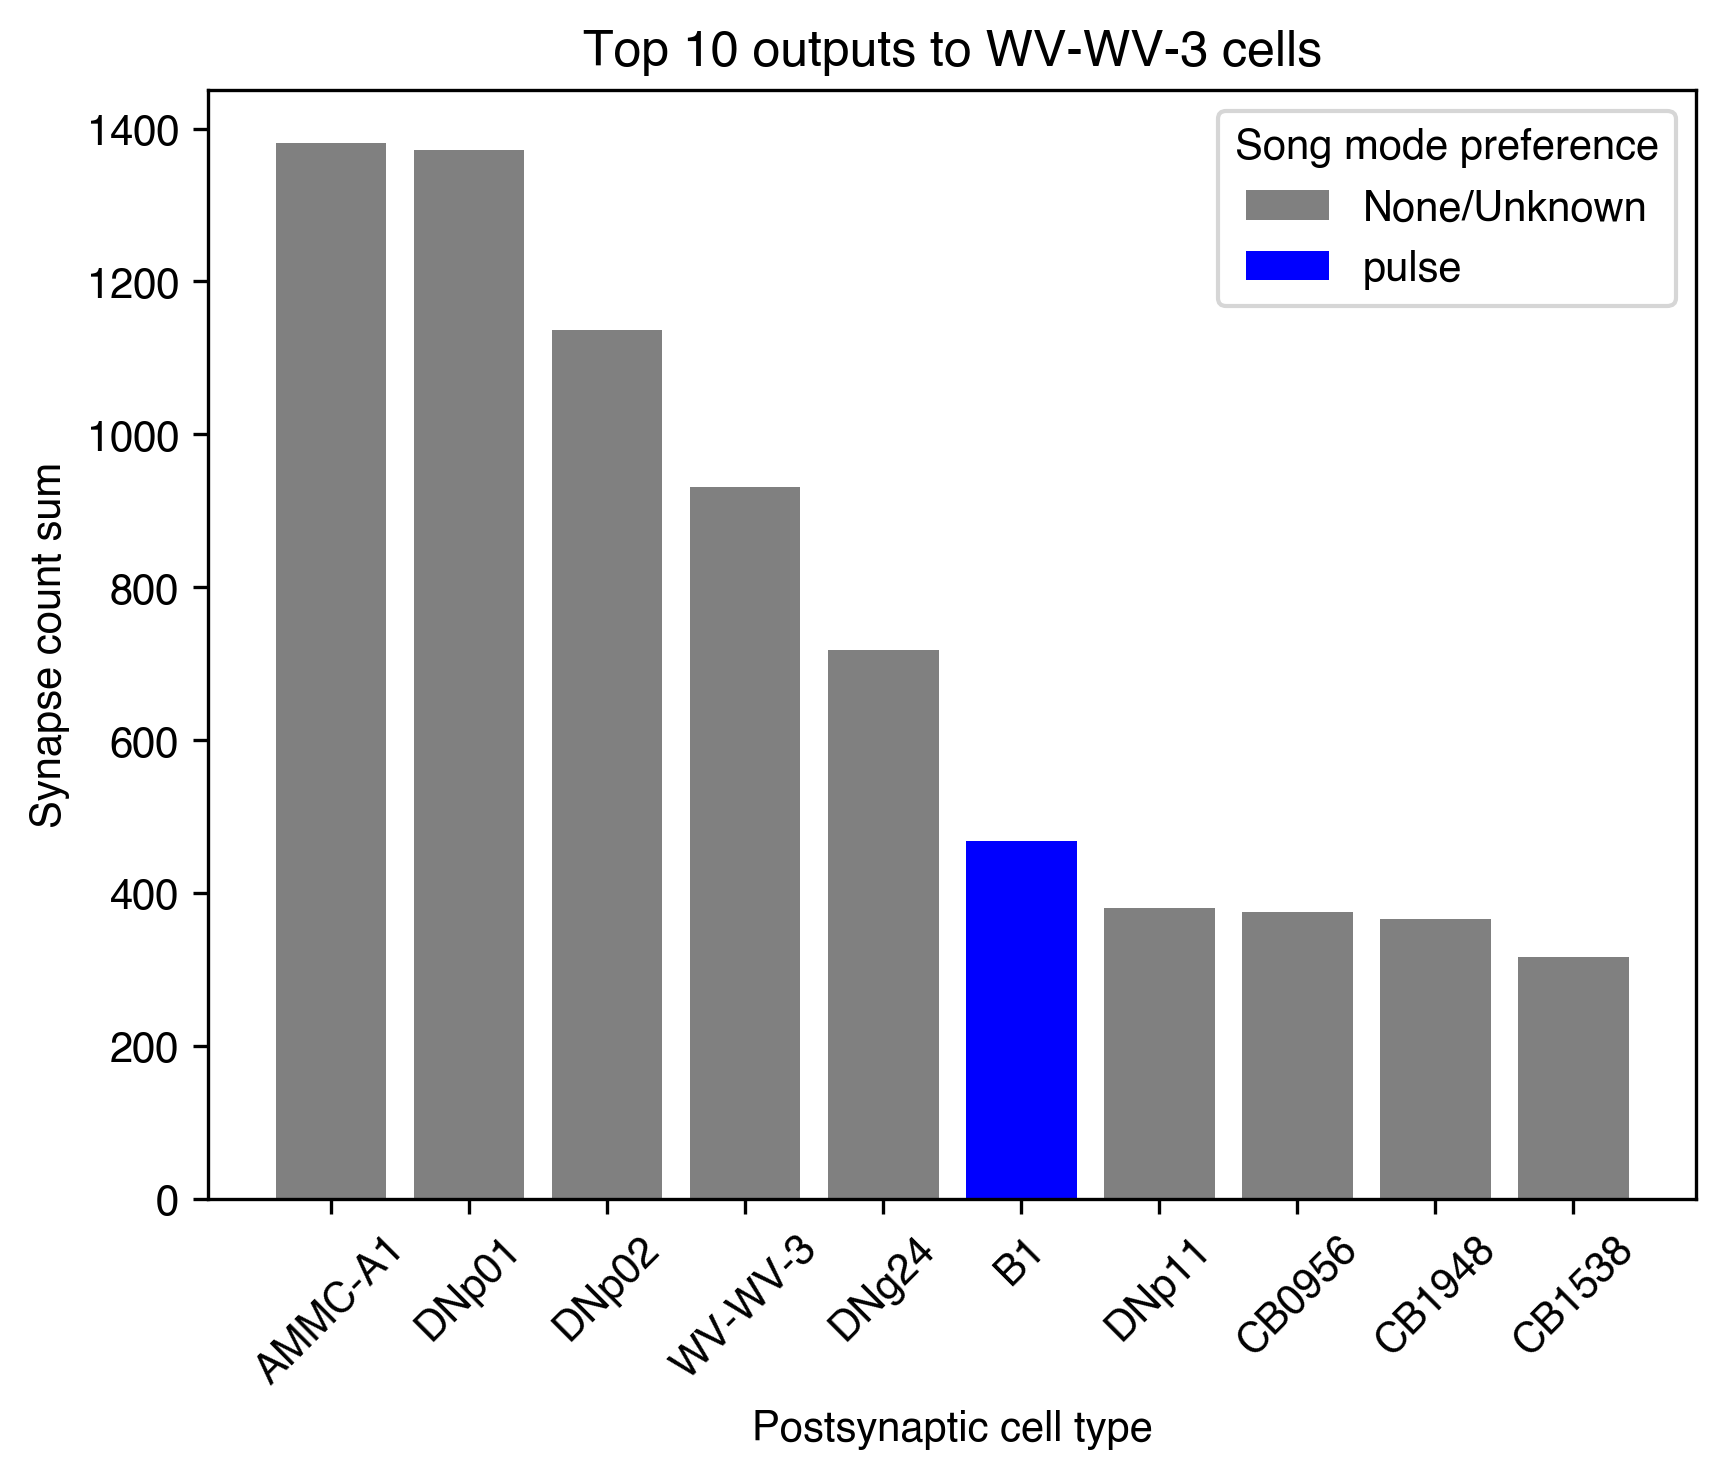

In [72]:
#turn into color coded bar chart
fig, ax = plt.subplots()

color_map = {'intermediate':'purple', 'pulse':'blue', 'sine':'red', 'None/Unknown':'grey'}
seen_labels = set()

for i, row in wvwv3_t10outputs.iterrows():
    preferences = row['pref_post']
    color = color_map[preferences]

    label = preferences if preferences not in seen_labels else None
    seen_labels.add(preferences)

    ax.bar(row['type_post'], row['syn_count'], color=color, label=label)

ax.set_ylabel('Synapse count sum')
ax.set_xlabel('Postsynaptic cell type')
ax.set_title('Top 10 outputs to WV-WV-3 cells')
ax.legend(title = 'Song mode preference')
plt.xticks(rotation=45)

### By song mode preference

In [73]:
wvwv3_inputs_prefs = wvwv3_inputs.groupby(['pref_pre'], as_index=False, dropna=False)[['syn_count']].sum()
wvwv3_inputs_prefs

pref_pre  syn_count
0  intermediate        193
1         pulse       2710
2          sine        520
3           NaN      17299

Text(0.5, 1.0, 'Song mode preferences of WV-WV-3 inputs')

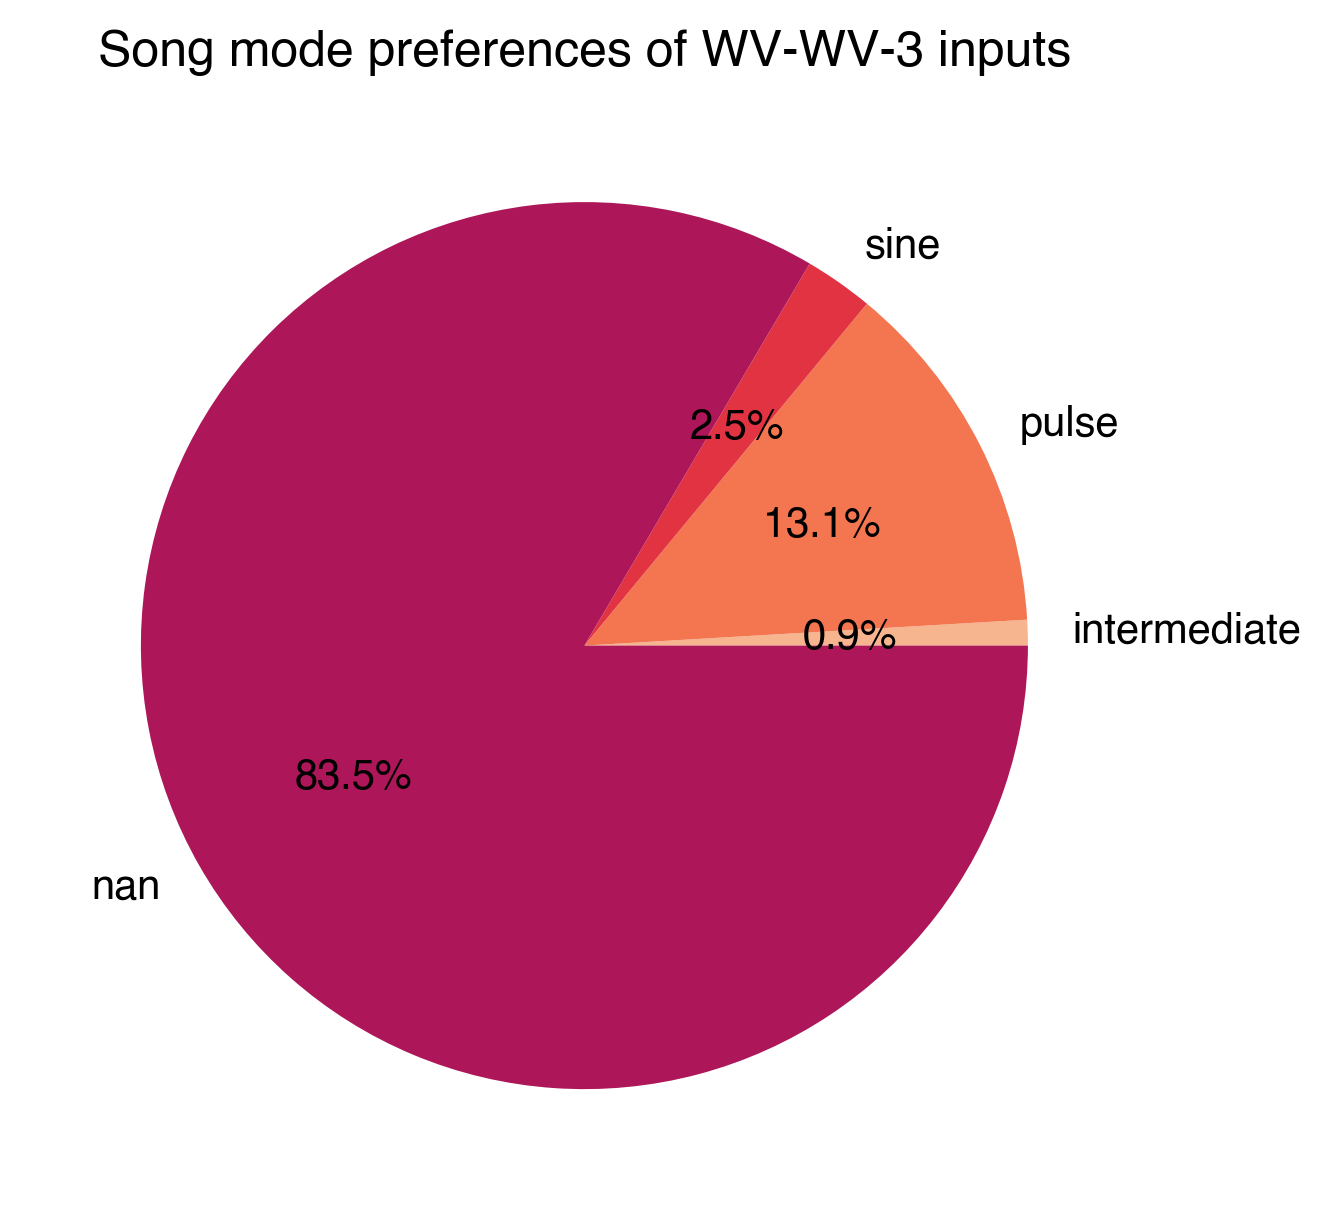

In [74]:
#directly make pie plot of preferences

plt.pie(wvwv3_inputs_prefs['syn_count'],
        labels = wvwv3_inputs_prefs['pref_pre'],
        autopct = '%1.1f%%',
        colors = seaborn.color_palette('rocket_r')
        )
plt.title('Song mode preferences of WV-WV-3 inputs')


In [75]:
wvwv3_outputs_prefs = wvwv3_outputs.groupby(['pref_post'], as_index=False, dropna=False)[['syn_count']].sum()
wvwv3_outputs_prefs

pref_post  syn_count
0  intermediate         92
1         pulse        578
2          sine        124
3           NaN      13429

Text(0.5, 1.0, 'Song mode preferences of WV-WV-3 outputs')

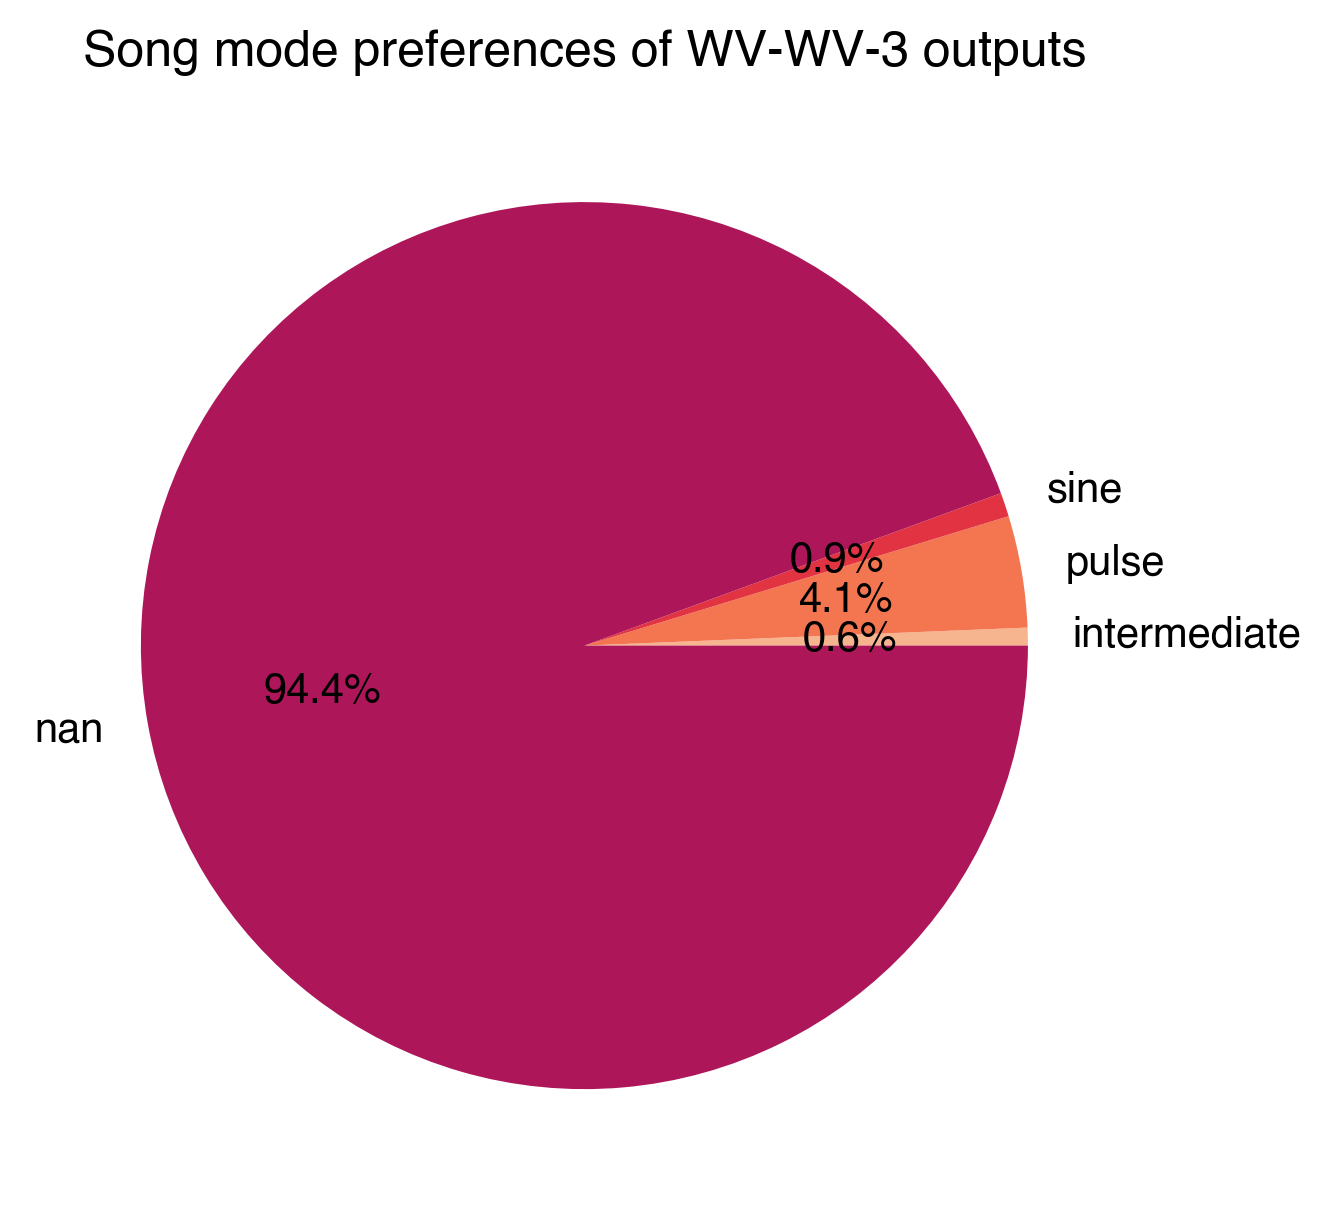

In [76]:
plt.pie(wvwv3_outputs_prefs['syn_count'],
        labels = wvwv3_outputs_prefs['pref_post'],
        autopct = '%1.1f%%',
        colors = seaborn.color_palette('rocket_r')
        )
plt.title('Song mode preferences of WV-WV-3 outputs')


## WV-WV-4

In [77]:
wvwv4_inputs = wvwv_inputs[wvwv_inputs['type_post']=='WV-WV-4']
wvwv4_outputs = wvwv_outputs[wvwv_outputs['type_pre']=='WV-WV-4']

### Inputs and outputs

In [78]:
wvwv4_t10inputs = top10inputs_sum('WV-WV-4')
wvwv4_t10inputs

type_pre      pref_pre     class_pre nt_type  syn_count
61     WED_pr02  intermediate      auditory    GABA        301
0            A2         pulse      auditory     ACH        164
30      CB1817a  None/Unknown      auditory     ACH        144
49      DNpe025  None/Unknown  non-auditory     ACH        112
21           B1         pulse      auditory     ACH         82
52         JO-A  None/Unknown      auditory     ACH         55
20  AN_multi_60  None/Unknown  non-auditory     ACH         53
42      DNge130  None/Unknown  non-auditory     ACH         51
13   AN_GNG_198  None/Unknown  non-auditory    GABA         51
48        DNp55  None/Unknown  non-auditory     ACH         46

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'WED_pr02'),
  Text(1, 0, 'A2'),
  Text(2, 0, 'CB1817a'),
  Text(3, 0, 'DNpe025'),
  Text(4, 0, 'B1'),
  Text(5, 0, 'JO-A'),
  Text(6, 0, 'AN_multi_60'),
  Text(7, 0, 'DNge130'),
  Text(8, 0, 'AN_GNG_198'),
  Text(9, 0, 'DNp55')])

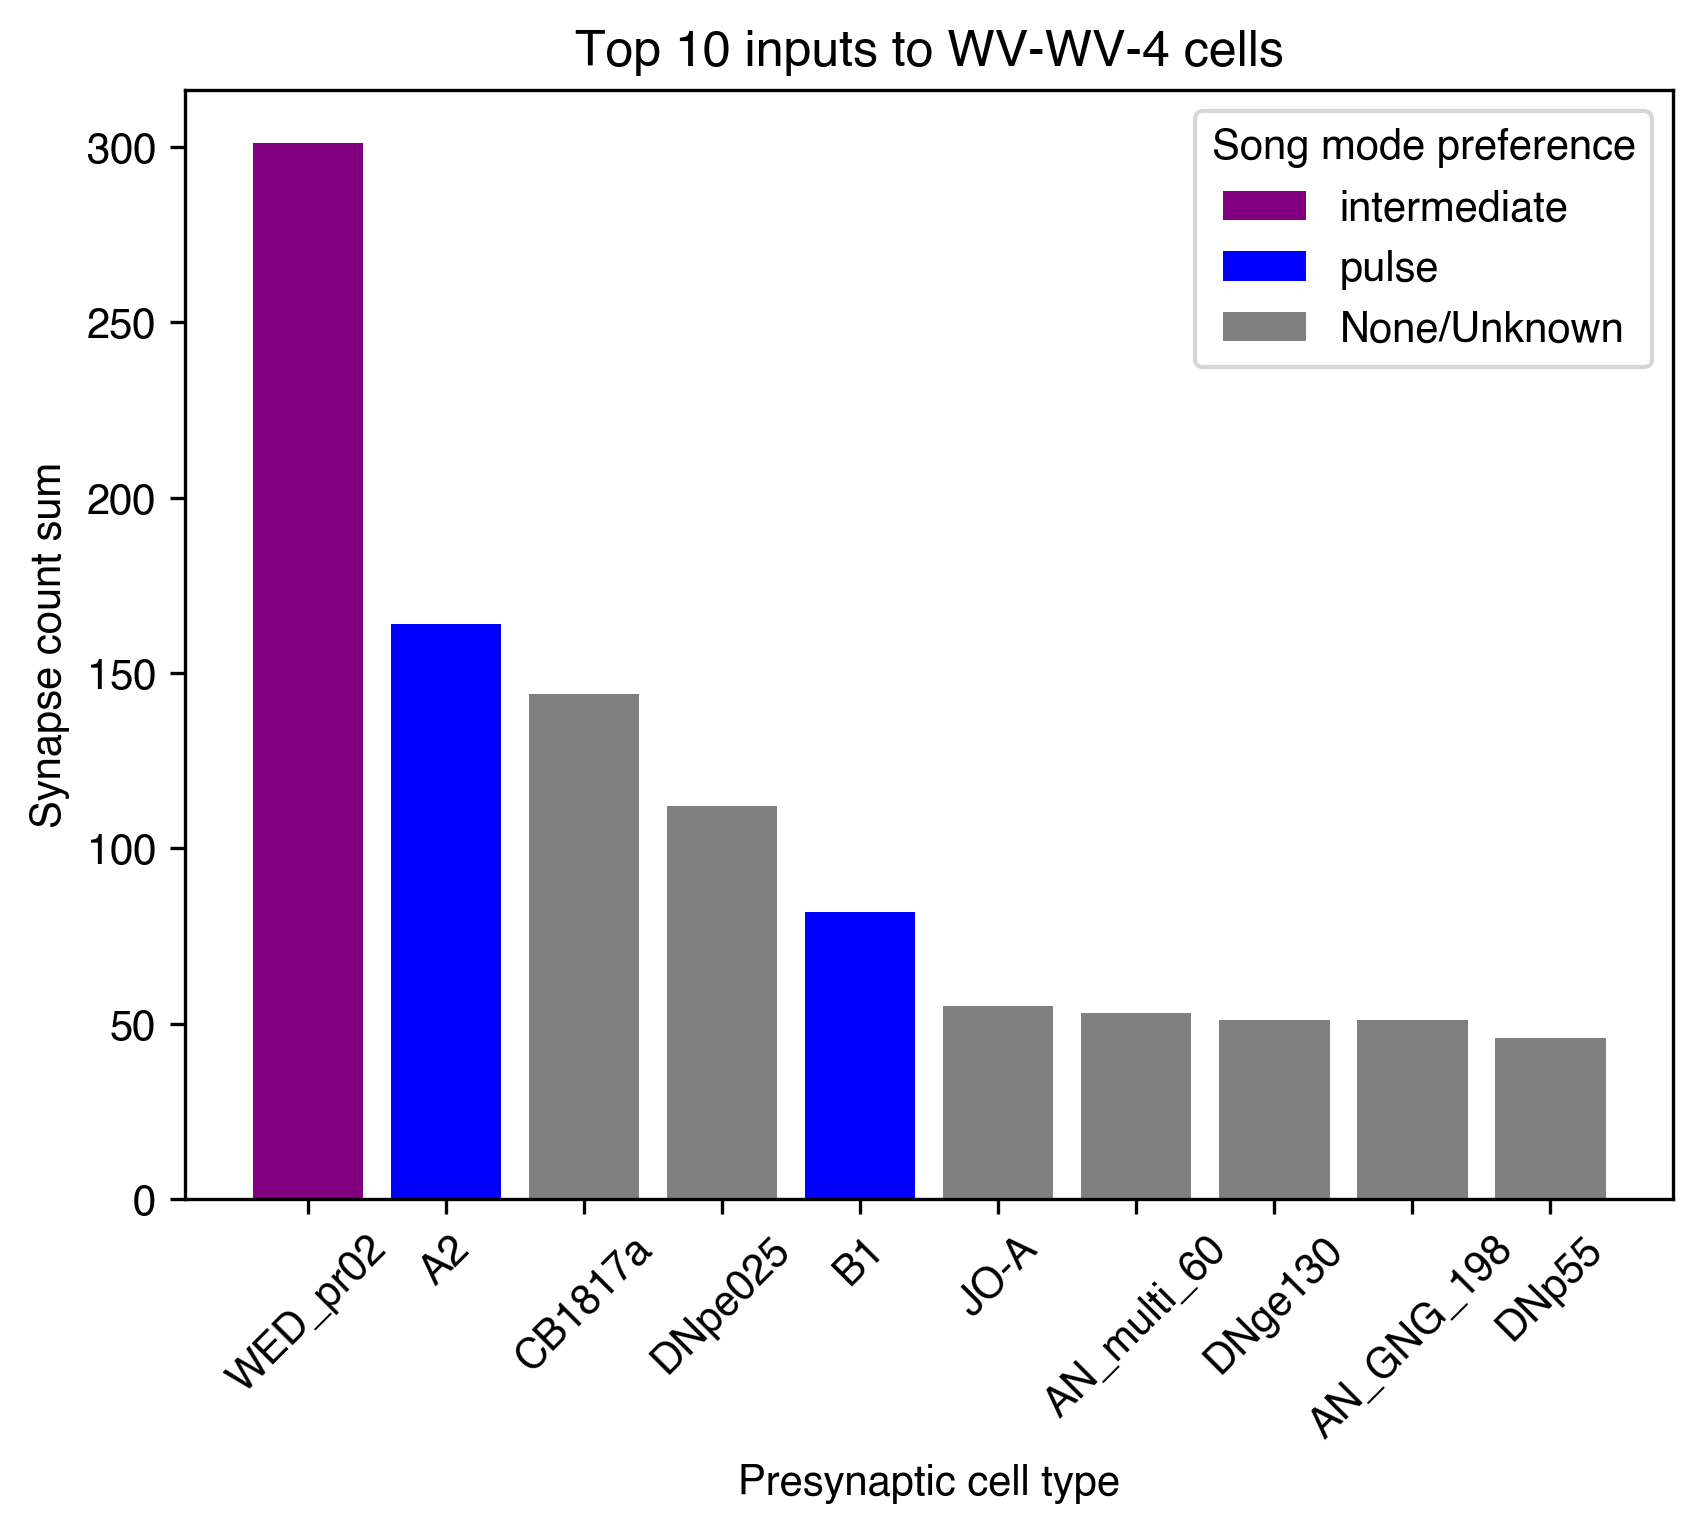

In [79]:
#turn into color coded bar chart
fig, ax = plt.subplots()

color_map = {'intermediate':'purple', 'pulse':'blue', 'sine':'red', 'None/Unknown':'grey'}
seen_labels = set()

for i, row in wvwv4_t10inputs.iterrows():
    preferences = row['pref_pre']
    color = color_map[preferences]

    label = preferences if preferences not in seen_labels else None
    seen_labels.add(preferences)

    ax.bar(row['type_pre'], row['syn_count'], color=color, label=label)

ax.set_ylabel('Synapse count sum')
ax.set_xlabel('Presynaptic cell type')
ax.set_title('Top 10 inputs to WV-WV-4 cells')
ax.legend(title = 'Song mode preference')
plt.xticks(rotation=45)

In [80]:
wvwv4_t10outputs = top10outputs_sum('WV-WV-4')
wvwv4_t10outputs

type_post     pref_post    class_post nt_type  syn_count
0         A2         pulse      auditory    GABA        208
27   CB1817a  None/Unknown      auditory    GABA        196
23    CB1231  None/Unknown  non-auditory    GABA        155
15    CB0956  None/Unknown  non-auditory    GABA        134
52   DNge130  None/Unknown  non-auditory    GABA        110
5     CB0010  None/Unknown  non-auditory    GABA        103
67       NaN  None/Unknown  non-auditory    GABA         89
60  SAD_pr02          sine      auditory    GABA         82
57    SAD014  None/Unknown  non-auditory    GABA         76
46    DNg108  None/Unknown  non-auditory    GABA         66

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'A2'),
  Text(1, 0, 'CB1817a'),
  Text(2, 0, 'CB1231'),
  Text(3, 0, 'CB0956'),
  Text(4, 0, 'DNge130'),
  Text(5, 0, 'CB0010'),
  Text(6, 0, 'SAD_pr02'),
  Text(7, 0, 'SAD014'),
  Text(8, 0, 'DNg108')])

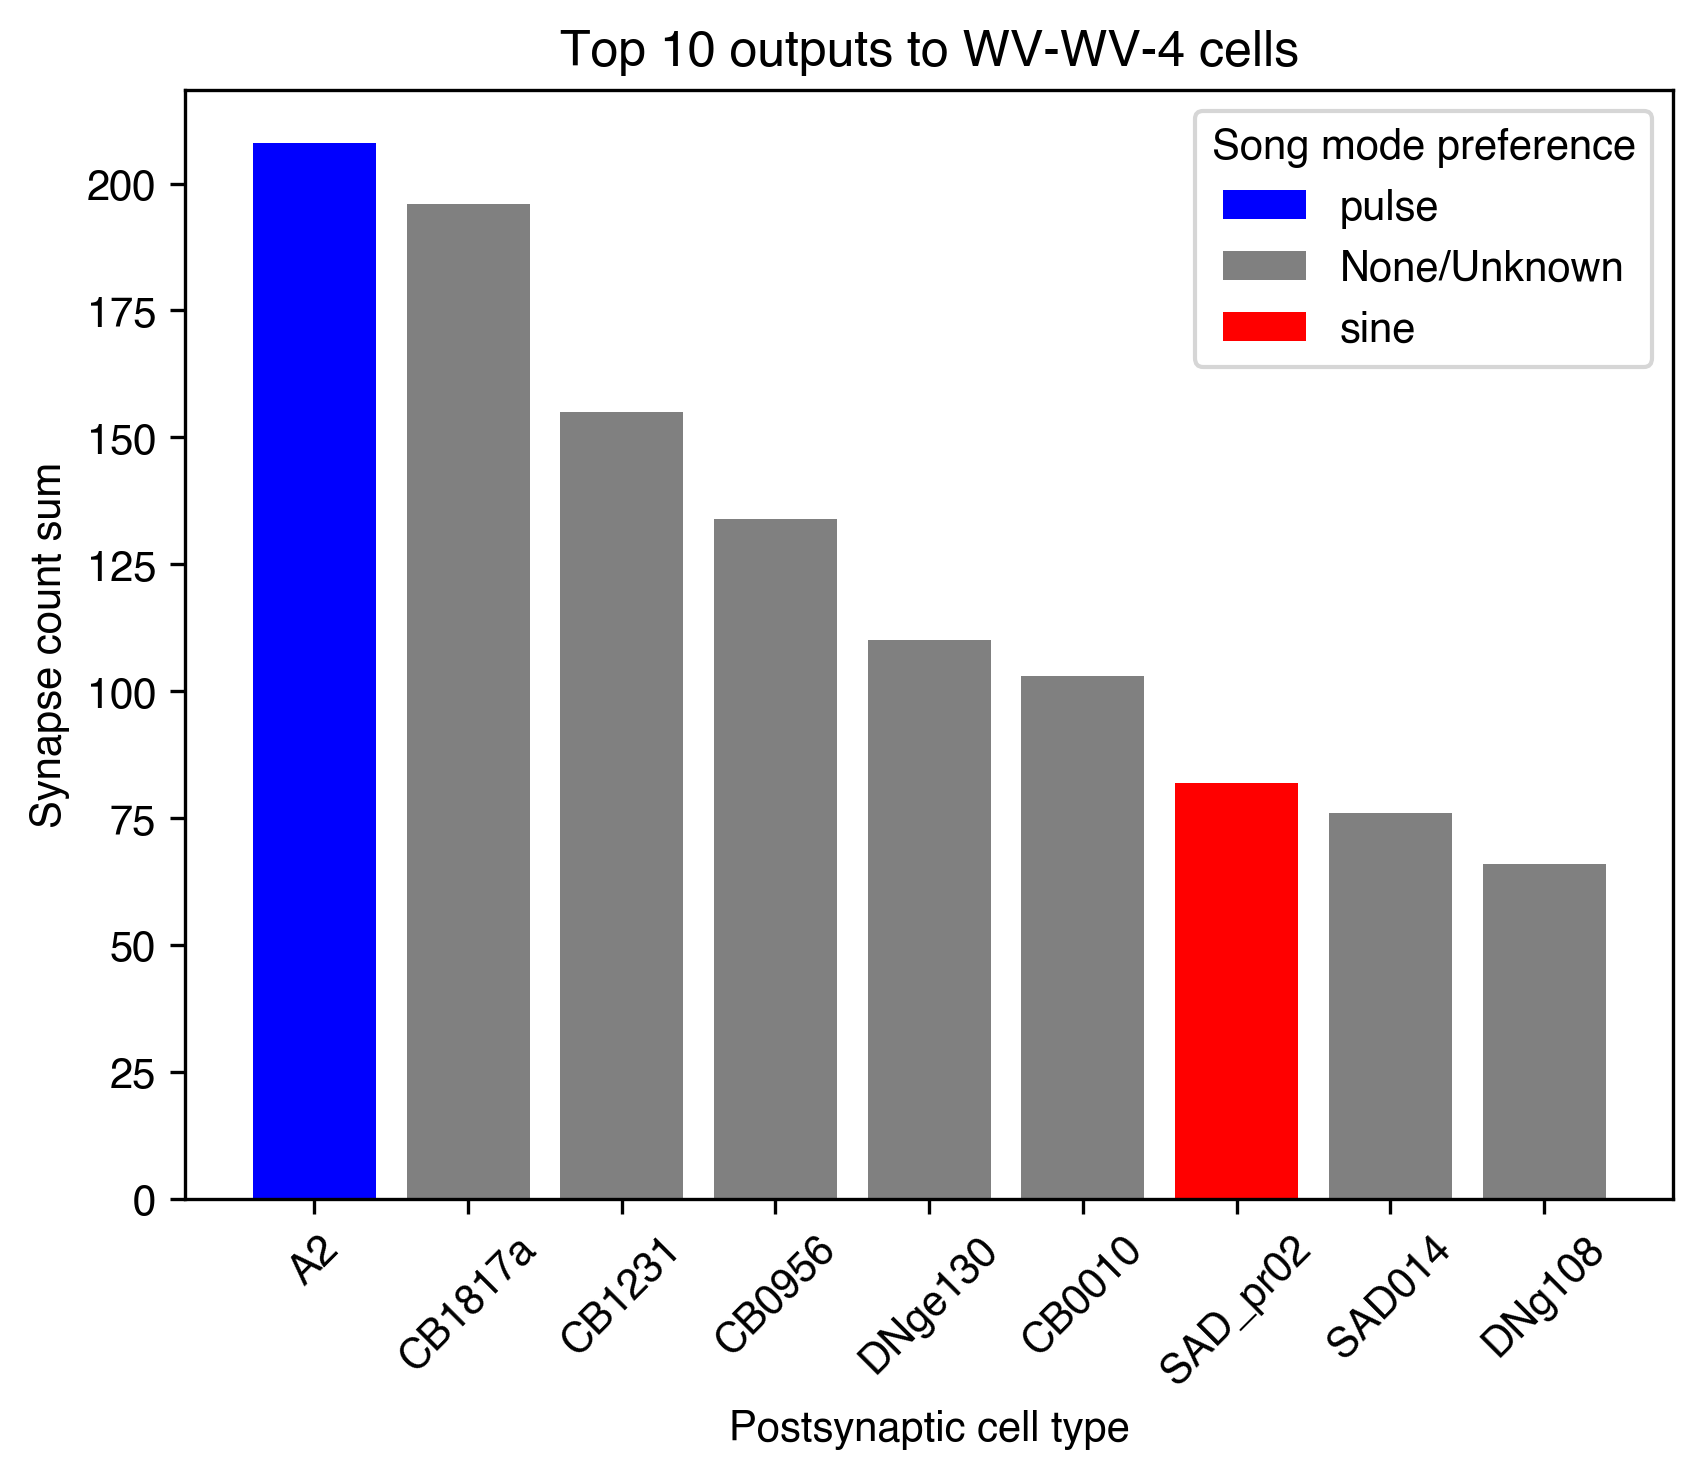

In [81]:
#turn into color coded bar chart
fig, ax = plt.subplots()

color_map = {'intermediate':'purple', 'pulse':'blue', 'sine':'red', 'None/Unknown':'grey'}
seen_labels = set()

for i, row in wvwv4_t10outputs.iterrows():
    preferences = row['pref_post']
    color = color_map[preferences]

    label = preferences if preferences not in seen_labels else None
    seen_labels.add(preferences)

    ax.bar(row['type_post'], row['syn_count'], color=color, label=label)

ax.set_ylabel('Synapse count sum')
ax.set_xlabel('Postsynaptic cell type')
ax.set_title('Top 10 outputs to WV-WV-4 cells')
ax.legend(title = 'Song mode preference')
plt.xticks(rotation=45)

### By song mode preference

In [82]:
wvwv4_inputs_prefs = wvwv4_inputs.groupby(['pref_pre'], as_index=False, dropna=False)[['syn_count']].sum()
wvwv4_inputs_prefs

pref_pre  syn_count
0  intermediate        306
1         pulse        246
2           NaN       1277

Text(0.5, 1.0, 'Song mode preferences of WV-WV-4 inputs')

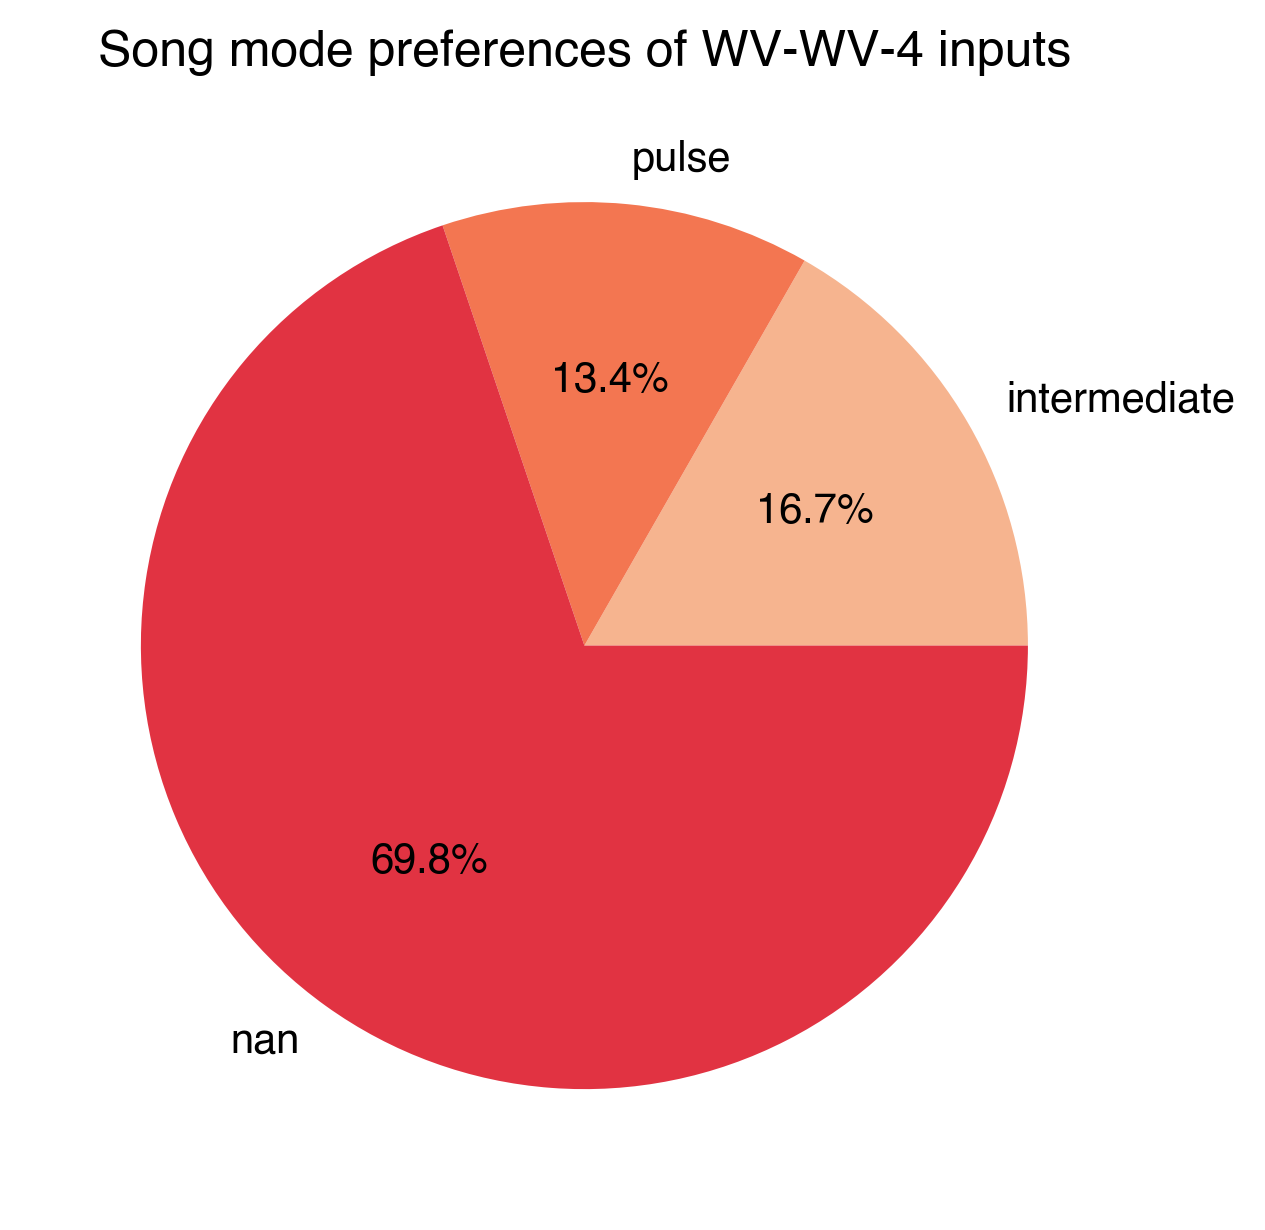

In [83]:
#directly make pie plot of preferences

plt.pie(wvwv4_inputs_prefs['syn_count'],
        labels = wvwv4_inputs_prefs['pref_pre'],
        autopct = '%1.1f%%',
        colors = seaborn.color_palette('rocket_r')
        )
plt.title('Song mode preferences of WV-WV-4 inputs')


In [84]:
wvwv4_outputs_prefs = wvwv4_outputs.groupby(['pref_post'], as_index=False, dropna=False)[['syn_count']].sum()
wvwv4_outputs_prefs

pref_post  syn_count
0  intermediate         48
1         pulse        234
2          sine         92
3           NaN       1890

Text(0.5, 1.0, 'Song mode preferences of WV-WV-4 outputs')

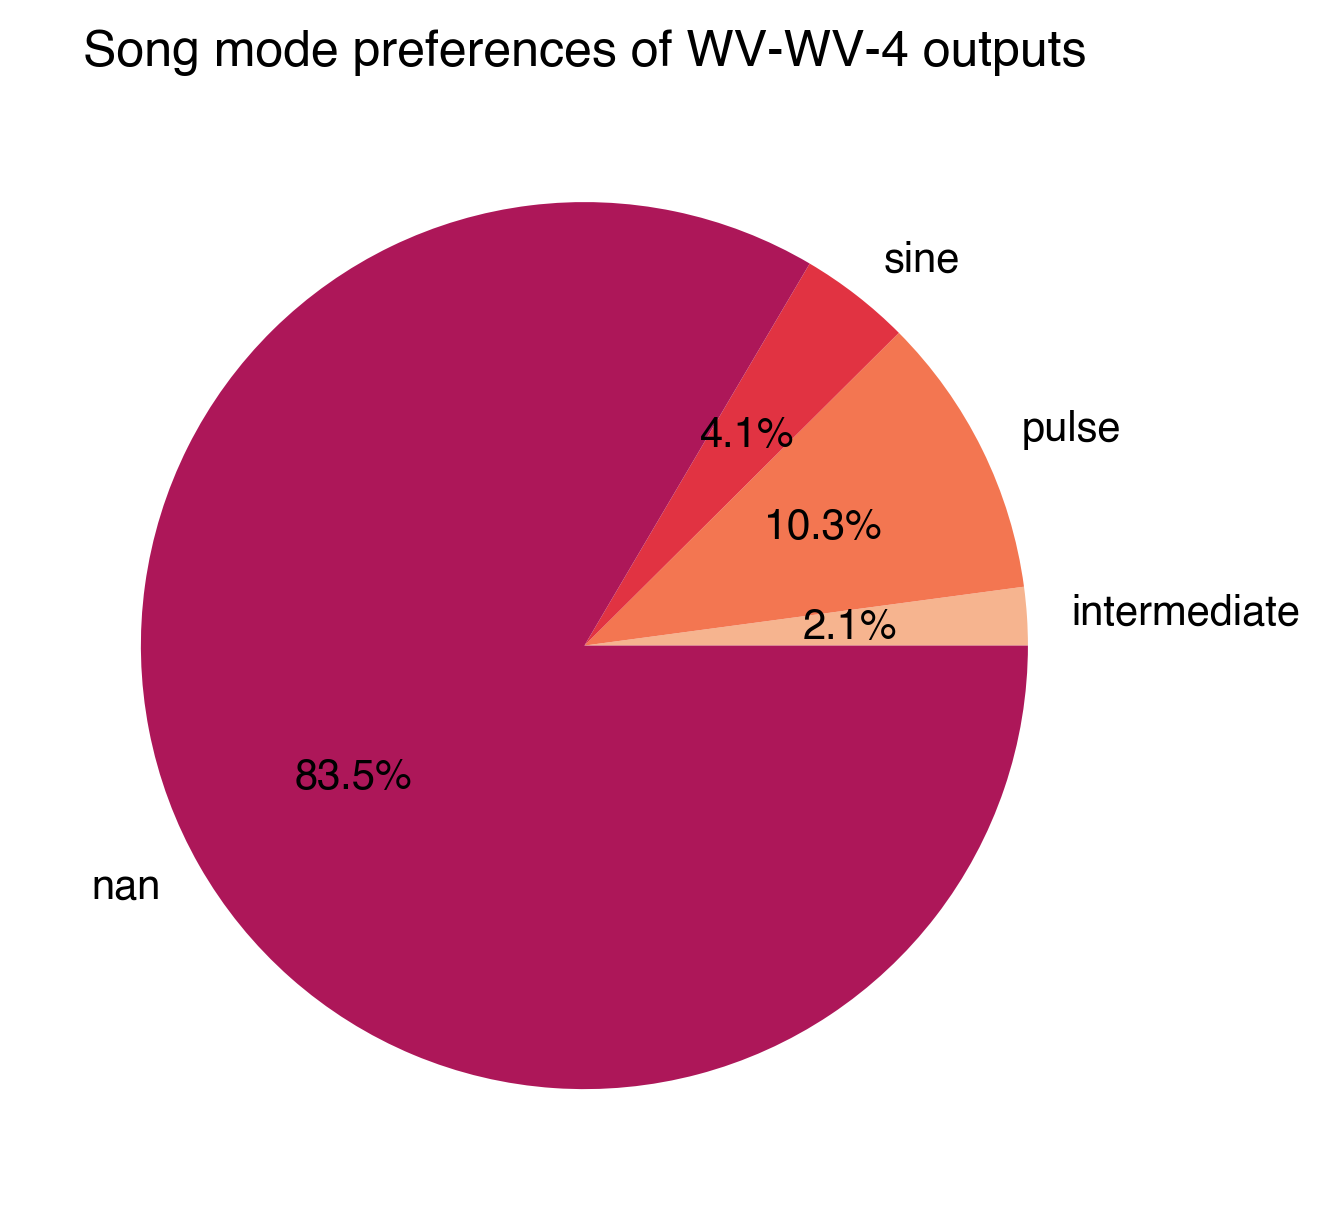

In [85]:
plt.pie(wvwv4_outputs_prefs['syn_count'],
        labels = wvwv4_outputs_prefs['pref_post'],
        autopct = '%1.1f%%',
        colors = seaborn.color_palette('rocket_r')
        )
plt.title('Song mode preferences of WV-WV-4 outputs')


# More general analysis

### Heatmaps including all cell types with summed synapse count

For the next two figures, I am finding the top 10 inputs and outputs of each subtype individually, before joining them to make a heatmap. This differs from the heatmap above, where I simply took the top 10 inputs and outputs of all wv-wv cells as one group (so certain subtypes were excluded from those figures)

In [87]:
#join together t10 inputs

wvwv_indiv_t10inputs = pd.concat([wvwv1_t10inputs, wvwv2_t10inputs, wvwv3_t10inputs, wvwv4_t10inputs])
wvwv_t10input_conns = wvwv_inputs_grouped[wvwv_inputs_grouped['type_pre'].isin(wvwv_indiv_t10inputs['type_pre'].tolist())]
wvwv_t10inputs_pivoted = wvwv_t10input_conns.pivot_table(
    values = 'syn_count',
    index = 'type_pre',
    columns = 'type_post'
)
wvwv_t10inputs_pivoted

type_post    WV-WV-1  WV-WV-2  WV-WV-3  WV-WV-4
type_pre                                       
A2              29.0    132.0     41.0    164.0
AN_GNG_198       NaN      5.0      NaN     51.0
AN_multi_33    285.0      5.0    114.0     28.0
AN_multi_60      NaN    152.0    133.0     53.0
AVLP083        347.0     69.0      7.0      NaN
AVLP_pr01      315.0     23.0      NaN      NaN
B1            5594.0   5601.0   2669.0     82.0
CB0261           NaN    111.0    683.0      5.0
CB0307          31.0     71.0    395.0      NaN
CB0466          25.0    293.0      NaN     16.0
CB0591         418.0     17.0      NaN      NaN
CB1538         647.0    257.0    265.0      NaN
CB1557          15.0    343.0      NaN      8.0
CB1817a         49.0     92.0     61.0    144.0
CB1948         285.0    717.0    854.0      NaN
CB2238          22.0    496.0    278.0      NaN
CB2545         100.0    463.0      NaN      7.0
CB3655           NaN    386.0    145.0      NaN
DNg24          600.0     43.0    515.0      NaN
DNg40           14.0      5.0   1130.0     25.0
DNge130        140.0    254.0      NaN     51.0
DNp55            NaN      7.0    146.0     46.0
DNpe025          NaN     22.0     36.0    112.0
JO-A          2990.0    296.0   3485.0     55.0
JO-B           247.0    309.0    588.0     13.0
SAD_pr02        94.0     43.0    520.0      NaN
WED-VLP        496.0      NaN      5.0      5.0
WED_pr02       895.0   1182.0     47.0    301.0
WV-WV-2        120.0    410.0    195.0      NaN
WV-WV-3         56.0    107.0    931.0      NaN

In [88]:
#do the same thing but for outputs
wvwv_indiv_t10outputs = pd.concat([wvwv1_t10outputs, wvwv2_t10outputs, wvwv3_t10outputs, wvwv4_t10outputs])
wvwv_t10output_conns = wvwv_outputs_grouped[wvwv_outputs_grouped['type_post'].isin(wvwv_indiv_t10outputs['type_post'].tolist())]
wvwv_t10outputs_pivoted = wvwv_t10output_conns.pivot_table(
    values = 'syn_count',
    index = 'type_post',
    columns = 'type_pre'
)
wvwv_t10outputs_pivoted


type_pre   WV-WV-1  WV-WV-2  WV-WV-3  WV-WV-4
type_post                                    
A2             5.0      7.0     64.0    208.0
AMMC-A1       10.0      NaN   1381.0      NaN
AVLP_pr01    965.0      NaN      NaN      NaN
B1           157.0    108.0    468.0     26.0
CB0010         NaN    297.0     41.0    103.0
CB0533       215.0    873.0     50.0     32.0
CB0956        85.0      6.0    376.0    134.0
CB1074         6.0    434.0     29.0      NaN
CB1110       523.0    401.0      NaN     30.0
CB1206       506.0    180.0      NaN     24.0
CB1231        33.0    481.0     42.0    155.0
CB1538       818.0    212.0    316.0     56.0
CB1557       470.0     38.0     92.0      NaN
CB1760        34.0   1101.0     34.0      NaN
CB1817a        6.0      NaN    109.0    196.0
CB1948       482.0   1044.0    366.0     29.0
CB2238        41.0    891.0    303.0     14.0
CB2305        26.0    408.0    215.0      5.0
CB2545       492.0    479.0      NaN      NaN
DNg108        60.0    247.0    182.0     66.0
DNg24        220.0      NaN    718.0      6.0
DNge130       28.0    141.0    312.0    110.0
DNp01          NaN      NaN   1372.0      NaN
DNp02         20.0     37.0   1136.0     17.0
DNp11         25.0      6.0    381.0      NaN
SAD014         NaN     57.0     14.0     76.0
SAD_pr02      39.0     93.0    124.0     82.0
WED-VLP     3189.0     69.0      NaN     28.0
WED_pr02    2011.0   2243.0      5.0      NaN
WV-WV-2      177.0    410.0    107.0      NaN
WV-WV-3      118.0    195.0    931.0     26.0

Text(289.16666666666663, 0.5, 'input cell types')

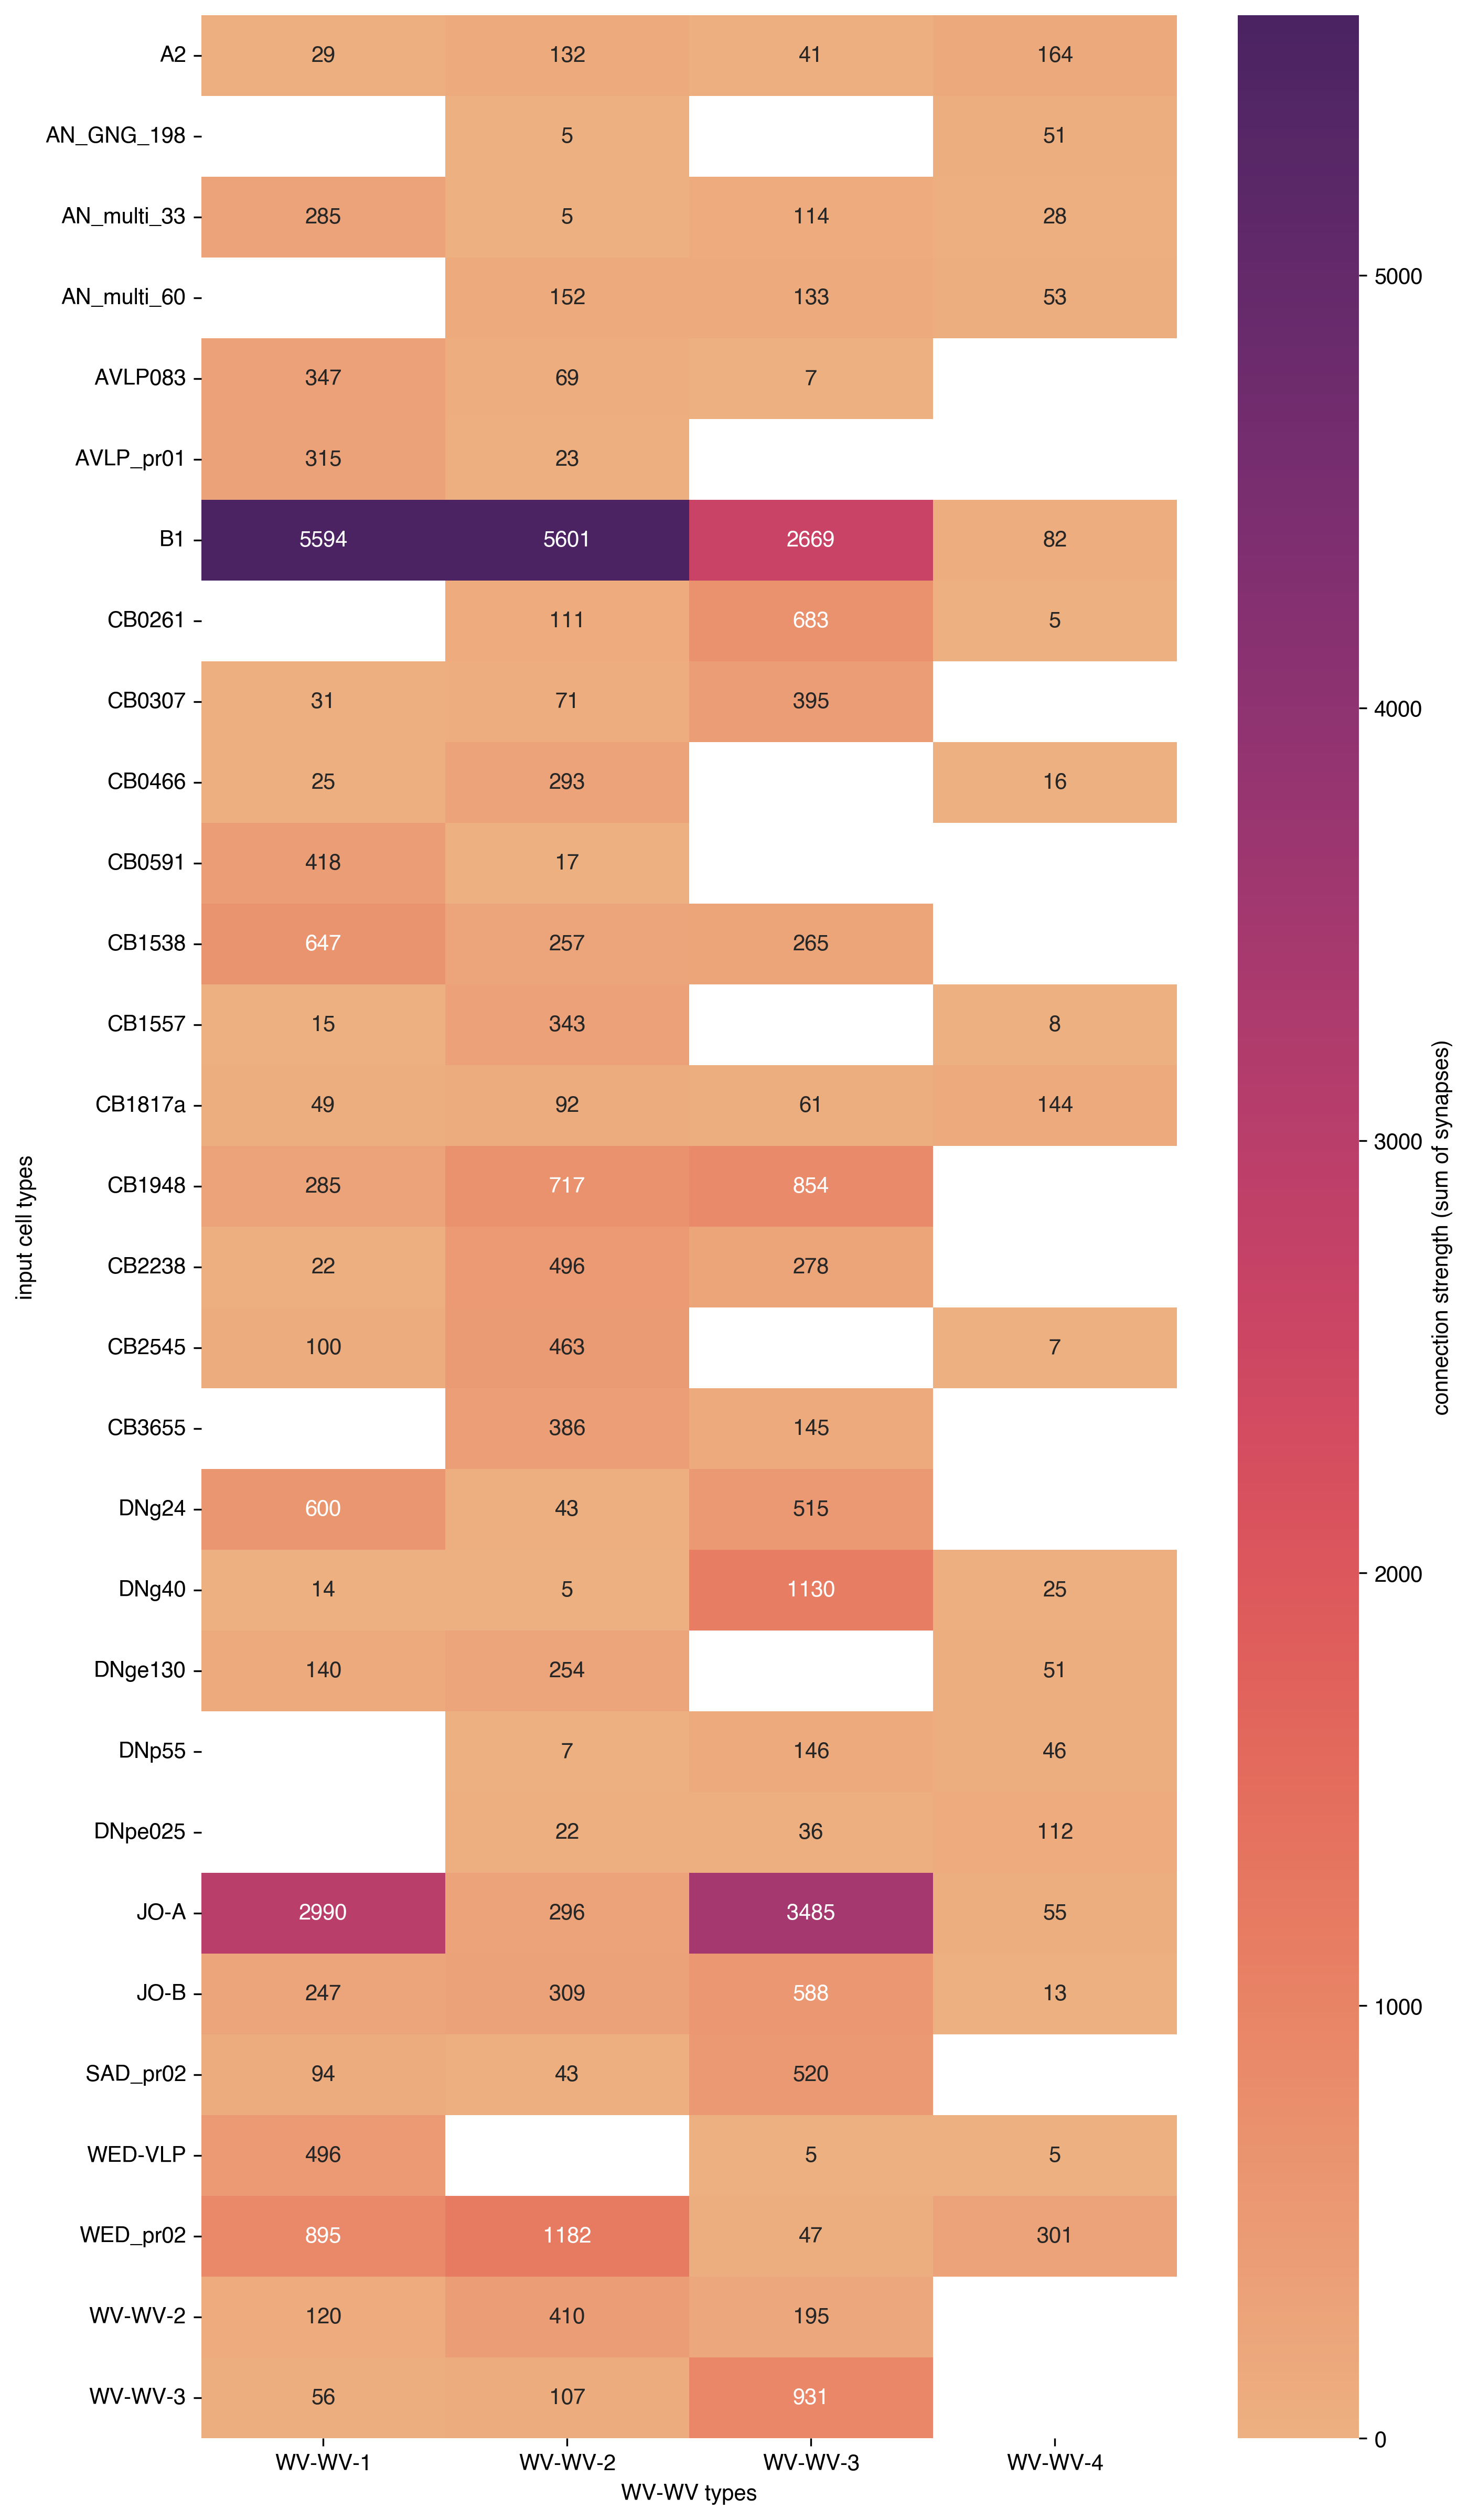

In [89]:
#heatmap for inputs

fig = plt.figure(figsize=(10, 20))
seaborn.heatmap(wvwv_t10inputs_pivoted, vmin=0, 
                annot=True,
                cmap=seaborn.color_palette('flare', as_cmap=True),
                fmt = 'g',
                cbar_kws={'label': 'connection strength (sum of synapses)'},
                )
plt.xlabel('WV-WV types')
plt.ylabel('input cell types')

Text(289.16666666666663, 0.5, 'output cell types')

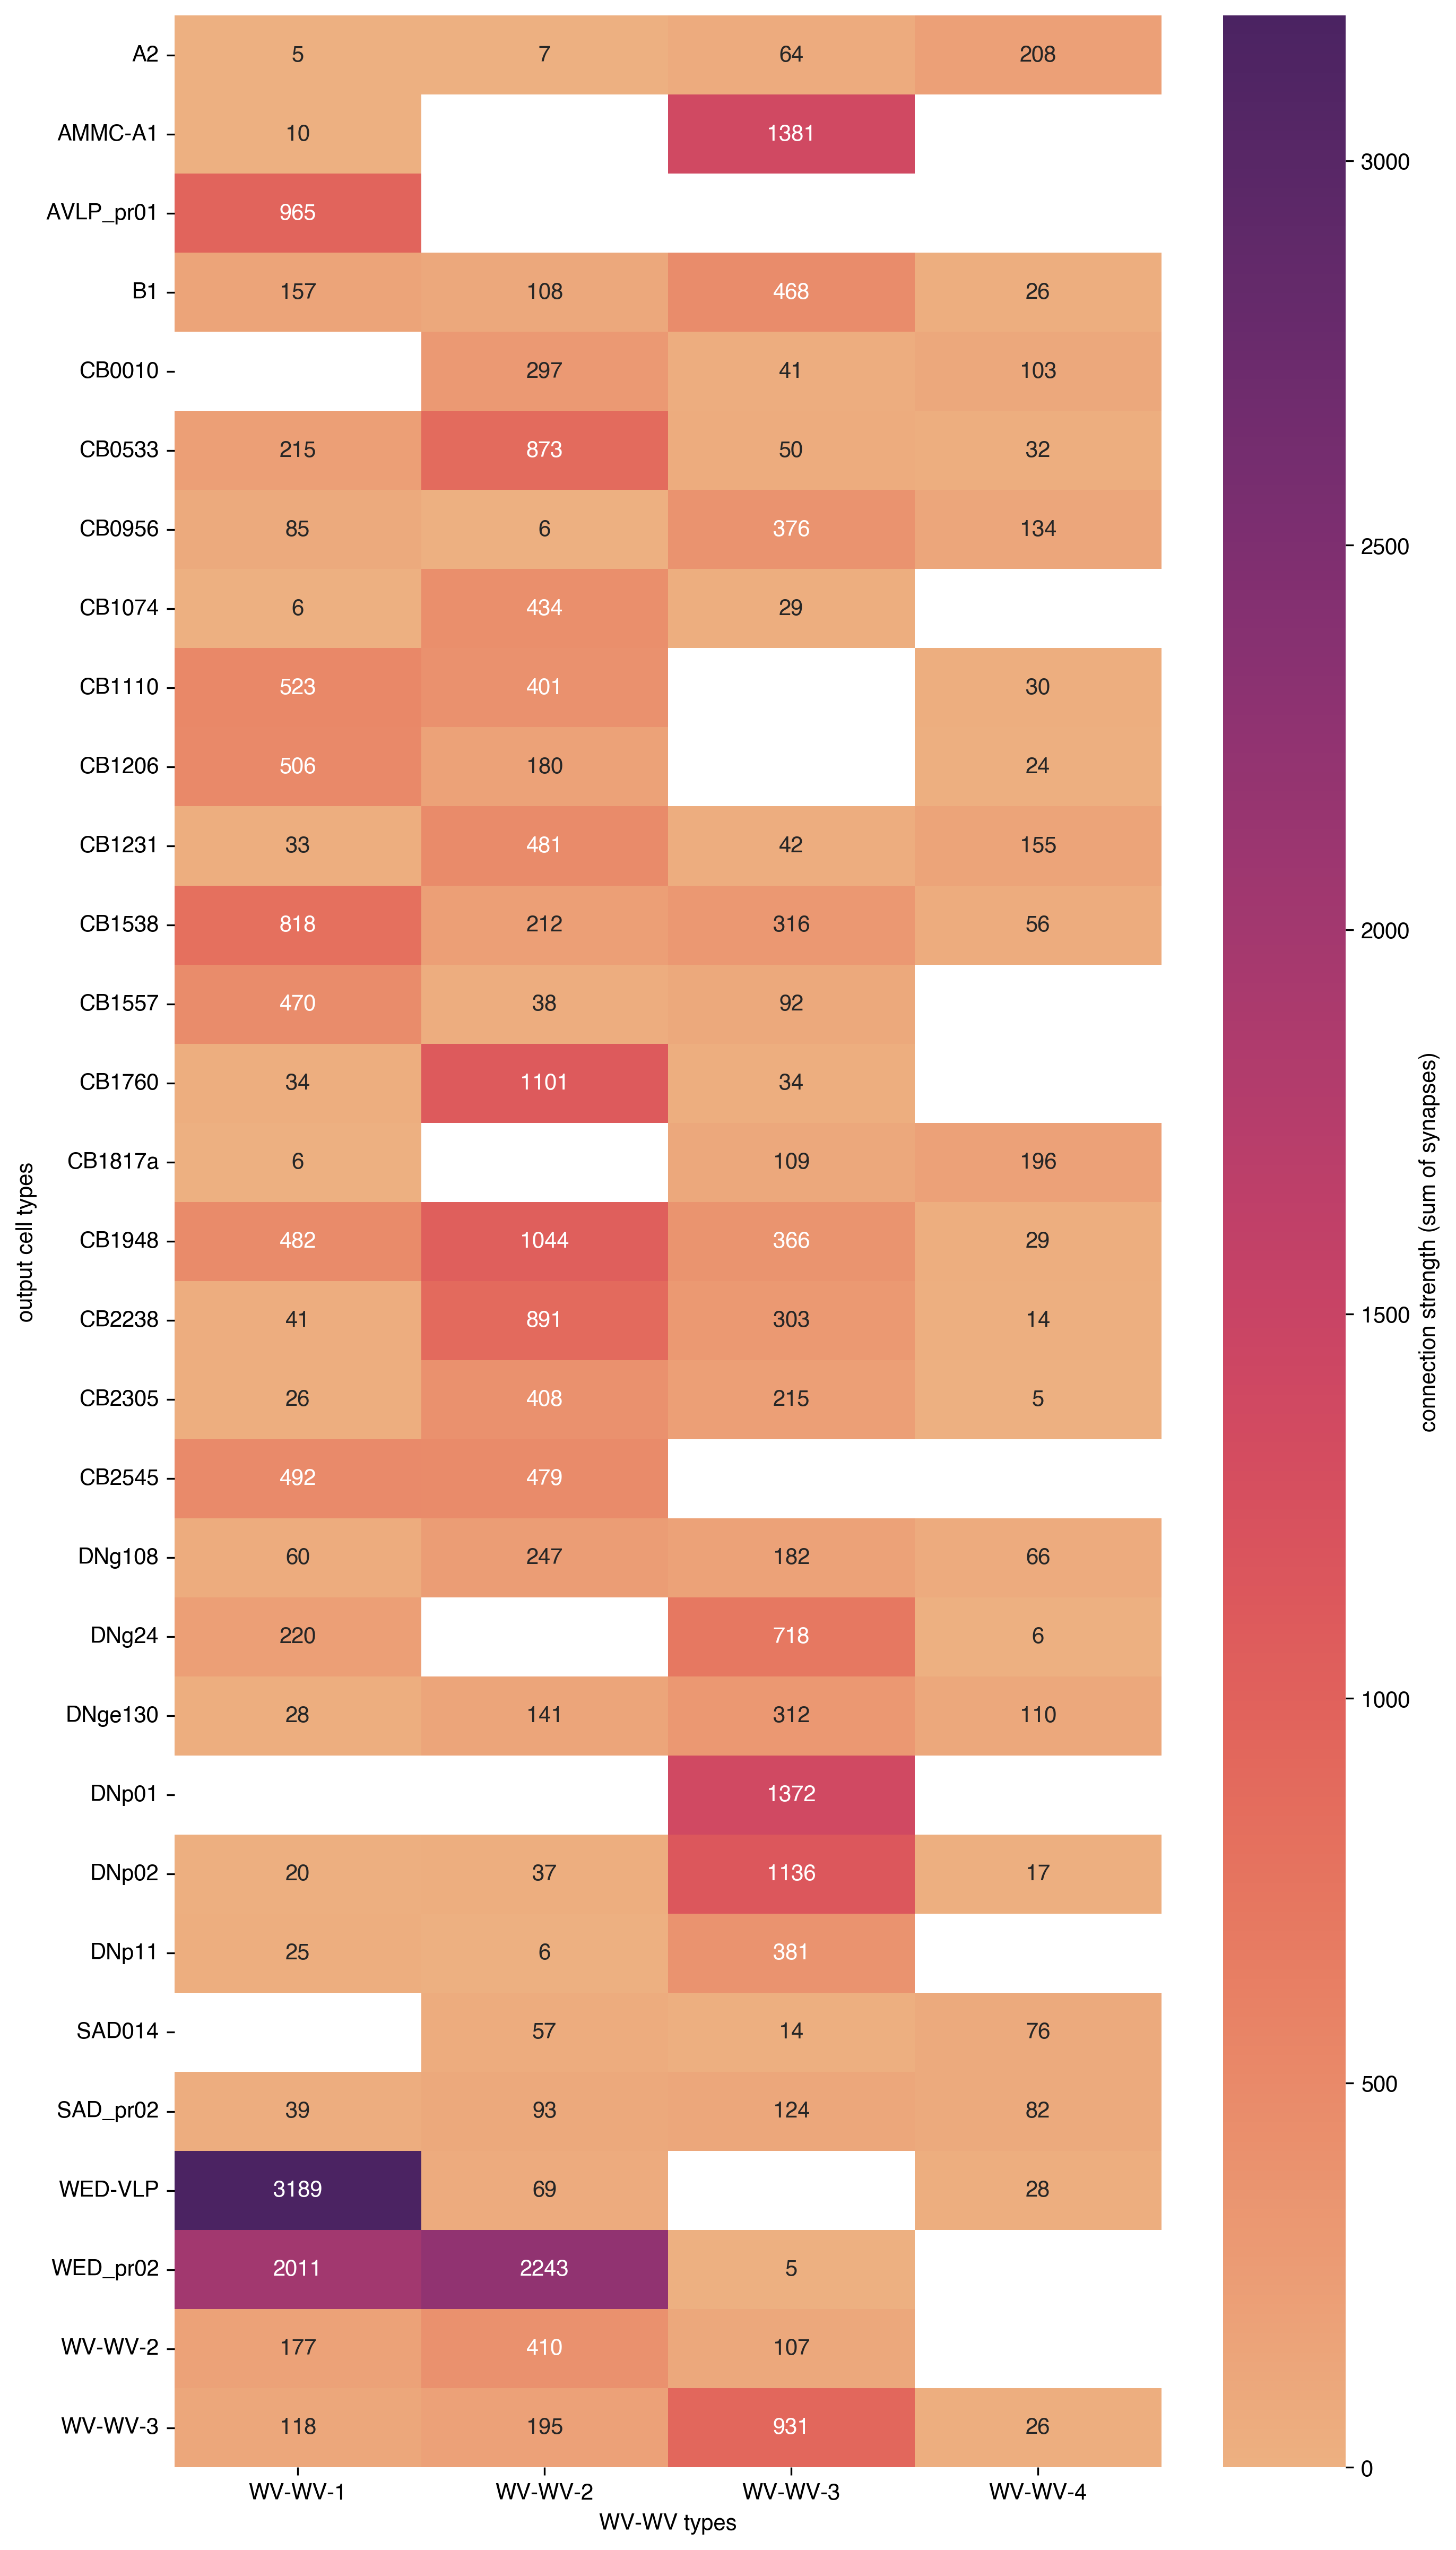

In [90]:
#heatmap for outputs

fig = plt.figure(figsize=(10, 20))
seaborn.heatmap(wvwv_t10outputs_pivoted, vmin=0, 
                annot=True,
                cmap=seaborn.color_palette('flare', as_cmap=True),
                fmt = 'g',
                cbar_kws={'label': 'connection strength (sum of synapses)'},
                )
plt.xlabel('WV-WV types')
plt.ylabel('output cell types')

# Looking at how WV-WV cells interact between input/output mode preferences

How do sine/pulse/intermediate projections travel through wv-wvs?

In [91]:
#goal: create df where one row is two connections: input going into wv-wv and output going from wv-wv
#should look like this: input root id and cell type | input preference | nt type | wv-wv | output root id and cell type | output preference

wvwv_output_modeprefs_indiv = wvwv_outputs[['pre_root_id', 'type_pre', 'pref_post', 'post_root_id', 'nt_type', 'syn_count']].dropna().rename(columns={'pre_root_id':'prewvwv_root_id'})
wvwv_output_modeprefs_indiv

prewvwv_root_id type_pre     pref_post        post_root_id  \
4577     720575940623322877  WV-WV-1  intermediate  720575940630258003   
11583    720575940623322877  WV-WV-1  intermediate  720575940628267264   
15866    720575940623322877  WV-WV-1  intermediate  720575940621540586   
16147    720575940622123981  WV-WV-1          sine  720575940631425965   
16893    720575940623322877  WV-WV-1  intermediate  720575940640507763   
...                     ...      ...           ...                 ...   
3671314  720575940632945177  WV-WV-3         pulse  720575940620980323   
3699238  720575940634571383  WV-WV-2          sine  720575940624314468   
3699399  720575940634571383  WV-WV-2          sine  720575940608432760   
3711079  720575940623322877  WV-WV-1          sine  720575940627642818   
3711087  720575940623322877  WV-WV-1         pulse  720575940622254375   

        nt_type  syn_count  
4577       GABA        203  
11583      GABA        148  
15866      GABA        131  
16147      GABA        130  
16893      GABA        127  
...         ...        ...  
3671314    GABA          5  
3699238    GABA          5  
3699399    GABA          5  
3711079    GABA          5  
3711087    GABA          5  

[359 rows x 6 columns]

In [92]:
#check for potential repeats
wvwv_output_modeprefs_indiv.drop_duplicates(subset = ['prewvwv_root_id', 'post_root_id']) #same no. of rows therefore og df is not producing duplicates
wvwv_output_modeprefs_indiv

prewvwv_root_id type_pre     pref_post        post_root_id  \
4577     720575940623322877  WV-WV-1  intermediate  720575940630258003   
11583    720575940623322877  WV-WV-1  intermediate  720575940628267264   
15866    720575940623322877  WV-WV-1  intermediate  720575940621540586   
16147    720575940622123981  WV-WV-1          sine  720575940631425965   
16893    720575940623322877  WV-WV-1  intermediate  720575940640507763   
...                     ...      ...           ...                 ...   
3671314  720575940632945177  WV-WV-3         pulse  720575940620980323   
3699238  720575940634571383  WV-WV-2          sine  720575940624314468   
3699399  720575940634571383  WV-WV-2          sine  720575940608432760   
3711079  720575940623322877  WV-WV-1          sine  720575940627642818   
3711087  720575940623322877  WV-WV-1         pulse  720575940622254375   

        nt_type  syn_count  
4577       GABA        203  
11583      GABA        148  
15866      GABA        131  
16147      GABA        130  
16893      GABA        127  
...         ...        ...  
3671314    GABA          5  
3699238    GABA          5  
3699399    GABA          5  
3711079    GABA          5  
3711087    GABA          5  

[359 rows x 6 columns]

In [93]:
#to prevent automatic scientific notation after merging, change pre and post root id columns to str values

wvwv_output_modeprefs_indiv = wvwv_output_modeprefs_indiv.astype(str)

#but keep syn_counts as int instead of string
wvwv_output_modeprefs_indiv[['syn_count']] = wvwv_output_modeprefs_indiv[['syn_count']].astype(int)

wvwv_output_modeprefs_indiv

prewvwv_root_id type_pre     pref_post        post_root_id  \
4577     720575940623322877  WV-WV-1  intermediate  720575940630258003   
11583    720575940623322877  WV-WV-1  intermediate  720575940628267264   
15866    720575940623322877  WV-WV-1  intermediate  720575940621540586   
16147    720575940622123981  WV-WV-1          sine  720575940631425965   
16893    720575940623322877  WV-WV-1  intermediate  720575940640507763   
...                     ...      ...           ...                 ...   
3671314  720575940632945177  WV-WV-3         pulse  720575940620980323   
3699238  720575940634571383  WV-WV-2          sine  720575940624314468   
3699399  720575940634571383  WV-WV-2          sine  720575940608432760   
3711079  720575940623322877  WV-WV-1          sine  720575940627642818   
3711087  720575940623322877  WV-WV-1         pulse  720575940622254375   

        nt_type  syn_count  
4577       GABA        203  
11583      GABA        148  
15866      GABA        131  
16147      GABA        130  
16893      GABA        127  
...         ...        ...  
3671314    GABA          5  
3699238    GABA          5  
3699399    GABA          5  
3711079    GABA          5  
3711087    GABA          5  

[359 rows x 6 columns]

In [94]:
#check to make sure

wvwv_output_modeprefs_indiv.dtypes

prewvwv_root_id    object
type_pre           object
pref_post          object
post_root_id       object
nt_type            object
syn_count           int64
dtype: object

In [95]:
wvwv_input_modeprefs_indiv = wvwv_inputs[['pre_root_id', 'pref_pre', 'type_post', 'post_root_id', 'nt_type', 'syn_count']].dropna().rename(columns={'post_root_id':'postwvwv_root_id'})
wvwv_input_modeprefs_indiv

pre_root_id      pref_pre type_post    postwvwv_root_id  \
10357    720575940622254375         pulse   WV-WV-1  720575940623322877   
10924    720575940627263375         pulse   WV-WV-3  720575940632945177   
11707    720575940622097959         pulse   WV-WV-1  720575940623322877   
12090    720575940607188036         pulse   WV-WV-1  720575940623322877   
12863    720575940604839200         pulse   WV-WV-1  720575940635330204   
...                     ...           ...       ...                 ...   
3651898  720575940632829507         pulse   WV-WV-3  720575940632945177   
3662429  720575940624872179         pulse   WV-WV-2  720575940621148660   
3666233  720575940633044634  intermediate   WV-WV-2  720575940620835327   
3699630  720575940622577336         pulse   WV-WV-2  720575940620835327   
3709886  720575940623292713          sine   WV-WV-2  720575940634571383   

        nt_type  syn_count  
10357       ACH        154  
10924       ACH        151  
11707       ACH        147  
12090       ACH        145  
12863       ACH        142  
...         ...        ...  
3651898     ACH          5  
3662429     ACH          5  
3666233    GABA          5  
3699630     ACH          5  
3709886    GABA          5  

[657 rows x 6 columns]

In [96]:
wvwv_input_modeprefs_indiv.drop_duplicates(subset=['pre_root_id', 'postwvwv_root_id']) #also same number of rows

pre_root_id      pref_pre type_post    postwvwv_root_id  \
10357    720575940622254375         pulse   WV-WV-1  720575940623322877   
10924    720575940627263375         pulse   WV-WV-3  720575940632945177   
11707    720575940622097959         pulse   WV-WV-1  720575940623322877   
12090    720575940607188036         pulse   WV-WV-1  720575940623322877   
12863    720575940604839200         pulse   WV-WV-1  720575940635330204   
...                     ...           ...       ...                 ...   
3651898  720575940632829507         pulse   WV-WV-3  720575940632945177   
3662429  720575940624872179         pulse   WV-WV-2  720575940621148660   
3666233  720575940633044634  intermediate   WV-WV-2  720575940620835327   
3699630  720575940622577336         pulse   WV-WV-2  720575940620835327   
3709886  720575940623292713          sine   WV-WV-2  720575940634571383   

        nt_type  syn_count  
10357       ACH        154  
10924       ACH        151  
11707       ACH        147  
12090       ACH        145  
12863       ACH        142  
...         ...        ...  
3651898     ACH          5  
3662429     ACH          5  
3666233    GABA          5  
3699630     ACH          5  
3709886    GABA          5  

[657 rows x 6 columns]

In [97]:
#also change input df to all str so that merge can match
wvwv_input_modeprefs_indiv = wvwv_input_modeprefs_indiv.astype(str)

wvwv_input_modeprefs_indiv[['syn_count']] = wvwv_input_modeprefs_indiv[['syn_count']].astype(int)

wvwv_input_modeprefs_indiv

pre_root_id      pref_pre type_post    postwvwv_root_id  \
10357    720575940622254375         pulse   WV-WV-1  720575940623322877   
10924    720575940627263375         pulse   WV-WV-3  720575940632945177   
11707    720575940622097959         pulse   WV-WV-1  720575940623322877   
12090    720575940607188036         pulse   WV-WV-1  720575940623322877   
12863    720575940604839200         pulse   WV-WV-1  720575940635330204   
...                     ...           ...       ...                 ...   
3651898  720575940632829507         pulse   WV-WV-3  720575940632945177   
3662429  720575940624872179         pulse   WV-WV-2  720575940621148660   
3666233  720575940633044634  intermediate   WV-WV-2  720575940620835327   
3699630  720575940622577336         pulse   WV-WV-2  720575940620835327   
3709886  720575940623292713          sine   WV-WV-2  720575940634571383   

        nt_type  syn_count  
10357       ACH        154  
10924       ACH        151  
11707       ACH        147  
12090       ACH        145  
12863       ACH        142  
...         ...        ...  
3651898     ACH          5  
3662429     ACH          5  
3666233    GABA          5  
3699630     ACH          5  
3709886    GABA          5  

[657 rows x 6 columns]

In [98]:
#check like we did for outputs

wvwv_input_modeprefs_indiv.dtypes

pre_root_id         object
pref_pre            object
type_post           object
postwvwv_root_id    object
nt_type             object
syn_count            int64
dtype: object

In [99]:
wvwv_modeprefs_indiv_merged = wvwv_input_modeprefs_indiv.merge(
    wvwv_output_modeprefs_indiv,
    left_on = 'postwvwv_root_id',
    right_on = 'prewvwv_root_id',
    how = 'left',
)
wvwv_modeprefs_indiv_merged

pre_root_id pref_pre type_post    postwvwv_root_id nt_type_x  \
0      720575940622254375    pulse   WV-WV-1  720575940623322877       ACH   
1      720575940622254375    pulse   WV-WV-1  720575940623322877       ACH   
2      720575940622254375    pulse   WV-WV-1  720575940623322877       ACH   
3      720575940622254375    pulse   WV-WV-1  720575940623322877       ACH   
4      720575940622254375    pulse   WV-WV-1  720575940623322877       ACH   
...                   ...      ...       ...                 ...       ...   
18151  720575940623292713     sine   WV-WV-2  720575940634571383      GABA   
18152  720575940623292713     sine   WV-WV-2  720575940634571383      GABA   
18153  720575940623292713     sine   WV-WV-2  720575940634571383      GABA   
18154  720575940623292713     sine   WV-WV-2  720575940634571383      GABA   
18155  720575940623292713     sine   WV-WV-2  720575940634571383      GABA   

       syn_count_x     prewvwv_root_id type_pre     pref_post  \
0              154  720575940623322877  WV-WV-1  intermediate   
1              154  720575940623322877  WV-WV-1  intermediate   
2              154  720575940623322877  WV-WV-1  intermediate   
3              154  720575940623322877  WV-WV-1  intermediate   
4              154  720575940623322877  WV-WV-1  intermediate   
...            ...                 ...      ...           ...   
18151            5  720575940634571383  WV-WV-2  intermediate   
18152            5  720575940634571383  WV-WV-2         pulse   
18153            5  720575940634571383  WV-WV-2         pulse   
18154            5  720575940634571383  WV-WV-2          sine   
18155            5  720575940634571383  WV-WV-2          sine   

             post_root_id nt_type_y  syn_count_y  
0      720575940630258003      GABA        203.0  
1      720575940628267264      GABA        148.0  
2      720575940621540586      GABA        131.0  
3      720575940640507763      GABA        127.0  
4      720575940635981742      GABA        120.0  
...                   ...       ...          ...  
18151  720575940630749523      GABA         16.0  
18152  720575940618409797      GABA         10.0  
18153  720575940621043753      GABA          6.0  
18154  720575940624314468      GABA          5.0  
18155  720575940608432760      GABA          5.0  

[18156 rows x 12 columns]

In [100]:
#are there any duplicates?

wvwv_modeprefs_indiv_merged.drop_duplicates(subset=['pre_root_id', 'postwvwv_root_id', 'post_root_id']) #this makes sure that each row is a unqiue presyn -> wvwv -> postsyn two hop connection

pre_root_id pref_pre type_post    postwvwv_root_id nt_type_x  \
0      720575940622254375    pulse   WV-WV-1  720575940623322877       ACH   
1      720575940622254375    pulse   WV-WV-1  720575940623322877       ACH   
2      720575940622254375    pulse   WV-WV-1  720575940623322877       ACH   
3      720575940622254375    pulse   WV-WV-1  720575940623322877       ACH   
4      720575940622254375    pulse   WV-WV-1  720575940623322877       ACH   
...                   ...      ...       ...                 ...       ...   
18151  720575940623292713     sine   WV-WV-2  720575940634571383      GABA   
18152  720575940623292713     sine   WV-WV-2  720575940634571383      GABA   
18153  720575940623292713     sine   WV-WV-2  720575940634571383      GABA   
18154  720575940623292713     sine   WV-WV-2  720575940634571383      GABA   
18155  720575940623292713     sine   WV-WV-2  720575940634571383      GABA   

       syn_count_x     prewvwv_root_id type_pre     pref_post  \
0              154  720575940623322877  WV-WV-1  intermediate   
1              154  720575940623322877  WV-WV-1  intermediate   
2              154  720575940623322877  WV-WV-1  intermediate   
3              154  720575940623322877  WV-WV-1  intermediate   
4              154  720575940623322877  WV-WV-1  intermediate   
...            ...                 ...      ...           ...   
18151            5  720575940634571383  WV-WV-2  intermediate   
18152            5  720575940634571383  WV-WV-2         pulse   
18153            5  720575940634571383  WV-WV-2         pulse   
18154            5  720575940634571383  WV-WV-2          sine   
18155            5  720575940634571383  WV-WV-2          sine   

             post_root_id nt_type_y  syn_count_y  
0      720575940630258003      GABA        203.0  
1      720575940628267264      GABA        148.0  
2      720575940621540586      GABA        131.0  
3      720575940640507763      GABA        127.0  
4      720575940635981742      GABA        120.0  
...                   ...       ...          ...  
18151  720575940630749523      GABA         16.0  
18152  720575940618409797      GABA         10.0  
18153  720575940621043753      GABA          6.0  
18154  720575940624314468      GABA          5.0  
18155  720575940608432760      GABA          5.0  

[18156 rows x 12 columns]

In [101]:
wvwv_pre_post_prefs = wvwv_modeprefs_indiv_merged.drop(columns = ['pre_root_id', 'type_pre', 'nt_type_y', 'post_root_id', 'postwvwv_root_id', 'prewvwv_root_id'], axis=1).rename(columns={
    'type_post':'wvwv_type',
    'nt_type_x':'nt_type_pre',
    'syn_count_x':'input_syn_count',
    'syn_count_y': 'output_syn_count'
})
wvwv_pre_post_prefs

pref_pre wvwv_type nt_type_pre  input_syn_count     pref_post  \
0        pulse   WV-WV-1         ACH              154  intermediate   
1        pulse   WV-WV-1         ACH              154  intermediate   
2        pulse   WV-WV-1         ACH              154  intermediate   
3        pulse   WV-WV-1         ACH              154  intermediate   
4        pulse   WV-WV-1         ACH              154  intermediate   
...        ...       ...         ...              ...           ...   
18151     sine   WV-WV-2        GABA                5  intermediate   
18152     sine   WV-WV-2        GABA                5         pulse   
18153     sine   WV-WV-2        GABA                5         pulse   
18154     sine   WV-WV-2        GABA                5          sine   
18155     sine   WV-WV-2        GABA                5          sine   

       output_syn_count  
0                 203.0  
1                 148.0  
2                 131.0  
3                 127.0  
4                 120.0  
...                 ...  
18151              16.0  
18152              10.0  
18153               6.0  
18154               5.0  
18155               5.0  

[18156 rows x 6 columns]

In [102]:
prefconnsdf = wvwv_pre_post_prefs[['pref_pre', 'nt_type_pre', 'input_syn_count', 'wvwv_type', 'output_syn_count', 'pref_post']]
prefconnsdf

pref_pre nt_type_pre  input_syn_count wvwv_type  output_syn_count  \
0        pulse         ACH              154   WV-WV-1             203.0   
1        pulse         ACH              154   WV-WV-1             148.0   
2        pulse         ACH              154   WV-WV-1             131.0   
3        pulse         ACH              154   WV-WV-1             127.0   
4        pulse         ACH              154   WV-WV-1             120.0   
...        ...         ...              ...       ...               ...   
18151     sine        GABA                5   WV-WV-2              16.0   
18152     sine        GABA                5   WV-WV-2              10.0   
18153     sine        GABA                5   WV-WV-2               6.0   
18154     sine        GABA                5   WV-WV-2               5.0   
18155     sine        GABA                5   WV-WV-2               5.0   

          pref_post  
0      intermediate  
1      intermediate  
2      intermediate  
3      intermediate  
4      intermediate  
...             ...  
18151  intermediate  
18152         pulse  
18153         pulse  
18154          sine  
18155          sine  

[18156 rows x 6 columns]

In [103]:
#drop rows where nt expression is something other than ACH or GABA

gabafilter = prefconnsdf['nt_type_pre'] == 'GABA'
achfilter = prefconnsdf['nt_type_pre'] == 'ACH'
prefconnsdf = prefconnsdf[gabafilter | achfilter]
prefconnsdf

pref_pre nt_type_pre  input_syn_count wvwv_type  output_syn_count  \
0        pulse         ACH              154   WV-WV-1             203.0   
1        pulse         ACH              154   WV-WV-1             148.0   
2        pulse         ACH              154   WV-WV-1             131.0   
3        pulse         ACH              154   WV-WV-1             127.0   
4        pulse         ACH              154   WV-WV-1             120.0   
...        ...         ...              ...       ...               ...   
18151     sine        GABA                5   WV-WV-2              16.0   
18152     sine        GABA                5   WV-WV-2              10.0   
18153     sine        GABA                5   WV-WV-2               6.0   
18154     sine        GABA                5   WV-WV-2               5.0   
18155     sine        GABA                5   WV-WV-2               5.0   

          pref_post  
0      intermediate  
1      intermediate  
2      intermediate  
3      intermediate  
4      intermediate  
...             ...  
18151  intermediate  
18152         pulse  
18153         pulse  
18154          sine  
18155          sine  

[18142 rows x 6 columns]

In [104]:
#check to see both nts are there
prefconnsdf[prefconnsdf['nt_type_pre']=='GABA'] #ok fire

pref_pre nt_type_pre  input_syn_count wvwv_type  output_syn_count  \
2125      sine        GABA               81   WV-WV-3              14.0   
2247      sine        GABA               73   WV-WV-3              56.0   
2248      sine        GABA               73   WV-WV-3              41.0   
2249      sine        GABA               73   WV-WV-3              35.0   
2250      sine        GABA               73   WV-WV-3              30.0   
...        ...         ...              ...       ...               ...   
18151     sine        GABA                5   WV-WV-2              16.0   
18152     sine        GABA                5   WV-WV-2              10.0   
18153     sine        GABA                5   WV-WV-2               6.0   
18154     sine        GABA                5   WV-WV-2               5.0   
18155     sine        GABA                5   WV-WV-2               5.0   

          pref_post  
2125          pulse  
2247          pulse  
2248          pulse  
2249          pulse  
2250          pulse  
...             ...  
18151  intermediate  
18152         pulse  
18153         pulse  
18154          sine  
18155          sine  

[6373 rows x 6 columns]

In [105]:
#organize data so that we only have the nodes/attributes that will be used for network graph
prefconns_matrix = prefconnsdf.pivot_table(
    values = ['input_syn_count', 'output_syn_count'],
    columns = 'wvwv_type',
    index = ['pref_pre', 'nt_type_pre', 'pref_post'],
    aggfunc = 'sum'
)
prefconns_matrix

input_syn_count                    \
wvwv_type                                     WV-WV-1  WV-WV-2  WV-WV-3   
pref_pre     nt_type_pre pref_post                                        
intermediate ACH         intermediate         25458.0    186.0     32.0   
                         pulse                 2669.0    186.0      NaN   
                         sine                  1798.0      NaN      NaN   
             GABA        intermediate         41841.0  12852.0    145.0   
                         pulse                 8548.0   2195.0   1128.0   
                         sine                  3110.0   3270.0    376.0   
pulse        ACH         intermediate        269110.0  98033.0   2377.0   
                         pulse                49115.0  14598.0  14493.0   
                         sine                 13886.0  12893.0   2912.0   
sine         GABA        intermediate         18086.0   1386.0    664.0   
                         pulse                 3984.0    116.0   6332.0   
                         sine                  3443.0    180.0   1616.0   

                                              output_syn_count           \
wvwv_type                             WV-WV-4          WV-WV-1  WV-WV-2   
pref_pre     nt_type_pre pref_post                                        
intermediate ACH         intermediate    15.0          52160.0     80.0   
                         pulse           15.0           2259.0     92.0   
                         sine            45.0           7240.0      NaN   
             GABA        intermediate   841.0          66561.0  39453.0   
                         pulse          965.0           2969.0   1277.0   
                         sine          2151.0          10295.0   1972.0   
pulse        ACH         intermediate   631.0         169961.0  66937.0   
                         pulse          845.0           7852.0   4108.0   
                         sine          1251.0          12971.0   2888.0   
sine         GABA        intermediate     NaN          39242.0   5012.0   
                         pulse            NaN           2144.0     72.0   
                         sine             NaN          10134.0    122.0   

                                                       
wvwv_type                             WV-WV-3 WV-WV-4  
pref_pre     nt_type_pre pref_post                     
intermediate ACH         intermediate    27.0    28.0  
                         pulse            NaN    56.0  
                         sine             NaN    92.0  
             GABA        intermediate   156.0   400.0  
                         pulse         1317.0  1628.0  
                         sine           372.0   920.0  
pulse        ACH         intermediate  1464.0   380.0  
                         pulse         8722.0  1450.0  
                         sine          2108.0   920.0  
sine         GABA        intermediate   479.0     NaN  
                         pulse         3651.0     NaN  
                         sine           868.0     NaN